In [1]:
import sys

full_path_to_modul_dir = 'D:/mcbj_stmbj'  # here enter the full path to the directory that contains the modul on your computer
sys.path.append(full_path_to_modul_dir)

import re
import os
import warnings
warnings.filterwarnings("error")

In [2]:
from mcbj import *
import filter_traces
import plots
import seaborn as sns
import matplotlib.patches as patches

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

date_1 = "22_02_03"
date_2 = "22_03_23"
sample_rate = 50_000
home_folder_1 = Path(f"D:/BJ_Data/{date_1}")
home_folder_2 = Path(f"D:/BJ_Data/{date_2}")
# home_folder = Path(f"//DATACENTER/BreakJunction_group/BJ_Data/{date}")

In [3]:
rcParams['figure.constrained_layout.use'] = False
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['mathtext.fontset'] = 'stix'
rcParams['mathtext.rm'] = 'serif'
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['xtick.major.pad'] = 4
rcParams['xtick.minor.pad'] = 0.5
rcParams['ytick.major.pad'] = 2
rcParams['ytick.minor.pad'] = 0.5
rcParams['axes.labelsize'] = 10
rcParams['axes.titlepad'] = 8.0
rcParams['axes.labelpad'] = 2.0
rcParams['agg.path.chunksize'] = 10000

In [4]:
rcParams['font.size'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['axes.labelsize'] = 10

In [5]:
l = 5*10**(-6)
print(l)
print(utils.get_exponent(l))
print(r'Current [$10^{' +str(utils.get_exponent(l)) + r'}\;\mathrm{A}$]')

4.9999999999999996e-06
-6
Current [$10^{-6}\;\mathrm{A}$]


In [6]:
def plot_ivs_scheme_one(trace_pair: TracePair, hold_trace: HoldTrace,
                        direction: str = 'push',
                        main_colors: Tuple[str, str] = ('cornflowerblue', 'indianred'),
                        accent_colors: Tuple[str, str] = ('royalblue', 'firebrick'),
                        vline_color: str = 'grey',
                        color_list: Optional[Union[List, np.ndarray]] = None,
                        smoothing: int = 1,
                        iv_num_xticks: int = 5,
                        which_psds: Optional[List[int]] = None,
                        fig_size: Optional[Tuple[float, float]] = None):

    """
    Important: run hold_trace.analyse before plotting!
    Parameters
    ----------
    trace_pair : TracePair
        which trace to plot
    hold_trace : HoldTrace
        which hold trace to plot
    direction: str, default: 'push'
        which direction trace to plot
    main_colors : Tuple[str, str], default: ('cornflowerblue', 'indianred')
        main colors of the plots
    accent_colors : Tuple[str, str], default: ('royalblue', 'firebrick')
        accent colors used to emphasize or separate parts of plots
    vline_color: str
        color of the vertical lines
    color_list : Optional[List], default: None
    smoothing : int, default 1
        Amount of smoothing, the window size for moving average calculation, ie. 1 means no smoothing,
        and the greater this number the more smooth the plots become
    iv_num_xticks : int, default: 5
        number of ticks along the horizontal axis for the IV plot
    which_psds : Optional[List[int]], default: None
        use it to plot the PSDs only for the selected bias plateaus. If None, the PSDs of all bias plateaus are plotted.
    fig_size : Tuple[float, float]
        enter figsize manually, in units of inches. If not provided, the default figsize is applied: (15, 8.4) cm
    Returns
    -------

    """

    if fig_size is None:
        fig_size = utils.cm2inch(15, 8.4)
    fig = plt.figure(figsize=fig_size, dpi=600)  # figsize: (width, height) in inches

    gs_total = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=(1, 1),
                                 figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.075)

    gs_top = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, width_ratios=(1, 2),
                                              subplot_spec=gs_total[0],
                                              wspace=0.2, hspace=0)

    gs_bottom = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, width_ratios=(1, 1),
                                                 subplot_spec=gs_total[1],
                                                 wspace=0.05, hspace=0)


    ax_trace = fig.add_subplot(gs_top[0])
    ax_hold = fig.add_subplot(gs_top[1])

    ax_iv = fig.add_subplot(gs_bottom[0])
    ax_psd = fig.add_subplot(gs_bottom[1])

    ax_trace.xaxis.set_label_position('top')
    ax_trace.xaxis.tick_top()
    ax_trace.xaxis.set_ticks_position('both')
    ax_trace.yaxis.set_ticks_position('both')

    ax_hold.xaxis.set_ticks_position('both')
    ax_hold.xaxis.set_label_position('top')
    ax_hold.xaxis.tick_top()

    ax_iv.xaxis.set_ticks_position('both')
    ax_iv.yaxis.set_ticks_position('both')

    ax_psd.xaxis.set_ticks_position('both')
    ax_psd.yaxis.tick_right()
    ax_psd.yaxis.set_ticks_position('both')
    ax_psd.yaxis.set_label_position('right')
    
    # Trace
    ax_trace = trace_pair.plot_trace_pair(ax=ax_trace, xlim=None,
                                          main_colors=main_colors,
                                          accent_colors=accent_colors,
                                          smoothing=smoothing, plot_trigger=True)

    popt, perr = trace_pair.fit_tunnel()

    ax_trace.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
    ax_trace.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))

    # I(V)

    if direction == 'pull':
        iv_bias = hold_trace.iv_bias_pull
        iv_current = hold_trace.iv_current_pull
        if color_list is None:
            cols = utils.blues
        else:
            cols = color_list
        pull = True
        if which_psds is None:
            psd_intervals = hold_trace.psd_interval_ranges_pull
        else:
            psd_intervals = hold_trace.psd_interval_ranges_pull[which_psds]
        col_index = 0
    elif direction == 'push':
        iv_bias = hold_trace.iv_bias_push
        iv_current = hold_trace.iv_current_push
        if color_list is None:
            cols = utils.reds
        else:
            cols = color_list
        pull = False
        if which_psds is None:
            psd_intervals = hold_trace.psd_interval_ranges_push
        else:
            psd_intervals = hold_trace.psd_interval_ranges_push[which_psds]
        col_index = 1
    else:
        raise ValueError

    ax_iv.plot(utils.moving_average(iv_bias, smoothing),
               utils.moving_average(iv_current, smoothing),
               c=accent_colors[col_index], lw=0.4)

    ax_iv.set_xlabel('Bias [V]')
    ax_iv.set_ylabel('Current [A]')

    max_curr = max(abs(iv_current))

    ax_iv.set_ylim(-1 * max_curr, max_curr)
    ax_iv.set_yticks(np.linspace(-1 * np.ceil(max_curr / 10 ** utils.get_exponent(max_curr)),
                                 np.ceil(max_curr / 10 ** utils.get_exponent(max_curr)), num=5)
                     * 10 ** utils.get_exponent(max_curr))
    ax_iv.set_yticklabels(np.linspace(-1 * np.ceil(max_curr / 10 ** utils.get_exponent(max_curr)),
                                      np.ceil(max_curr / 10 ** utils.get_exponent(max_curr)), num=5))
    ax_iv.set_xticks(np.linspace(np.round(min(hold_trace.iv_bias_push)), np.round(max(hold_trace.iv_bias_push)),
                                 num=iv_num_xticks))
    
    # Hold
    ax_hold, par_hold = hold_trace.plot_hold_traces(direction=direction,
                                                    plot_step_ranges=False,
                                                    plot_psd_intervals=False,
                                                    conductance=False,
                                                    ax=ax_hold, log_scale_y=False,
                                                    ax_colors=accent_colors,
                                                    smoothing=smoothing)

    ax_hold.set_ylim(-1 * max_curr, max_curr)
    ax_hold.set_yticks(np.linspace(-1*np.ceil(max_curr/10**utils.get_exponent(max_curr)),
                                   np.ceil(max_curr/10**utils.get_exponent(max_curr)), num=5)
                       * 10**utils.get_exponent(max_curr))
    ax_hold.set_yticklabels(np.linspace(-1*np.ceil(max_curr/10**utils.get_exponent(max_curr)),
                                        np.ceil(max_curr/10**utils.get_exponent(max_curr)), num=5))
    
    ax_hold.set_ylabel(r'Current [$10^{' +str(utils.get_exponent(max_curr)) + r'}\;\mathrm{A}$]', labelpad=0.5)
    ax_iv.set_ylabel(r'Current [$10^{' +str(utils.get_exponent(max_curr)) + r'}\;\mathrm{A}$]', labelpad=0.5)

    ax_hold.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax_hold.set_xlabel('Time [s]')
    # ax_hold.set_xticklabels([''] * len(ax_hold.get_xticks()))

    bias_vals = np.concatenate((hold_trace.bias_steps, np.array([max(iv_bias)])))

    # par_hold.set_yticks(bias_vals)
    # par_hold.set_yticklabels(list(map(str, np.around(bias_vals, decimals=1))))

    par_hold.set_yticks(np.linspace(np.round(min(hold_trace.iv_bias_push)), np.round(max(hold_trace.iv_bias_push)),
                        num=iv_num_xticks))
    par_hold.set_yticklabels(np.linspace(np.round(min(hold_trace.iv_bias_push)), np.round(max(hold_trace.iv_bias_push)),
                                         num=iv_num_xticks))
    par_hold.set_ylabel('Bias [V]')

    for i, interval in enumerate(psd_intervals):
        par_hold.axvspan(interval[0] / 50_000, interval[-1] / 50_000, color=cols[i], ec=None, alpha=0.5, zorder=-10)

        for j in interval:
            ax_hold.axvline(j / 50_000, ls='--', c=vline_color, lw=0.6, zorder=1)

    ax_psd = hold_trace.plot_psds(ax=ax_psd, pull=pull, plot_legend=False, which_psds=which_psds, plot_guides=False,
                                  color_list=color_list)

    return fig, ax_trace, ax_hold, par_hold, ax_iv, ax_psd

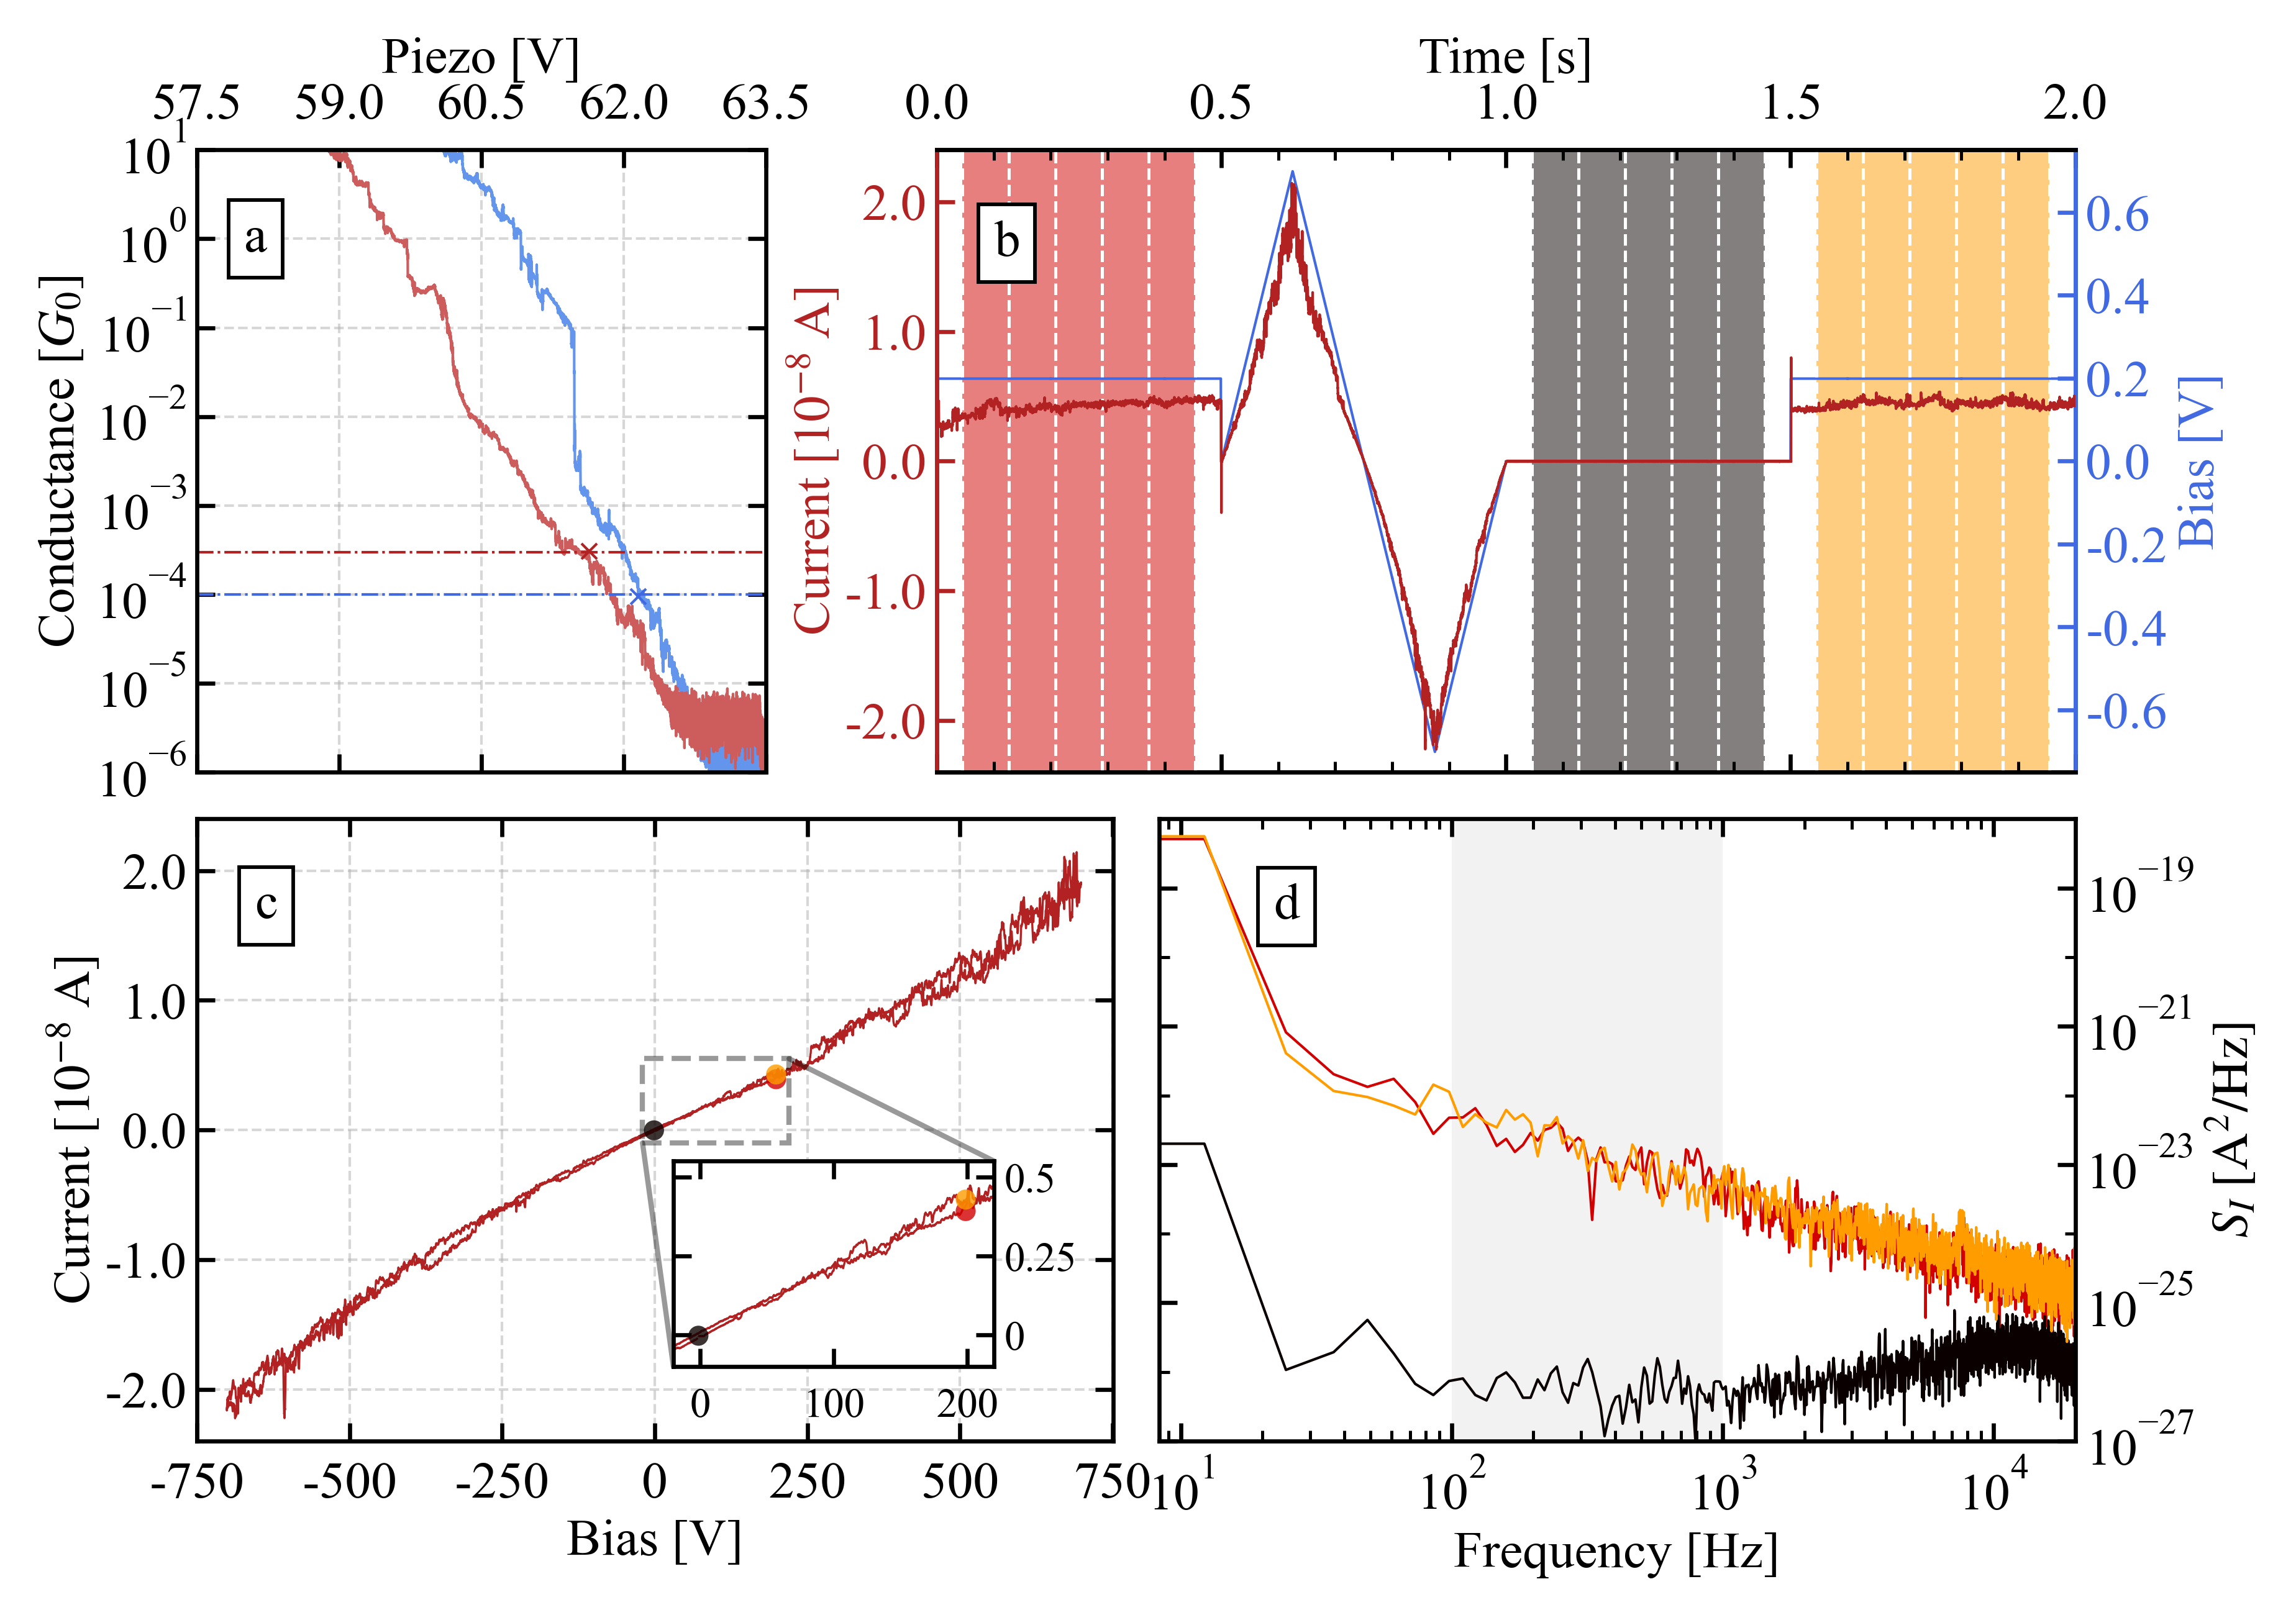

In [7]:
which_trace = 43008  # [24044, 25033, 30736, 30981, 41442, 43008]
# which_trace = 30981

trace_pair = TracePair(which_trace, load_from=home_folder_1)
hold_trace = HoldTrace(which_trace,
                       load_from=home_folder_1, bias_offset=0,
                       r_serial_ohm=trace_pair.R_serial, min_step_len=20_000, min_height=1, iv=0)

hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=False)

color_list = colormaps['hot'](np.linspace(0, 0.6, 3))
my_color_list = [color_list[1], color_list[0], color_list[2]]

# color_list = colormaps['gist_heat'](np.linspace(0, 0.6, 3))
# my_color_list = [color_list[1], color_list[0], color_list[2]]

# color_list = colormaps['Reds'](np.linspace(0.4, 1, 2))[::-1]
# my_color_list = [color_list[0], [0, 0, 0, 0], color_list[1]]

fig, ax_trace, ax_hold, par_hold, ax_iv, ax_psd = plot_ivs_scheme_one(trace_pair=trace_pair, hold_trace=hold_trace, direction='push',
                                                                      smoothing=10, which_psds=[0, 1, 2], vline_color='white',
                                                                      color_list=my_color_list, fig_size=utils.cm2inch(16, 11))
ax_hold.set_xlim(0, 2)
ax_hold.set_xticks(np.arange(0, 2.1, 0.5), minor=False)
ax_hold.set_xticks(np.arange(0, 2.1, 0.1), minor=True)
ax_hold.set_ylim(-2.4e-8, 2.4e-8)
ax_hold.set_yticks(np.arange(-2e-8, 2.1e-8, 1e-8))
ax_hold.set_yticklabels(np.arange(-2, 2.1, 1))
par_hold.set_ylim(-0.75, 0.75)
par_hold.set_yticks(np.arange(-0.6, 0.74, 0.2))
par_hold.set_yticklabels(np.round(np.arange(-0.6, 0.74, 0.2), 2))
par_hold.tick_params(axis='y', colors='royalblue')
par_hold.yaxis.label.set_color('royalblue')
par_hold.spines['right'].set_color('royalblue')
ax_hold.spines['right'].set_color('royalblue')
ax_iv.set_xlim(-0.75, 0.751)
ax_iv.set_xticks(np.arange(-0.75, 0.751, 0.25))
ax_iv.set_xticklabels(np.arange(-750, 751, 250))
# ax_iv.set_ylim(-2.5e-8, 2.5e-8)
# ax_iv.set_yticks(np.arange(-2.5e-8, 2.51e-8, 5e-9))
# ax_iv.set_yticklabels(np.arange(-2.5, 2.51, 0.5))
ax_iv.set_ylim(-2.4e-8, 2.4e-8)
ax_iv.set_yticks(np.arange(-2e-8, 2.1e-8, 1e-8))
ax_iv.set_yticklabels(np.arange(-2, 2.1, 1))
ax_iv.grid(ls='--', lw=0.5, alpha=0.5)

iv_bias = hold_trace.iv_bias_push
iv_current = hold_trace.iv_current_push

axin_iv = ax_iv.inset_axes([0.52, 0.12, 0.35, 0.33])
axin_iv.plot(utils.moving_average(iv_bias, 10),
             utils.moving_average(iv_current, 10),
             c='firebrick', lw=0.4)
             # c=accent_colors[col_index], lw=0.4)
axin_iv.set_xlim(-0.02, 0.22)
axin_iv.set_xticks(np.arange(0, 0.21, 0.1))
axin_iv.set_xticklabels(np.arange(0, 201, 100))
axin_iv.set_ylim(-1e-9, 5.5e-9)
axin_iv.set_yticks([0, 2.5e-9, 5e-9])
axin_iv.set_yticklabels([0, 0.25, 0.5])
axin_iv.tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=False, labelright=True, labeltop=False, labelbottom=True)
axin_iv.tick_params(axis='both', labelsize=8)

ax_iv.indicate_inset_zoom(axin_iv, edgecolor='black', alpha=0.4, ls='--')

# load I(V) fit
# and add to plots
iv_fit_df = pd.read_excel(io=home_folder_1.joinpath('results/IVs/selected/Tunnel_22_02_03_push_fitIV_data_selected.xlsx'),
                          sheet_name=f'tr{which_trace}')

# ax_iv.plot(iv_fit_df['V [V]'][np.bitwise_and(iv_fit_df['V [V]'] > min(hold_trace.iv_bias_push), iv_fit_df['V [V]'] < max(hold_trace.iv_bias_push))],
#            iv_fit_df['I [A]'][np.bitwise_and(iv_fit_df['V [V]'] > min(hold_trace.iv_bias_push), iv_fit_df['V [V]'] < max(hold_trace.iv_bias_push))], lw=0.5, alpha=1, c='k')

# axin_iv.plot(iv_fit_df['V [V]'][np.bitwise_and(iv_fit_df['V [V]'] > min(hold_trace.iv_bias_push), iv_fit_df['V [V]'] < max(hold_trace.iv_bias_push))],
#              iv_fit_df['I [A]'][np.bitwise_and(iv_fit_df['V [V]'] > min(hold_trace.iv_bias_push), iv_fit_df['V [V]'] < max(hold_trace.iv_bias_push))], lw=0.5, alpha=1, c='k')

# add individual mean current vs bias step points

for i, j, col in zip(hold_trace.bias_steps, hold_trace.avg_current_on_step_push, my_color_list):
    ax_iv.scatter(i, j, color=col, edgecolor='None', alpha=0.8, s=15, zorder=3)
    axin_iv.scatter(i, j, color=col, edgecolor='None', alpha=0.8, s=15, zorder=3)
    
ax_psd.set_ylim(1e-27, 1e-18)
# print(ax_psd.get_xlim())
ax_psd.set_xlim(8.3, 2e4)

bbox_props = dict(boxstyle="square", lw=0.7, fc="w", ec="black", alpha=1)
ax_trace.text(s='a', x=58, y=1, bbox=bbox_props, va='center') # 43008
ax_trace.set_xlim(57.5, 63.5)
ax_trace.set_xticks(np.arange(57.5, 63.6, 1.5))
ax_hold.text(s='b', x=0.1, y=0.85*(ax_hold.get_ylim()[1]-ax_hold.get_ylim()[0])+ax_hold.get_ylim()[0],
             bbox=bbox_props, va='center')
ax_iv.text(s='c', x=-0.655, y=1.55e-8, bbox=bbox_props, va='bottom')  # 43008

# ax_iv.set_ylim(-1e-8, 1e-8)

ax_psd.text(s='d', x=22, y=2.5e-20, bbox=bbox_props, va='bottom')

plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/hold_measurement_explanation_{which_trace}.png'), bbox_inches='tight')

In [8]:
file = pd.ExcelFile(home_folder_1.joinpath('results/IVs/selected/Tunnel_22_02_03_push_fitIV_data_selected.xlsx'))
file.sheet_names

['tr24044', 'tr25033', 'tr30736', 'tr30981', 'tr41442', 'tr43008']

In [9]:
example_ivs = list(map(lambda x: int(re.match(r'tr(\d{1,5})', x).group(1)), file.sheet_names))
example_ivs

[24044, 25033, 30736, 30981, 41442, 43008]

In [10]:
iv_fit_df.head()

V [V]         I [A]
0  0.000  0.000000e+00
1  0.005  1.047227e-10
2  0.010  2.103405e-10
3  0.015  3.160858e-10
4  0.020  4.211096e-10

In [11]:
iv_fit_dfs = {int(re.match(r'tr(\d{1,5})', i).group(1)): pd.read_excel(io=file, sheet_name=i) for i in file.sheet_names}

In [12]:
#iv_fit_dfs

In [13]:
iv_fit_dfs[43008].columns

Index(['V [V]', 'I [A]'], dtype='object')

In [14]:
example_ivs

[24044, 25033, 30736, 30981, 41442, 43008]

In [15]:
sim_data_pull = pd.read_excel(io=home_folder_1.joinpath('results/IVs/selected/Tunnel_22_02_03_pull_fits_all.xlsx'))
sim_data_push = pd.read_excel(io=home_folder_1.joinpath('results/IVs/selected/Tunnel_22_02_03_push_fits_all.xlsx'))

In [16]:
noise_pull = pd.read_csv(home_folder_1.joinpath('results/IVs/selected/noise_data_pull.csv'))
noise_push = pd.read_csv(home_folder_1.joinpath('results/IVs/selected/noise_data_push.csv'))

In [17]:
sim_data_pull['Part'] = sim_data_pull['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))
sim_data_pull['G [G0]'] = sim_data_pull['R [Ohm]'].map(utils.convert_ohm_to_g0)

In [18]:
sim_data_push['Part'] = sim_data_push['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))
sim_data_push['G [G0]'] = sim_data_push['R [Ohm]'].map(utils.convert_ohm_to_g0)

In [19]:
sim_data_pull = sim_data_pull.sort_values(by=['Trace', 'Part'])
sim_data_push = sim_data_push.sort_values(by=['Trace', 'Part'])

In [20]:
sim_data_pull['G_meas1 [G0]'] = np.vstack((noise_pull['avg_cond_1'],
                                           noise_pull['avg_cond_1'], 
                                           noise_pull['avg_cond_1'], 
                                           noise_pull['avg_cond_1'])).T.flatten()

sim_data_pull['G_meas2 [G0]'] = np.vstack((noise_pull['avg_cond_2'],
                                           noise_pull['avg_cond_2'], 
                                           noise_pull['avg_cond_2'], 
                                           noise_pull['avg_cond_2'])).T.flatten()

sim_data_pull['dG/G_meas1'] = np.vstack((noise_pull['conductance_noise_1'],
                                         noise_pull['conductance_noise_1'], 
                                         noise_pull['conductance_noise_1'], 
                                         noise_pull['conductance_noise_1'])).T.flatten()

sim_data_pull['dG/G_meas2'] = np.vstack((noise_pull['conductance_noise_2'],
                                         noise_pull['conductance_noise_2'], 
                                         noise_pull['conductance_noise_2'], 
                                         noise_pull['conductance_noise_2'])).T.flatten()

In [21]:
sim_data_push['G_meas1 [G0]'] = np.vstack((noise_push['avg_cond_1'],
                                           noise_push['avg_cond_1'], 
                                           noise_push['avg_cond_1'], 
                                           noise_push['avg_cond_1'])).T.flatten()

sim_data_push['G_meas2 [G0]'] = np.vstack((noise_push['avg_cond_2'],
                                           noise_push['avg_cond_2'], 
                                           noise_push['avg_cond_2'], 
                                           noise_push['avg_cond_2'])).T.flatten()

sim_data_push['dG/G_meas1'] = np.vstack((noise_push['conductance_noise_1'],
                                         noise_push['conductance_noise_1'], 
                                         noise_push['conductance_noise_1'], 
                                         noise_push['conductance_noise_1'])).T.flatten()

sim_data_push['dG/G_meas2'] = np.vstack((noise_push['conductance_noise_2'],
                                         noise_push['conductance_noise_2'], 
                                         noise_push['conductance_noise_2'], 
                                         noise_push['conductance_noise_2'])).T.flatten()

43008
30736


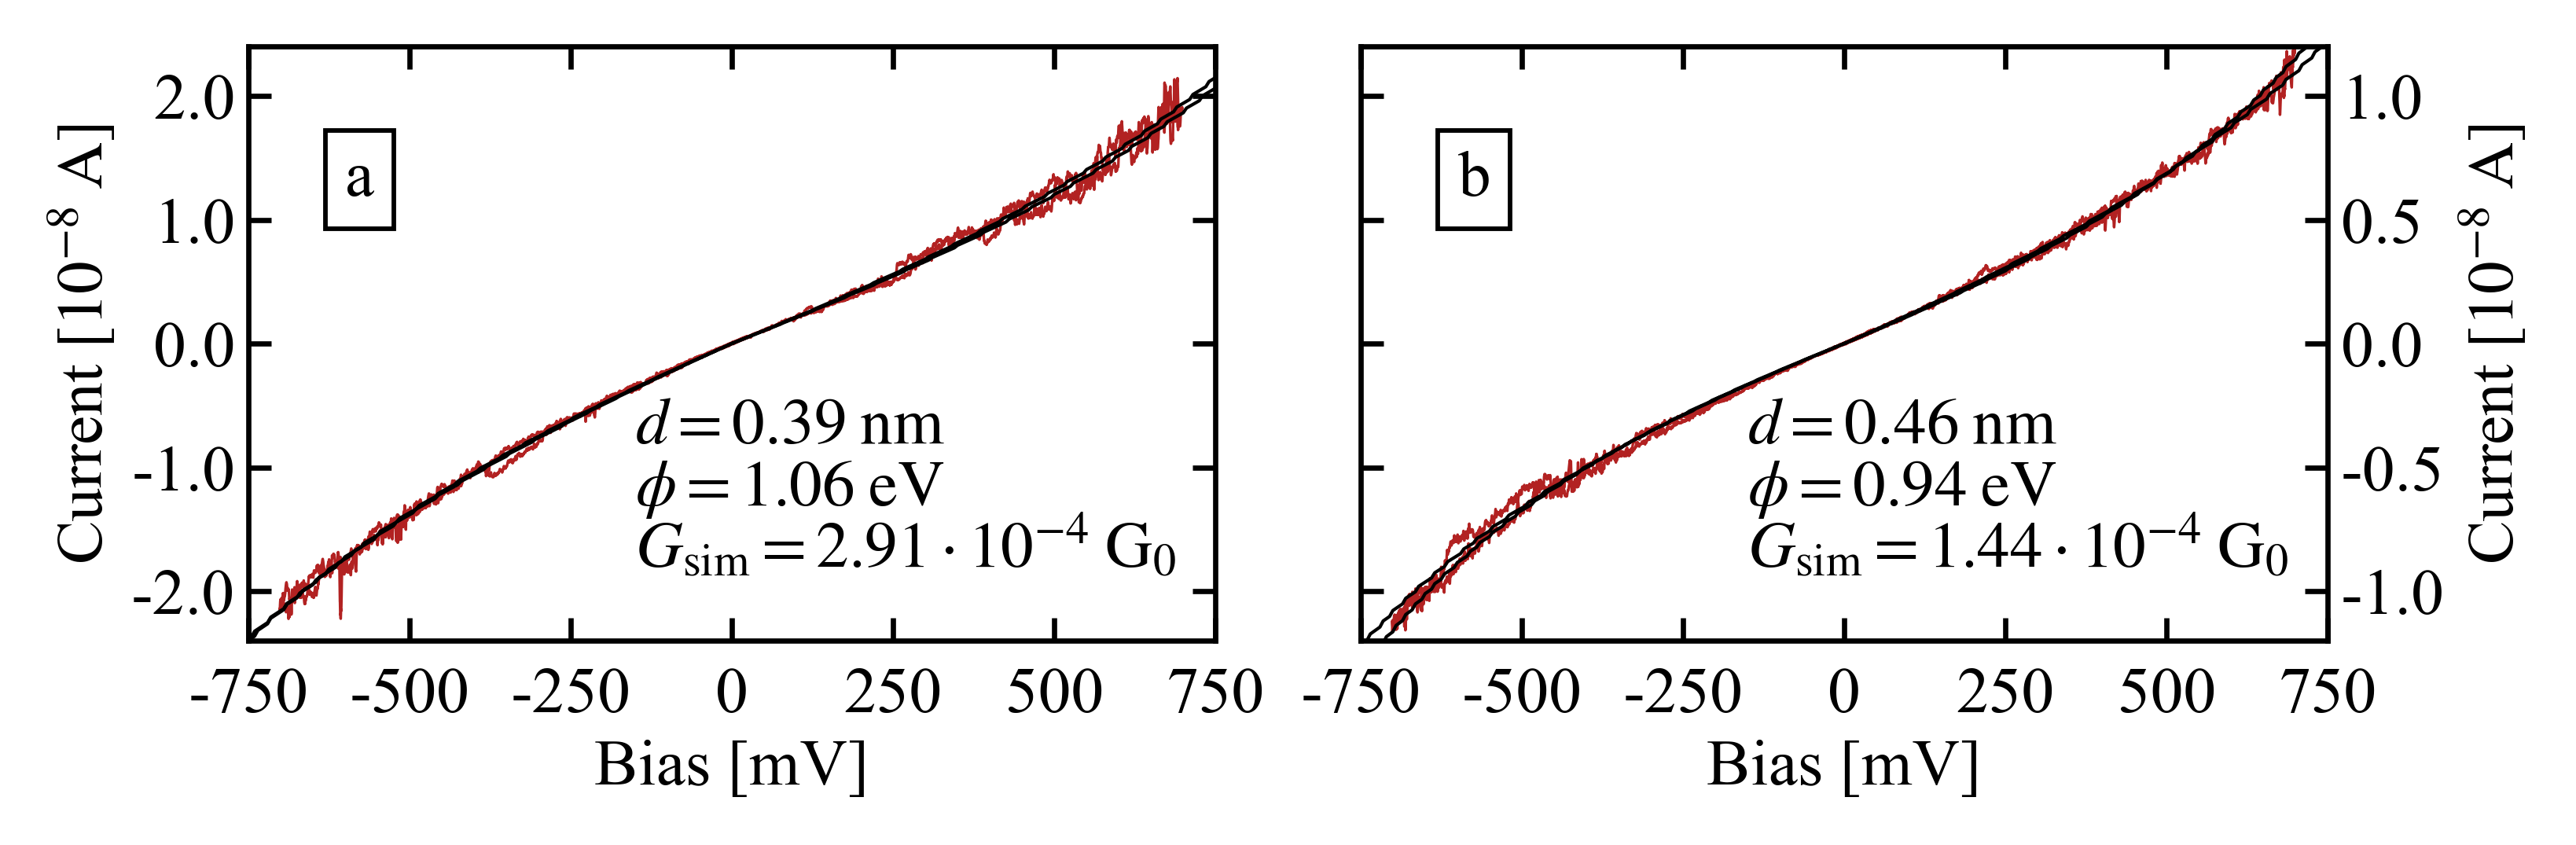

In [22]:
fig = plt.figure(figsize=utils.cm2inch(14, 4), dpi=600)
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=(1, 1),
                       figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.2)

axs = []

my_example_ivs = [43008, 30736]
letters = ['a', 'b']

bbox_props = dict(boxstyle="square", lw=0.7, fc="w", ec="black", alpha=1)

sim_push_mean_vals = sim_data_push.groupby('Trace').mean()[['R [Ohm]', 'G [G0]', 'z -Gap [nm]', 'Phi - Barrier [eV]']]

for i in range(2):
    axs.append(fig.add_subplot(gs[i]))
    print(my_example_ivs[i])
    trace_pair = TracePair(my_example_ivs[i], load_from=home_folder_1)
    hold_trace = HoldTrace(my_example_ivs[i],
                           load_from=home_folder_1, bias_offset=0,
                           r_serial_ohm=trace_pair.R_serial, min_step_len=20_000, min_height=1, iv=0)

    hold_trace.analyse_hold_trace(num_of_fft=5, subtract_bg=False)
    
    iv_bias = hold_trace.iv_bias_push
    iv_current = hold_trace.iv_current_push
    
    axs[-1].plot(utils.moving_average(iv_bias, 10),
                 utils.moving_average(iv_current, 10),
                 c='firebrick', lw=0.4)
    axs[-1].plot(iv_fit_dfs[my_example_ivs[i]]['V [V]'], iv_fit_dfs[my_example_ivs[i]]['I [A]'], c='k', lw=0.5)
    axs[-1].set_xlim(-0.75, 0.75)
    
    # axs[0].text(x=-0.6, y=0, s=example_ivs[i])

    axs[-1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                        labelleft=not(i%2), labelright=i%2, labeltop=False, labelbottom=True)
    
    axs[-1].set_xticks(np.arange(-0.75, 0.751, 0.25))
    axs[-1].set_xticklabels(np.arange(-750, 751, 250))
    axs[-1].set_xlabel('Bias [mV]')

axs[0].set_ylim(-2.4e-8, 2.4e-8)
axs[0].set_yticks(np.arange(-2e-8, 2.1e-8, 1e-8))
axs[0].set_yticklabels(np.arange(-2, 2.1, 1))
axs[0].set_ylabel(r'Current [$10^{' +str(utils.get_exponent(max(abs(iv_current)))) + r'}\;\mathrm{A}$]')

axs[1].set_ylim(-1.2e-8, 1.2e-8)
axs[1].set_yticks(np.arange(-1e-8, 1.1e-8, 5e-9))
axs[1].set_yticklabels(np.arange(-1, 1.1, 0.5))
axs[1].set_ylabel(r'Current [$10^{' +str(utils.get_exponent(max(abs(iv_current)))) + r'}\;\mathrm{A}$]')

# axs[0].text(x=0.0, y=-0.8e-8, s=r'$R_\mathrm{sim}='+f'{np.round(sim_push_mean_vals.loc[my_example_ivs[0]]["R [Ohm]"]/10**6, 2)}'+ r'\;\mathrm{M\Omega}$')

cond0 = sim_push_mean_vals.loc[my_example_ivs[0]]["G [G0]"]
# print(cond0)
# print(r'$' + f'{np.round(cond0*10**abs(utils.get_exponent(cond0)), 2)}'+r' \cdot 10^{' + f'{utils.get_exponent(cond0)}' +r'}\;\mathrm{G}_{0}$')
axs[0].text(x=-0.15, y=-0.8e-8, s=r'$d='+f'{np.round(sim_push_mean_vals.loc[my_example_ivs[0]]["z -Gap [nm]"], 2)}'+ r'\;\mathrm{nm}$')
axs[0].text(x=-0.15, y=-1.3e-8, s=r'$\phi='+f'{np.round(sim_push_mean_vals.loc[my_example_ivs[0]]["Phi - Barrier [eV]"], 2)}'+ r'\;\mathrm{eV}$')
axs[0].text(x=-0.15, y=-1.8e-8,
            s=r'$G_\mathrm{sim}='+f'{np.round(cond0*10**abs(utils.get_exponent(cond0)), 2)}'+r' \cdot 10^{' + f'{utils.get_exponent(cond0)}' +r'}\;\mathrm{G}_{0}$')

cond1 = sim_push_mean_vals.loc[my_example_ivs[1]]["G [G0]"]
# axs[-1].text(x=0.0, y=-0.4e-8, s=r'$R_\mathrm{sim}='+f'{np.round(sim_push_mean_vals.loc[my_example_ivs[1]]["R [Ohm]"]/10**6, 2)}'+ r'\;\mathrm{M\Omega}$')
axs[-1].text(x=-0.15, y=-0.4e-8, s=r'$d='+f'{np.round(sim_push_mean_vals.loc[my_example_ivs[1]]["z -Gap [nm]"], 2)}'+ r'\;\mathrm{nm}$')
axs[-1].text(x=-0.15, y=-0.65e-8, s=r'$\phi='+f'{np.round(sim_push_mean_vals.loc[my_example_ivs[1]]["Phi - Barrier [eV]"], 2)}'+ r'\;\mathrm{eV}$')
axs[-1].text(x=-0.15, y=-0.9e-8,
             s=r'$G_\mathrm{sim}='+f'{np.round(cond1*10**abs(utils.get_exponent(cond0)), 2)}'+r' \cdot 10^{' + f'{utils.get_exponent(cond0)}' +r'}\;\mathrm{G}_{0}$')

axs[0].text(x=-0.6, y=1.2e-8, s=letters[0], bbox=bbox_props)
axs[1].text(x=-0.6, y=6e-9, s=letters[1], bbox=bbox_props)

axs[-1].yaxis.set_label_position('right')

plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/example_iv_curves_and_fits.png'), bbox_inches='tight')

In [23]:
sim_data_push.groupby('Trace').mean()[['R [Ohm]', 'G [G0]', 'z -Gap [nm]', 'Phi - Barrier [eV]']].loc[43008]['G [G0]']

0.0002908346227266976

In [24]:
sim_data_push.loc[sim_data_push['Trace']==43008][['Trace', 'R [Ohm]', 'G [G0]', 'z -Gap [nm]', 'Phi - Barrier [eV]']]

Trace     R [Ohm]    G [G0]  z -Gap [nm]  Phi - Barrier [eV]
18953  43008  46382274.0  0.000278         0.39                1.07
20759  43008  47711103.0  0.000270         0.39                1.09
22565  43008  42521349.0  0.000303         0.39                1.01
24371  43008  41417750.0  0.000311         0.38                1.08

In [25]:
sim_data_push.loc[sim_data_push['Trace']==30736][['Trace', 'R [Ohm]', 'G [G0]', 'z -Gap [nm]', 'Phi - Barrier [eV]']]

Trace     R [Ohm]    G [G0]  z -Gap [nm]  Phi - Barrier [eV]
2625   30736  89804708.0  0.000144         0.47                0.89
7038   30736  85232762.0  0.000151         0.44                1.06
11451  30736  91121468.0  0.000142         0.46                0.96
15864  30736  92972841.0  0.000139         0.48                0.85

In [26]:
sim_data_push.columns

Index(['Trace', 'Fit Trace', 'R [Ohm]', 'z -Gap [nm]', 'Phi - Barrier [eV]',
       'dR/dz', 'dR/dPhi', 'G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]',
       'dG/G_meas2', 'Part', 'G [G0]'],
      dtype='object')

In [27]:
sim_data_push.loc[sim_data_push['Trace']==43008][['Trace', 'R [Ohm]', 'z -Gap [nm]', 'Phi - Barrier [eV]']]

Trace     R [Ohm]  z -Gap [nm]  Phi - Barrier [eV]
18953  43008  46382274.0         0.39                1.07
20759  43008  47711103.0         0.39                1.09
22565  43008  42521349.0         0.39                1.01
24371  43008  41417750.0         0.38                1.08

In [28]:
hold_trace.avg_current_on_step_push
hold_trace.bias_steps

array([ 0.19875221, -0.00126   ,  0.19875221], dtype=float32)

In [29]:
def igor_gaussian_fun(x, y0, A, x0, width):
    
    """
    x0: mean
    width/2: variance
    A: amplitude
    y0: vertical offset
    """
    
    return y0 + A * np.exp( -1 * ((x - x0)/width)**2 )

In [30]:
def calc_noise_sim(sim_data_df, dgap=0.0, dphi=0.0, verbose=False):
    """
    Calculates noise from simulation data.
    You can select which parameter you want to be fluctuating and set the other to zero.
    If both values are nonzero, both parameters fluctuate.
    
    Parameters
    ----------
    sim_data_df: `pd.DataFrame` containing data from Laci's simulation software. (best fit parameters)
    dgap: float, gap fluctuation in nm, default: 0.0
    dphi: float, barrier fluctuation in eV, default: 0.0
        
    Returns
    -------
    calculated relative noise (dG/G) with the given fluctuating variables (dgap, dphi).
    """
    
    # 1e-9
    # 1.6e-19
    
    # if dgap is None and dphi is None:
    #     raise ValueError(f'You entered dgap={dgap} and dphi={dphi}. One of them has to be not `None`')
    # elif dgap is None:
    #     print("Calculating relative noise when the barrier fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dPhi'] * dphi * 1.6e-19 / sim_data_df['R [Ohm]']
    # elif dphi is None:
    #     print("Calculating relative noise when the gap fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dz'] * dgap * 1e-9 / sim_data_df['R [Ohm]']
    # else:
    #     print("Calculating relative noise when both the barrier and the gap fluctuates.")
    #     sim_fluct_relnoise_push = np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']
    #    
    # return sim_fluct_relnoise_push
    if verbose:
        print(f"Calculating relative noise when the barrier fluctuation is dphi={dphi} eV and the gap fluctuation is dgap={dgap} nm.")
    
    # multiply by 1e-9 so the unit is nanometer
    # multiply by 1.6e-19 (unit charge) so the unit is eV
    
    return (np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']).to_numpy()

In [31]:
def calc_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total'):
   
    x_bins_all = []
    y_bins_all = []
    x_hist1d_all = []
    y_hist1d_all = []
    x_mesh_all = []
    y_mesh_all = []
    hist2d_all = []
    
    for i in range(len(x_vars)):        
        x_bins, x_hist1d = utils.calc_hist_1d_single(data=df[x_vars[i]], xrange=xrange,
                                                     xbins_num=xbins_num, log_scale=log_scale, bin_mode=bin_mode)
        y_bins, y_hist1d = utils.calc_hist_1d_single(data=df[y_vars[i]], xrange=yrange,
                                                     xbins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)

        h, xedges, yedges = np.histogram2d(df[x_vars[i]], df[y_vars[i]],
                                           bins=[x_bins, y_bins])
        x_mesh, y_mesh = np.meshgrid(xedges, yedges)
        
        x_bins_all.append(x_bins)
        y_bins_all.append(y_bins)
        x_hist1d_all.append(x_hist1d)
        y_hist1d_all.append(y_hist1d)
        hist2d_all.append(h.T)
        x_mesh_all.append(x_mesh)
        y_mesh_all.append(y_mesh)
        
    return x_bins_all, x_hist1d_all, y_bins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all
    

def plot_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total', figsize=utils.cm2inch(16, 5), dpi=600,
                            cmap='viridis', **kwargs):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_vars, y_vars=y_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap, **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=True)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_vars[i])
        ax[i].set_ylabel(y_vars[i])
        
    ax[0].tick_params(which='both',
                      labelleft=True, labelright=False, labeltop=False, labelbottom=True)
    ax[-1].tick_params(which='both',
                      labelleft=False, labelright=True, labeltop=False, labelbottom=True)
    
    return fig, ax
    
def plot_2D_rel_noise_hist_and_scatter(df: pd.DataFrame,
                                       x_2d_vars: Tuple[str, ...], y_2d_vars: Tuple[str, ...],
                                       x_scat_vars: Tuple[str, ...], y_scat_vars: Tuple[str, ...],
                                       xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                                       log_scale=True, bin_mode='total', cmap='viridis',
                                       figsize=utils.cm2inch(16, 10), dpi=600, **kwargs):
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_2d_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_2d_vars, y_vars=y_2d_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_2d_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap)
        
        for j in range(len(x_scat_vars)):
            ax[i].scatter(df[x_scat_vars[j]], df[y_scat_vars[j]], **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_2d_vars[i])
        ax[i].set_ylabel(x_2d_vars[i])
        
    return fig, ax

## Filter those where barrier < 2

In [32]:
sim_data_pull = sim_data_pull[sim_data_pull['Phi - Barrier [eV]'] < 2]

sim_data_push = sim_data_push[sim_data_push['Phi - Barrier [eV]'] < 2]

In [33]:
sim_data_pull[['R [Ohm]', 'G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]']]

R [Ohm]  G_meas1 [G0]  G_meas2 [G0]    G [G0]
0      13069957.0      0.002974      0.001155  0.000987
639    12976073.0      0.002974      0.001155  0.000994
1278   17213803.0      0.002974      0.001155  0.000749
1917   20498335.0      0.002974      0.001155  0.000629
1       3730296.1      0.005064      0.002731  0.003458
...           ...           ...           ...       ...
10054  63364976.0      0.000408      0.000161  0.000204
4430   16774953.0      0.001002      0.000760  0.000769
6305   15951589.0      0.001002      0.000760  0.000809
8180   18777990.0      0.001002      0.000760  0.000687
10055  19203370.0      0.001002      0.000760  0.000672

[8845 rows x 4 columns]

In [34]:
utils.convert_ohm_to_g0(12976073.0)

0.0009941374405029934

In [35]:
sim_data_push

Trace                   Fit Trace      R [Ohm]  z -Gap [nm]  \
0      19515  '1_IV_trace_19515_push_pl'  123337740.0         0.43   
4413   19515  '2_IV_trace_19515_push_pl'  115852820.0         0.41   
8826   19515  '3_IV_trace_19515_push_pl'  118121180.0         0.43   
13239  19515  '4_IV_trace_19515_push_pl'  115108080.0         0.48   
1      19529  '1_IV_trace_19529_push_pl'  172076560.0         0.53   
...      ...                         ...          ...          ...   
23068  49083  '3_IV_trace_49083_push_pl'  104710350.0         0.43   
19457  49088  '1_IV_trace_49088_push_pl'  195853160.0         0.47   
21263  49088  '2_IV_trace_49088_push_pl'  201705620.0         0.50   
23069  49088  '3_IV_trace_49088_push_pl'  224151430.0         0.52   
24875  49088  '4_IV_trace_49088_push_pl'  206324660.0         0.46   

       Phi - Barrier [eV]         dR/dz       dR/dPhi  G_meas1 [G0]  \
0                    1.38  1.690506e+18  1.103075e+27      0.000104   
4413                 1.54  1.670889e+18  9.379184e+26      0.000104   
8826                 1.35  1.605310e+18  1.066052e+27      0.000104   
13239                0.96  1.354317e+18  1.531600e+27      0.000104   
1                    0.88  1.912228e+18  2.374670e+27      0.000081   
...                   ...           ...           ...           ...   
23068                1.27  1.394623e+18  9.722801e+26      0.000113   
19457                1.33  2.604451e+18  1.969822e+27      0.000067   
21263                1.13  2.508884e+18  2.352905e+27      0.000067   
23069                1.06  2.703747e+18  2.815920e+27      0.000067   
24875                1.45  2.850394e+18  1.953058e+27      0.000067   

       dG/G_meas1  G_meas2 [G0]  dG/G_meas2  Part    G [G0]  
0        0.098067      0.000115    0.046079     1  0.000105  
4413     0.098067      0.000115    0.046079     2  0.000111  
8826     0.098067      0.000115    0.046079     3  0.000109  
13239    0.098067      0.000115    0.046079     4  0.000112  
1        0.070921      0.000086    0.089175     1  0.000075  
...           ...           ...         ...   ...       ...  
23068    0.088571      0.000294    0.168821     3  0.000123  
19457    0.066466      0.000087    0.032976     1  0.000066  
21263    0.066466      0.000087    0.032976     2  0.000064  
23069    0.066466      0.000087    0.032976     3  0.000058  
24875    0.066466      0.000087    0.032976     4  0.000063  

[21168 rows x 13 columns]

In [36]:
meas_data_pull = sim_data_pull.groupby('Trace')[['G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2']].mean()
meas_data_push = sim_data_push.groupby('Trace')[['G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2']].mean()

In [37]:
meas_data_pull

G_meas1 [G0]  dG/G_meas1  G_meas2 [G0]  dG/G_meas2
Trace                                                    
19522      0.002974    0.085796      0.001155    0.143681
19811      0.005064    0.107289      0.002731    0.043851
19877      0.006574    0.035293      0.004031    0.025566
19905      0.011038    0.055643      0.007856    0.023391
19998      0.005919    0.052609      0.002665    0.054060
...             ...         ...           ...         ...
48454      0.000358    0.075724      0.000124    0.081056
48668      0.000072    0.168055      0.000056    0.071779
48837      0.002246    0.073720      0.001449    0.050695
48909      0.000408    0.037719      0.000161    0.050349
49042      0.001002    0.032493      0.000760    0.021734

[2508 rows x 4 columns]

In [38]:
meas_data_push

G_meas1 [G0]  dG/G_meas1  G_meas2 [G0]  dG/G_meas2
Trace                                                    
19515      0.000104    0.098067      0.000115    0.046079
19529      0.000081    0.070921      0.000086    0.089175
19535      0.000098    0.060375      0.000077    0.131780
19536      0.000123    0.105979      0.000136    0.049800
19568      0.000111    0.069067      0.000122    0.078762
...             ...         ...           ...         ...
49057      0.000080    0.283386      0.000102    0.138958
49067      0.000160    0.059936      0.000397    0.046973
49072      0.000086    0.104733      0.000123    0.073369
49083      0.000113    0.088571      0.000294    0.168821
49088      0.000067    0.066466      0.000087    0.032976

[6181 rows x 4 columns]

In [39]:
my_cmap = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1), colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))


my_cmap_blues = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                          colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))
my_cmap_reds = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                         colormaps['plasma'](np.linspace(0.0, 1.0, 31)))))

In [40]:
def calc_sq_diff(y1, y2, log_scale=True):
    if log_scale:
        y1 = np.log10(y1)
        y2 = np.log10(y2)
        
    return np.sum((y1-y2)**2)

def plot_sq_diff(dFluct, PhiFluct, sq_diff_all_1, sq_diff_all_2, plot_min=True, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(ncols=2, figsize=utils.cm2inch(14, 5), dpi=300)

    # xbins = PhiFluct
    # ybins = dFluct

    # print(np.diff(PhiFluct)[0])
    # print(np.diff(dFluct)[0])
    
    ind1 = np.unravel_index(np.argmin(sq_diff_all_1, axis=None), sq_diff_all_1.shape)
    ind2 = np.unravel_index(np.argmin(sq_diff_all_2, axis=None), sq_diff_all_2.shape)

    x_mesh, y_mesh = np.meshgrid(dFluct, PhiFluct)

    im1 = ax[0].pcolormesh(x_mesh, y_mesh, sq_diff_all_1.T, cmap='hot', vmin=min(sq_diff_all_1.flatten()), vmax=1.2*min(sq_diff_all_1.flatten()))
    fig.colorbar(im1, ax=ax[0], extend='max')
    im2 = ax[1].pcolormesh(x_mesh, y_mesh, sq_diff_all_2.T, cmap='hot', vmin=min(sq_diff_all_2.flatten()), vmax=1.2*min(sq_diff_all_2.flatten()))
    fig.colorbar(im2, ax=ax[1], extend='max')

    # ax[0].scatter(PhiFluct[ind1[0]], dFluct[ind1[1]], c='white', s=1)
    # ax[1].plot(PhiFluct[ind2[0]], dFluct[ind2[1]], markersize=1, marker='s', fillstyle='none')

    # Create a Rectangle patch
    # rect1 = patches.Rectangle((dFluct[ind1[1]]-0.00005, PhiFluct[ind1[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')
    # rect2 = patches.Rectangle((dFluct[ind2[1]]-0.00005, PhiFluct[ind2[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')

    # Add the patch to the Axes
    # ax[0].add_patch(rect1)
    # ax[1].add_patch(rect2)
    
    if plot_min:
        ax[0].scatter(dFluct[ind1[0]], PhiFluct[ind1[1]], s=1, label=f'({np.round(dFluct[ind1[0]], 5)}, {np.round(PhiFluct[ind1[1]], 5)})')
        ax[1].scatter(dFluct[ind2[0]], PhiFluct[ind2[1]], s=1, label=f'({np.round(dFluct[ind2[0]], 5)}, {np.round(PhiFluct[ind2[1]], 5)})')
    
    if xlim is not None:
        ax[0].set_xlim(xlim[0], xlim[1])
        ax[1].set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax[0].set_ylim(ylim[0], ylim[1])
        ax[1].set_ylim(ylim[0], ylim[1])

    ax[0].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[0].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    ax[1].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[1].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    
    ax[0].legend(fontsize=6)
    ax[1].legend(fontsize=6)
    
    return ax

In [131]:
def plot_sq_diff_1(dFluct, PhiFluct, sq_diff_all_1, sq_diff_all_2, dot_color='k', plot_min=True, xlim=None, ylim=None, **kwargs):
    
    fig, ax = plt.subplots(ncols=2, figsize=utils.cm2inch(14, 5), dpi=300)

    # xbins = PhiFluct
    # ybins = dFluct

    # print(np.diff(PhiFluct)[0])
    # print(np.diff(dFluct)[0])
    
    ind1 = np.unravel_index(np.argmin(sq_diff_all_1, axis=None), sq_diff_all_1.shape)
    ind2 = np.unravel_index(np.argmin(sq_diff_all_2, axis=None), sq_diff_all_2.shape)

    x_mesh, y_mesh = np.meshgrid(dFluct, PhiFluct)

    im1 = ax[0].pcolormesh(x_mesh, y_mesh, sq_diff_all_1.T, cmap='hot', vmax=np.round(min(sq_diff_all_pull_1.flatten()), 2)*5)
    fig.colorbar(im1, ax=ax[0], extend='max')
    im2 = ax[1].pcolormesh(x_mesh, y_mesh, sq_diff_all_2.T, cmap='hot', vmax=np.round(min(sq_diff_all_pull_2.flatten()), 2)*5)
    fig.colorbar(im2, ax=ax[1], extend='max')

    # ax[0].scatter(PhiFluct[ind1[0]], dFluct[ind1[1]], c='white', s=1)
    # ax[1].plot(PhiFluct[ind2[0]], dFluct[ind2[1]], markersize=1, marker='s', fillstyle='none')

    # Create a Rectangle patch
    # rect1 = patches.Rectangle((dFluct[ind1[1]]-0.00005, PhiFluct[ind1[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')
    # rect2 = patches.Rectangle((dFluct[ind2[1]]-0.00005, PhiFluct[ind2[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')

    # Add the patch to the Axes
    # ax[0].add_patch(rect1)
    # ax[1].add_patch(rect2)
    
    if plot_min:
        ax[0].scatter(dFluct[ind1[0]], PhiFluct[ind1[1]], s=1, c=dot_color, label=f'({np.round(dFluct[ind1[0]], 5)}, {np.round(PhiFluct[ind1[1]], 5)})')
        ax[1].scatter(dFluct[ind2[0]], PhiFluct[ind2[1]], s=1, c=dot_color, label=f'({np.round(dFluct[ind2[0]], 5)}, {np.round(PhiFluct[ind2[1]], 5)})')
    
    if xlim is not None:
        ax[0].set_xlim(xlim[0], xlim[1])
        ax[1].set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax[0].set_ylim(ylim[0], ylim[1])
        ax[1].set_ylim(ylim[0], ylim[1])

    ax[0].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[0].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    ax[1].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[1].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    
    ax[0].legend(fontsize=6)
    ax[1].legend(fontsize=6)
    
    return ax

In [42]:
def fit_gaussian_to_slice(y_mesh, hist_2d_single):
    popts = []
    popts_norm = []
    perrs = []

    hist_2d_gauss = []
    hist_2d_gauss_norm = []
    
    def nan_arr(to_shape: Union[int, Tuple[int, ...]]):
        a = np.zeros(to_shape)
        a[:] = np.nan
        
        return a
    
    for i in range(hist_2d_single.shape[-1]):
        ymiddle = np.log10(y_mesh[:-1, 0] + np.diff(y_mesh[:, 0])/2)# yedges[:-1] + np.diff(yedges)/2
    
        max_val = max(hist_2d_single[:, i])
        max_val_at = ymiddle[hist_2d_single[:, i] == max_val][0]
        
        
        if all(hist_2d_single[:, i] == 0):
            hist_2d_gauss.append(np.zeros_like(ymiddle))
            hist_2d_gauss_norm.append(np.zeros_like(ymiddle))
            popts.append(nan_arr(4))
            popts_norm.append(nan_arr(4))
            perrs.append(nan_arr(4))
        else:
            try:
                popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, hist_2d_single[:, i],
                                                      p0=(1e-10, max_val, max_val_at, 1))
                perr = np.sqrt(np.diag(pcov))

                popts.append(popt)
                popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
                perrs.append(perr)

                hist_2d_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
                hist_2d_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
            except RuntimeError:
                try:
                    popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, hist_2d_single[:, i],
                                                          p0=(1e-10, max_val, max_val_at, 0.01))
                    perr = np.sqrt(np.diag(pcov))

                    popts.append(popt)
                    popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
                    perrs.append(perr)

                    hist_2d_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
                    hist_2d_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
                except RuntimeError:
                    hist_2d_gauss.append(np.zeros_like(ymiddle))
                    hist_2d_gauss_norm.append(np.zeros_like(ymiddle))
                    popts.append(nan_arr(4))
                    popts_norm.append(nan_arr(4))
                    perrs.append(nan_arr(4))
    
    hist_2d_gauss = np.array(hist_2d_gauss).T
    hist_2d_gauss_norm = np.array(hist_2d_gauss_norm).T
    popts = np.array(popts)
    perrs = np.array(perrs)
    
    gaussian_fit_mean = popts[:, 2]
    gaussian_fit_mean_err = perrs[:, 2]
    
    return ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm

## Calculating 2D relative noise histograms for simulations

In [43]:
dFluct = np.arange(start=0, stop=0.0151, step=0.0001) ## stop/3
PhiFluct = np.arange(start=0.001, stop=0.151, step=0.001) ## stop/3

In [44]:
def calc_bins(middle: np.ndarray, log_scale=True):
    if log_scale:
        bin_width = np.mean(np.diff(np.log10(middle)))
        return np.append(10**(np.log10(middle)-bin_width/2), 10**(np.log10(middle[-1])+bin_width/2))
    else:
        bin_width = np.mean(np.diff(middle))
        return np.append(middle-bin_width/2, middle[-1]+bin_width/2)
    
def calc_hist_2d_new(x: np.ndarray, y: np.ndarray, xbins: np.ndarray, ybins: np.ndarray):
    h, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
    x_mesh, y_mesh = np.meshgrid(xedges, yedges)

    return x_mesh, y_mesh, h.T

In [82]:
sim_hist_2d_all_pull = []


for i, dz in enumerate(tqdm(dFluct)):
    for j, dP in enumerate(PhiFluct):
        relative_noise = calc_noise_sim(sim_data_df=sim_data_pull, dgap=dz, dphi=dP)
        
#         x_mesh, y_mesh, sim_hist_2d = utils.calc_hist_2d_single(x=sim_data_22_02_03['G [G0]'],
#                                                                 y=relative_noise,
#                                                                 xrange=(1e-5, 1e-2), log_scale_x=True,
#                                                                 yrange=(1e-3, 1), log_scale_y=True,
#                                                                 num_bins=(5, 20),
#                                                                 bin_mode_x='decade',
#                                                                 bin_mode_y='decade')
        
        x_mesh, y_mesh, sim_hist_2d = calc_hist_2d_new(x=sim_data_pull['G [G0]'],
                                                       y=relative_noise,
                                                       xbins=calc_bins(np.logspace(-5, -2, 30)),
                                                       ybins=calc_bins(np.logspace(-3, 0, 60)))
        
        
        sim_hist_2d_all_pull.append(sim_hist_2d)
        
sim_hist_2d_all_pull = np.array(sim_hist_2d_all_pull)
x_num, y_num = sim_hist_2d_all_pull.shape[1:]

print(sim_hist_2d_all_pull.reshape((i+1, j+1, x_num, y_num)).shape)

sim_hist_2d_all_pull = sim_hist_2d_all_pull.reshape((i+1, j+1, x_num, y_num))
print(sim_hist_2d_all_pull.shape)

  0%|          | 0/151 [00:00<?, ?it/s]

(151, 150, 60, 30)
(151, 150, 60, 30)


(0.0008, 0.02)


[Text(3e-05, 0.011, 'a'), Text(3e-05, 0.011, 'b'), Text(3e-05, 0.011, 'c')]

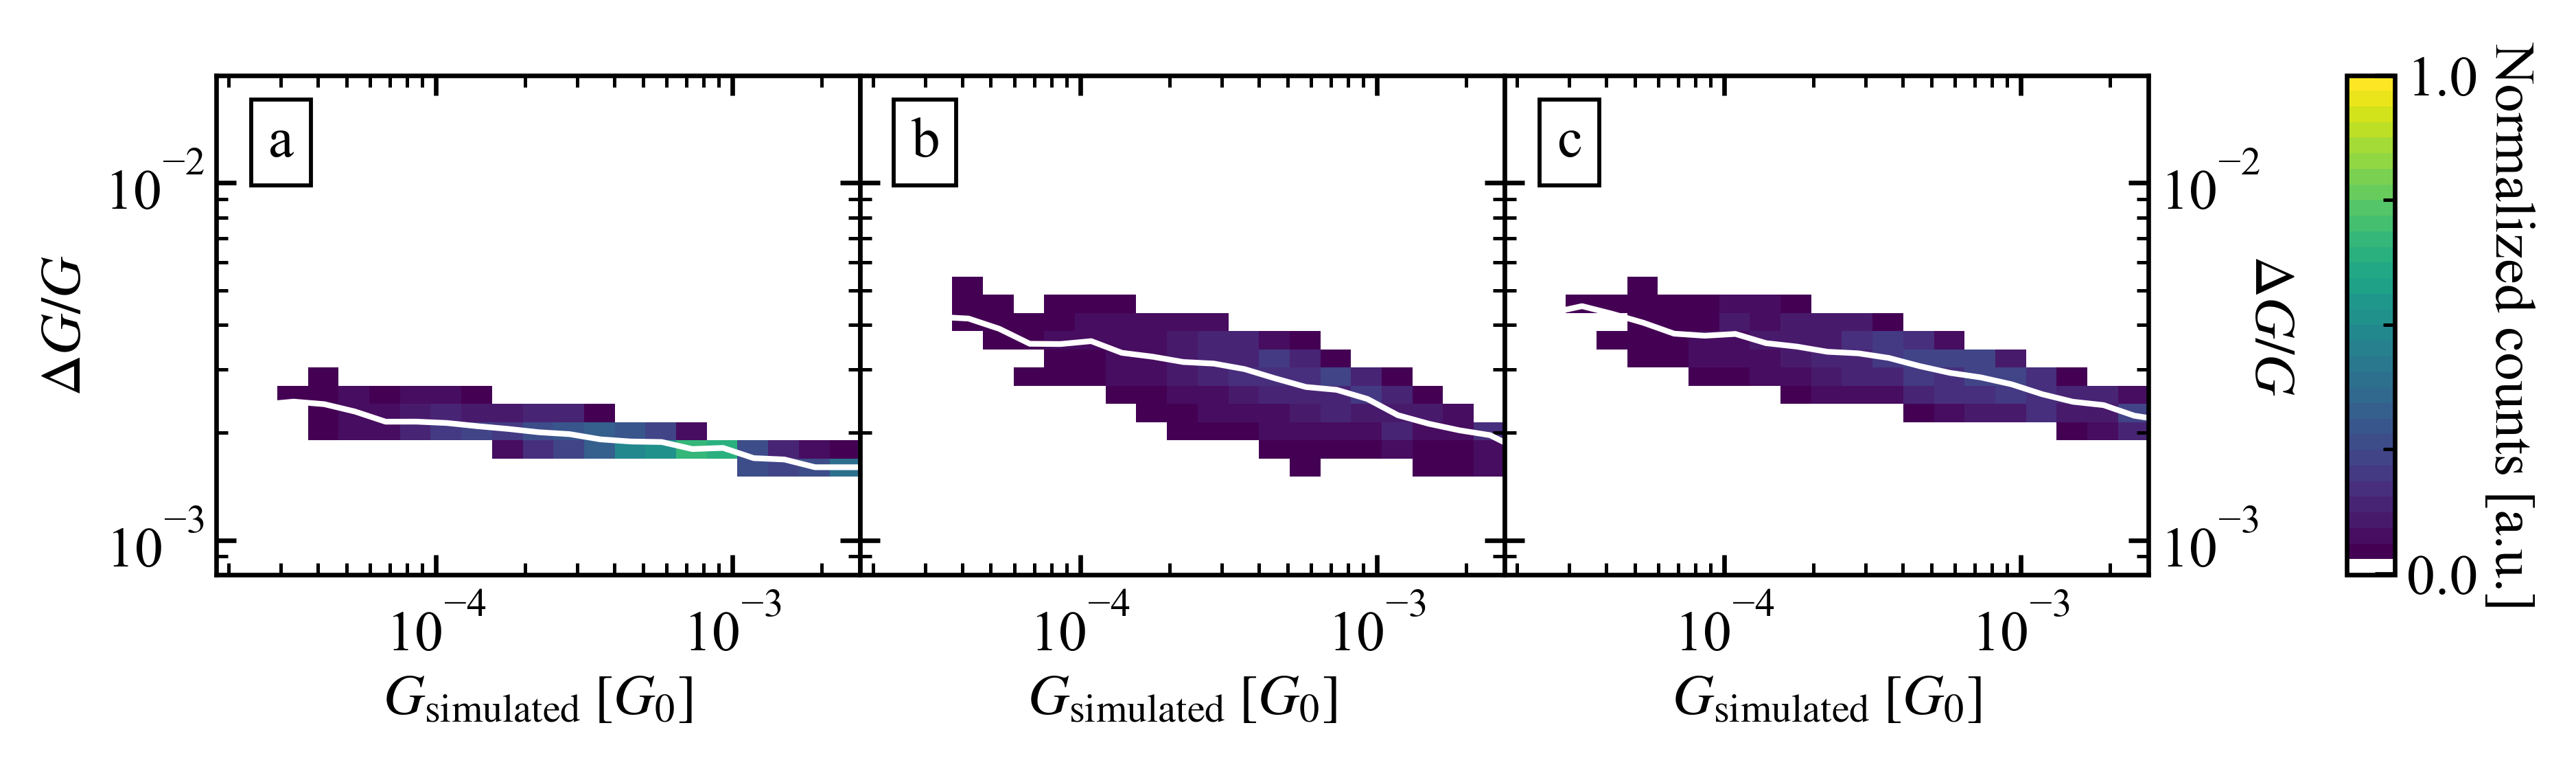

In [83]:
fig = plt.figure(figsize=utils.cm2inch(16, 4), dpi=600)

gs_total = plt.GridSpec(1, 2, figure=fig, width_ratios=(40, 1),
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.2)
gs_top = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, width_ratios=(1, 2),
                                              subplot_spec=gs_total[0],
                                              wspace=0.2, hspace=0)
gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_total[0], width_ratios=(1, 1, 1),
                                      # left=0.08, right=0.92, top=0.9, bottom=0.13,
                                      hspace=0.0, wspace=0.0)

axs = [fig.add_subplot(gs[i]) for i in range(3)]

ax_cbar = fig.add_subplot(gs_total[-1])

for i in range(3):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylim(8e-4, 2e-2)
    
# which_d = 14 #12 # 25
# which_phi = 19

which_d = 1
which_phi = 1

ymiddle_1, gaussian_fit_mean_1, gaussian_fit_mean_err_1, hist_2d_gauss_1, hist_2d_gauss_norm_1 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_pull[which_d, 0])

ymiddle_2, gaussian_fit_mean_2, gaussian_fit_mean_err_2, hist_2d_gauss_2, hist_2d_gauss_norm_2 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_pull[0, which_phi])

ymiddle_3, gaussian_fit_mean_3, gaussian_fit_mean_err_3, hist_2d_gauss_3, hist_2d_gauss_norm_3 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_pull[which_d, which_phi])

# cbar_axs = []
# cbar_axs.append(axs[0].inset_axes([0.45, 0.89, 0.5, 0.06]))
# cbar_axs.append(axs[1].inset_axes([0.45, 0.89, 0.5, 0.06]))
# cbar_axs.append(axs[2].inset_axes([0.45, 0.89, 0.5, 0.06]))


# axs[0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_pull_1, cmap=my_cmap_blues, vmin=-1)
# axs[0].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_1, cmap=my_cmap_blues)
im1 = axs[0].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_pull[which_d, 0], cmap=my_cmap_blues, vmin=-1, vmax=750)
axs[0].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_1, lw=1, c='w')

# fig.colorbar(im1, cax=cbar_axs[0], orientation='horizontal')

# axs[0].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_1, lw=1, c='r')
# axs[0].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_2, lw=1, c='b')
# axs[1].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_2, cmap=my_cmap_blues)
im2 = axs[1].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_pull[0, which_phi], cmap=my_cmap_blues, vmin=-1, vmax=750)
axs[1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_2, lw=1, c='w')

# fig.colorbar(im2, cax=cbar_axs[1], orientation='horizontal')

# axs[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_1, lw=1, c='r')
# axs[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_2, lw=1, c='b')
# axs[2].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_3, cmap=my_cmap_blues)
im3 = axs[2].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_pull[which_d, which_phi], cmap=my_cmap_blues, vmin=-1, vmax=750)
# fig.colorbar(im3, cax=cbar_axs[2], orientation='horizontal')
fig.colorbar(im3, cax=ax_cbar, orientation='vertical')

ax_cbar.set_yticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1), minor=False)
ax_cbar.set_yticks(np.linspace(0, 750, 5), minor=True)
# axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_1, lw=1, c='g')
# axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_2, lw=1, c='b')
axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_3, lw=1, c='w')

axs[0].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
axs[1].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
axs[2].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])

# print(cbar_axs[2].get_xlim())
# cbar_axs[0].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))
# cbar_axs[1].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))
# cbar_axs[2].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))


# axs[2].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_1, lw=1, c='r')
# axs[2].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_2, lw=1, c='b')

# axs[0].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[which_d], 4)}' + r'\;\mathrm{nm}$')
# axs[0].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[0], 4)}' + r'\;\mathrm{eV}$')

# axs[1].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[0], 4)}' + r'\;\mathrm{nm}$')
# axs[1].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[which_phi], 4)}' + r'\;\mathrm{eV}$')

# axs[2].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[which_d], 4)}' + r'\;\mathrm{nm}$')
# axs[2].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[which_phi], 4)}' + r'\;\mathrm{eV}$')

axs[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axs[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)
axs[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

axs[0].set_ylabel(r'$\Delta G / G$')
axs[-1].set_ylabel(r'$\Delta G / G$', rotation=270, labelpad=6)
axs[-1].yaxis.set_label_position('right')
[axs[i].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$') for i in range(3)]

ax_cbar.yaxis.set_label_position('right')
ax_cbar.set_ylabel('Normalized counts [a.u.]', rotation=270, labelpad=10)

axs_xlims = axs[0].get_xlim()
print(axs[0].get_ylim())
middle_point = 10**((np.log10(axs_xlims[1])-np.log10(axs_xlims[0]))/2 + np.log10(axs_xlims[0]))

# axs[0].text(x=middle_point, y=0.21, s='gap fluctuation only', ha='center', va='bottom')
# axs[1].text(x=middle_point, y=0.21, s='barrier fluctuation only', ha='center', va='bottom')
# axs[2].text(x=middle_point, y=0.21, s='gap & barrier fluctuation', ha='center', va='bottom')

[axs[i].text(x=3e-5, y=0.011, s=letters[i], ha='center', va='bottom', bbox=bbox_props) for i in range(3)]


# plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/relative_noise_histograms_pull_simulation.png'), bbox_inches='tight')

In [89]:
sim_hist_2d_all_push = []


for i, dz in enumerate(tqdm(dFluct)):
    for j, dP in enumerate(PhiFluct):
        relative_noise = calc_noise_sim(sim_data_df=sim_data_push, dgap=dz, dphi=dP)
        
#         x_mesh, y_mesh, sim_hist_2d = utils.calc_hist_2d_single(x=sim_data_22_02_03['G [G0]'],
#                                                                 y=relative_noise,
#                                                                 xrange=(1e-5, 1e-2), log_scale_x=True,
#                                                                 yrange=(1e-3, 1), log_scale_y=True,
#                                                                 num_bins=(5, 20),
#                                                                 bin_mode_x='decade',
#                                                                 bin_mode_y='decade')
        
        x_mesh, y_mesh, sim_hist_2d = calc_hist_2d_new(x=sim_data_push['G [G0]'],
                                                       y=relative_noise,
                                                       xbins=calc_bins(np.logspace(-5, -2, 30)),
                                                       ybins=calc_bins(np.logspace(-3, 0, 60)))
        
        sim_hist_2d_all_push.append(sim_hist_2d)
        
sim_hist_2d_all_push = np.array(sim_hist_2d_all_push)
x_num, y_num = sim_hist_2d_all_push.shape[1:]

print(sim_hist_2d_all_push.reshape((i+1, j+1, x_num, y_num)).shape)

sim_hist_2d_all_push = sim_hist_2d_all_push.reshape((i+1, j+1, x_num, y_num))
print(sim_hist_2d_all_push.shape)

  0%|          | 0/151 [00:00<?, ?it/s]

(151, 150, 60, 30)
(151, 150, 60, 30)


(0.0008, 0.02)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7160\1110183324.py:32: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


[Text(3e-05, 0.011, 'a'), Text(3e-05, 0.011, 'b'), Text(3e-05, 0.011, 'c')]

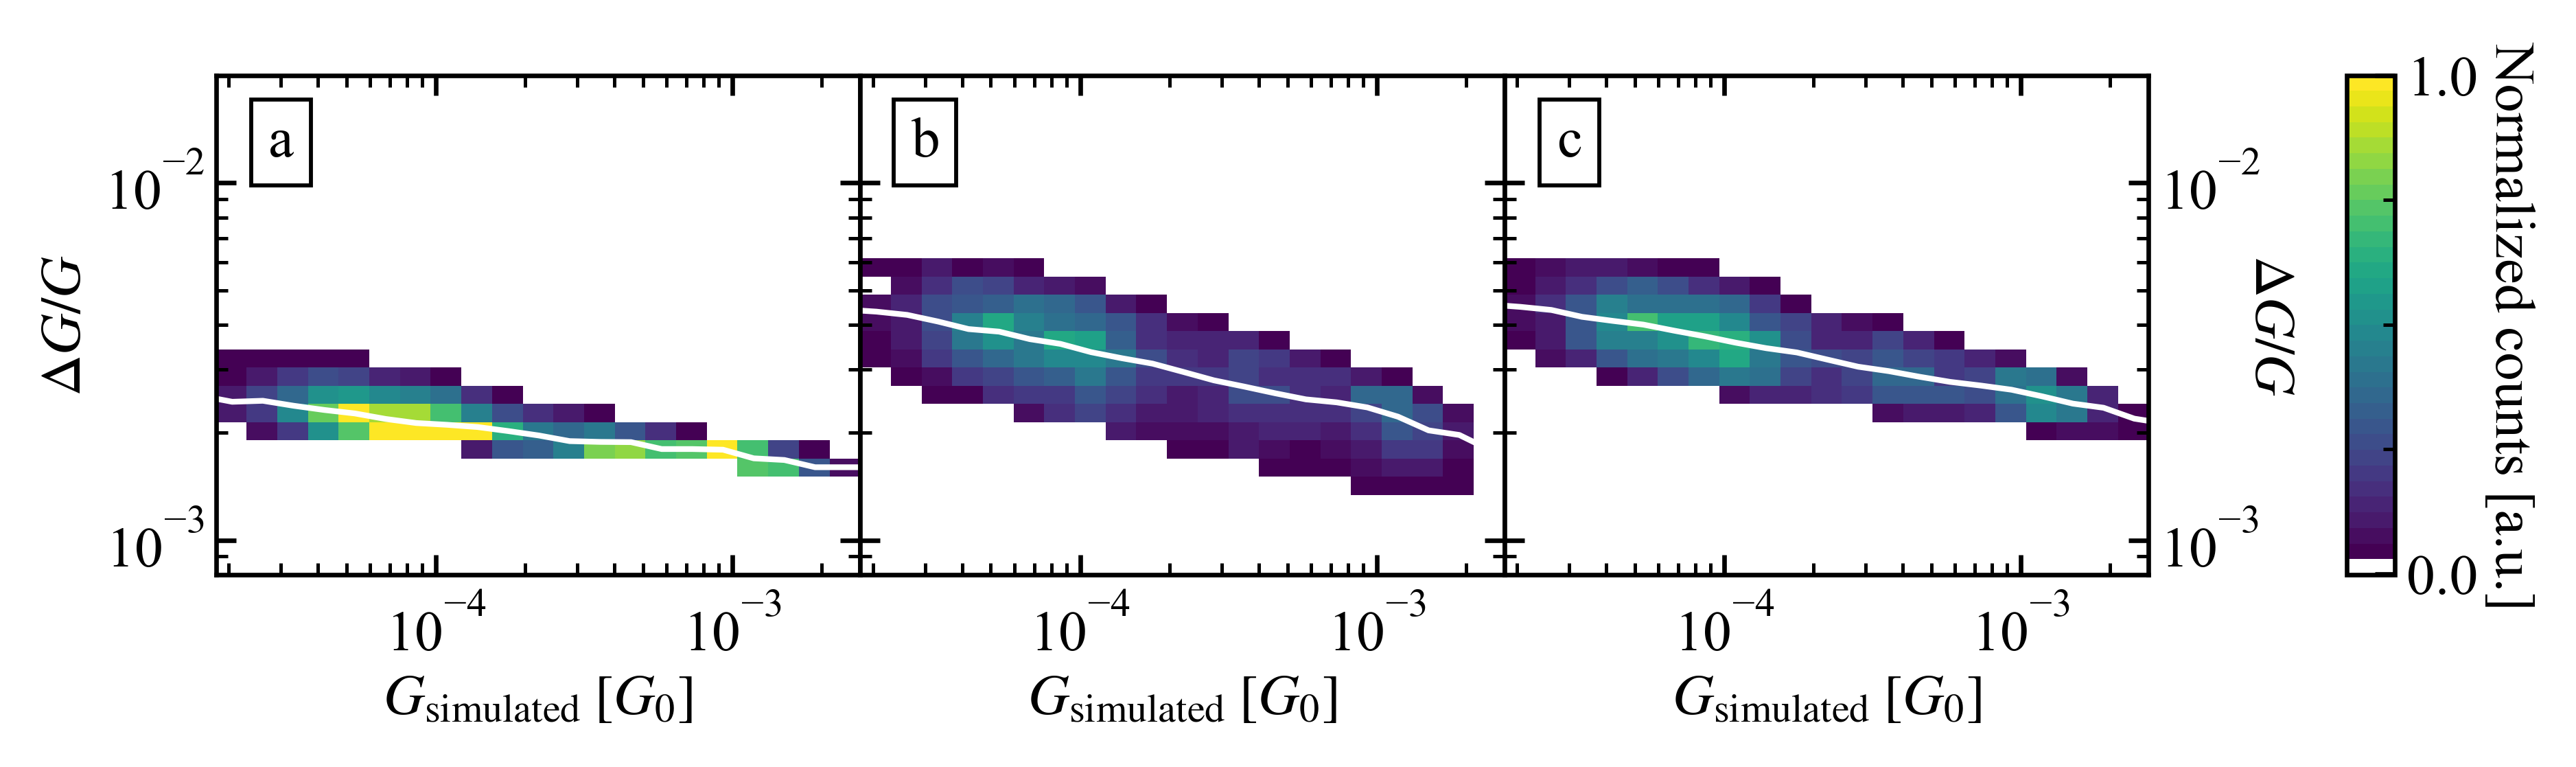

In [88]:
fig = plt.figure(figsize=utils.cm2inch(16, 4), dpi=600)

gs_total = plt.GridSpec(1, 2, figure=fig, width_ratios=(40, 1),
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.2)
gs_top = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, width_ratios=(1, 2),
                                              subplot_spec=gs_total[0],
                                              wspace=0.2, hspace=0)
gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_total[0], width_ratios=(1, 1, 1),
                                      # left=0.08, right=0.92, top=0.9, bottom=0.13,
                                      hspace=0.0, wspace=0.0)

axs = [fig.add_subplot(gs[i]) for i in range(3)]

ax_cbar = fig.add_subplot(gs_total[-1])

for i in range(3):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylim(8e-4, 2e-2)
    # axs[i].set_ylim(1e-2, 2e-1)
    
# which_d = 14 #12 # 25
# which_phi = 19

which_d = 1
which_phi = 1

ymiddle_1, gaussian_fit_mean_1, gaussian_fit_mean_err_1, hist_2d_gauss_1, hist_2d_gauss_norm_1 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[which_d, 0])

ymiddle_2, gaussian_fit_mean_2, gaussian_fit_mean_err_2, hist_2d_gauss_2, hist_2d_gauss_norm_2 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[0, which_phi])

ymiddle_3, gaussian_fit_mean_3, gaussian_fit_mean_err_3, hist_2d_gauss_3, hist_2d_gauss_norm_3 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[which_d, which_phi])

# cbar_axs = []
# cbar_axs.append(axs[0].inset_axes([0.45, 0.89, 0.5, 0.06]))
# cbar_axs.append(axs[1].inset_axes([0.45, 0.89, 0.5, 0.06]))
# cbar_axs.append(axs[2].inset_axes([0.45, 0.89, 0.5, 0.06]))


# axs[0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_push_1, cmap=my_cmap_blues, vmin=-1)
# axs[0].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_1, cmap=my_cmap_blues)
im1 = axs[0].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_push[which_d, 0], cmap=my_cmap_blues, vmin=-1, vmax=750)
axs[0].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_1, lw=1, c='w')

# fig.colorbar(im1, cax=cbar_axs[0], orientation='horizontal')

# axs[0].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='r')
# axs[0].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='b')
# axs[1].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_2, cmap=my_cmap_blues)
im2 = axs[1].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_push[0, which_phi], cmap=my_cmap_blues, vmin=-1, vmax=750)
axs[1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_2, lw=1, c='w')

# fig.colorbar(im2, cax=cbar_axs[1], orientation='horizontal')

# axs[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='r')
# axs[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='b')
# axs[2].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_3, cmap=my_cmap_blues)
im3 = axs[2].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_push[which_d, which_phi], cmap=my_cmap_blues, vmin=-1, vmax=750)
# fig.colorbar(im3, cax=cbar_axs[2], orientation='horizontal')
fig.colorbar(im3, cax=ax_cbar, orientation='vertical')

ax_cbar.set_yticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1), minor=False)
ax_cbar.set_yticks(np.linspace(0, 750, 5), minor=True)
# axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_1, lw=1, c='g')
# axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_2, lw=1, c='b')
axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_3, lw=1, c='w')

axs[0].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
axs[1].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
axs[2].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])

# print(cbar_axs[2].get_xlim())
# cbar_axs[0].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))
# cbar_axs[1].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))
# cbar_axs[2].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))


# axs[2].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='r')
# axs[2].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='b')

# axs[0].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[which_d], 4)}' + r'\;\mathrm{nm}$')
# axs[0].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[0], 4)}' + r'\;\mathrm{eV}$')

# axs[1].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[0], 4)}' + r'\;\mathrm{nm}$')
# axs[1].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[which_phi], 4)}' + r'\;\mathrm{eV}$')

# axs[2].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[which_d], 4)}' + r'\;\mathrm{nm}$')
# axs[2].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[which_phi], 4)}' + r'\;\mathrm{eV}$')

axs[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axs[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)
axs[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

axs[0].set_ylabel(r'$\Delta G / G$')
axs[-1].set_ylabel(r'$\Delta G / G$', rotation=270, labelpad=6)
axs[-1].yaxis.set_label_position('right')
[axs[i].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$') for i in range(3)]

ax_cbar.yaxis.set_label_position('right')
ax_cbar.set_ylabel('Normalized counts [a.u.]', rotation=270, labelpad=10)

axs_xlims = axs[0].get_xlim()
print(axs[0].get_ylim())
middle_point = 10**((np.log10(axs_xlims[1])-np.log10(axs_xlims[0]))/2 + np.log10(axs_xlims[0]))

# axs[0].text(x=middle_point, y=0.21, s='gap fluctuation only', ha='center', va='bottom')
# axs[1].text(x=middle_point, y=0.21, s='barrier fluctuation only', ha='center', va='bottom')
# axs[2].text(x=middle_point, y=0.21, s='gap & barrier fluctuation', ha='center', va='bottom')

[axs[i].text(x=3e-5, y=0.011, s=letters[i], ha='center', va='bottom', bbox=bbox_props) for i in range(3)]


# plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/relative_noise_histograms_push_simulation.png'), bbox_inches='tight')

## Calculating 2D relative noise histograms for measurements

In [47]:
warnings.filterwarnings("default")

### Pull

In [96]:
x_mesh_meas, y_mesh_meas, meas_hist_2d_pull_1 = calc_hist_2d_new(x=meas_data_pull['G_meas1 [G0]'],
                                                                 y=meas_data_pull['dG/G_meas1'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 30)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

x_mesh_meas, y_mesh_meas, meas_hist_2d_pull_2 = calc_hist_2d_new(x=meas_data_pull['G_meas2 [G0]'],
                                                                 y=meas_data_pull['dG/G_meas2'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 30)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

In [97]:
# Gaussian fit to normalize 2D histograms
ymiddle_meas_pull_1, gaussian_fit_mean_meas_pull_1, gaussian_fit_mean_err_meas_pull_1, hist_2d_gauss_meas_pull_1, hist_2d_gauss_norm_meas_pull_1 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_pull_1)

ymiddle_meas_pull_2, gaussian_fit_mean_meas_pull_2, gaussian_fit_mean_err_meas_pull_2, hist_2d_gauss_meas_pull_2, hist_2d_gauss_norm_meas_pull_2 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_pull_2)

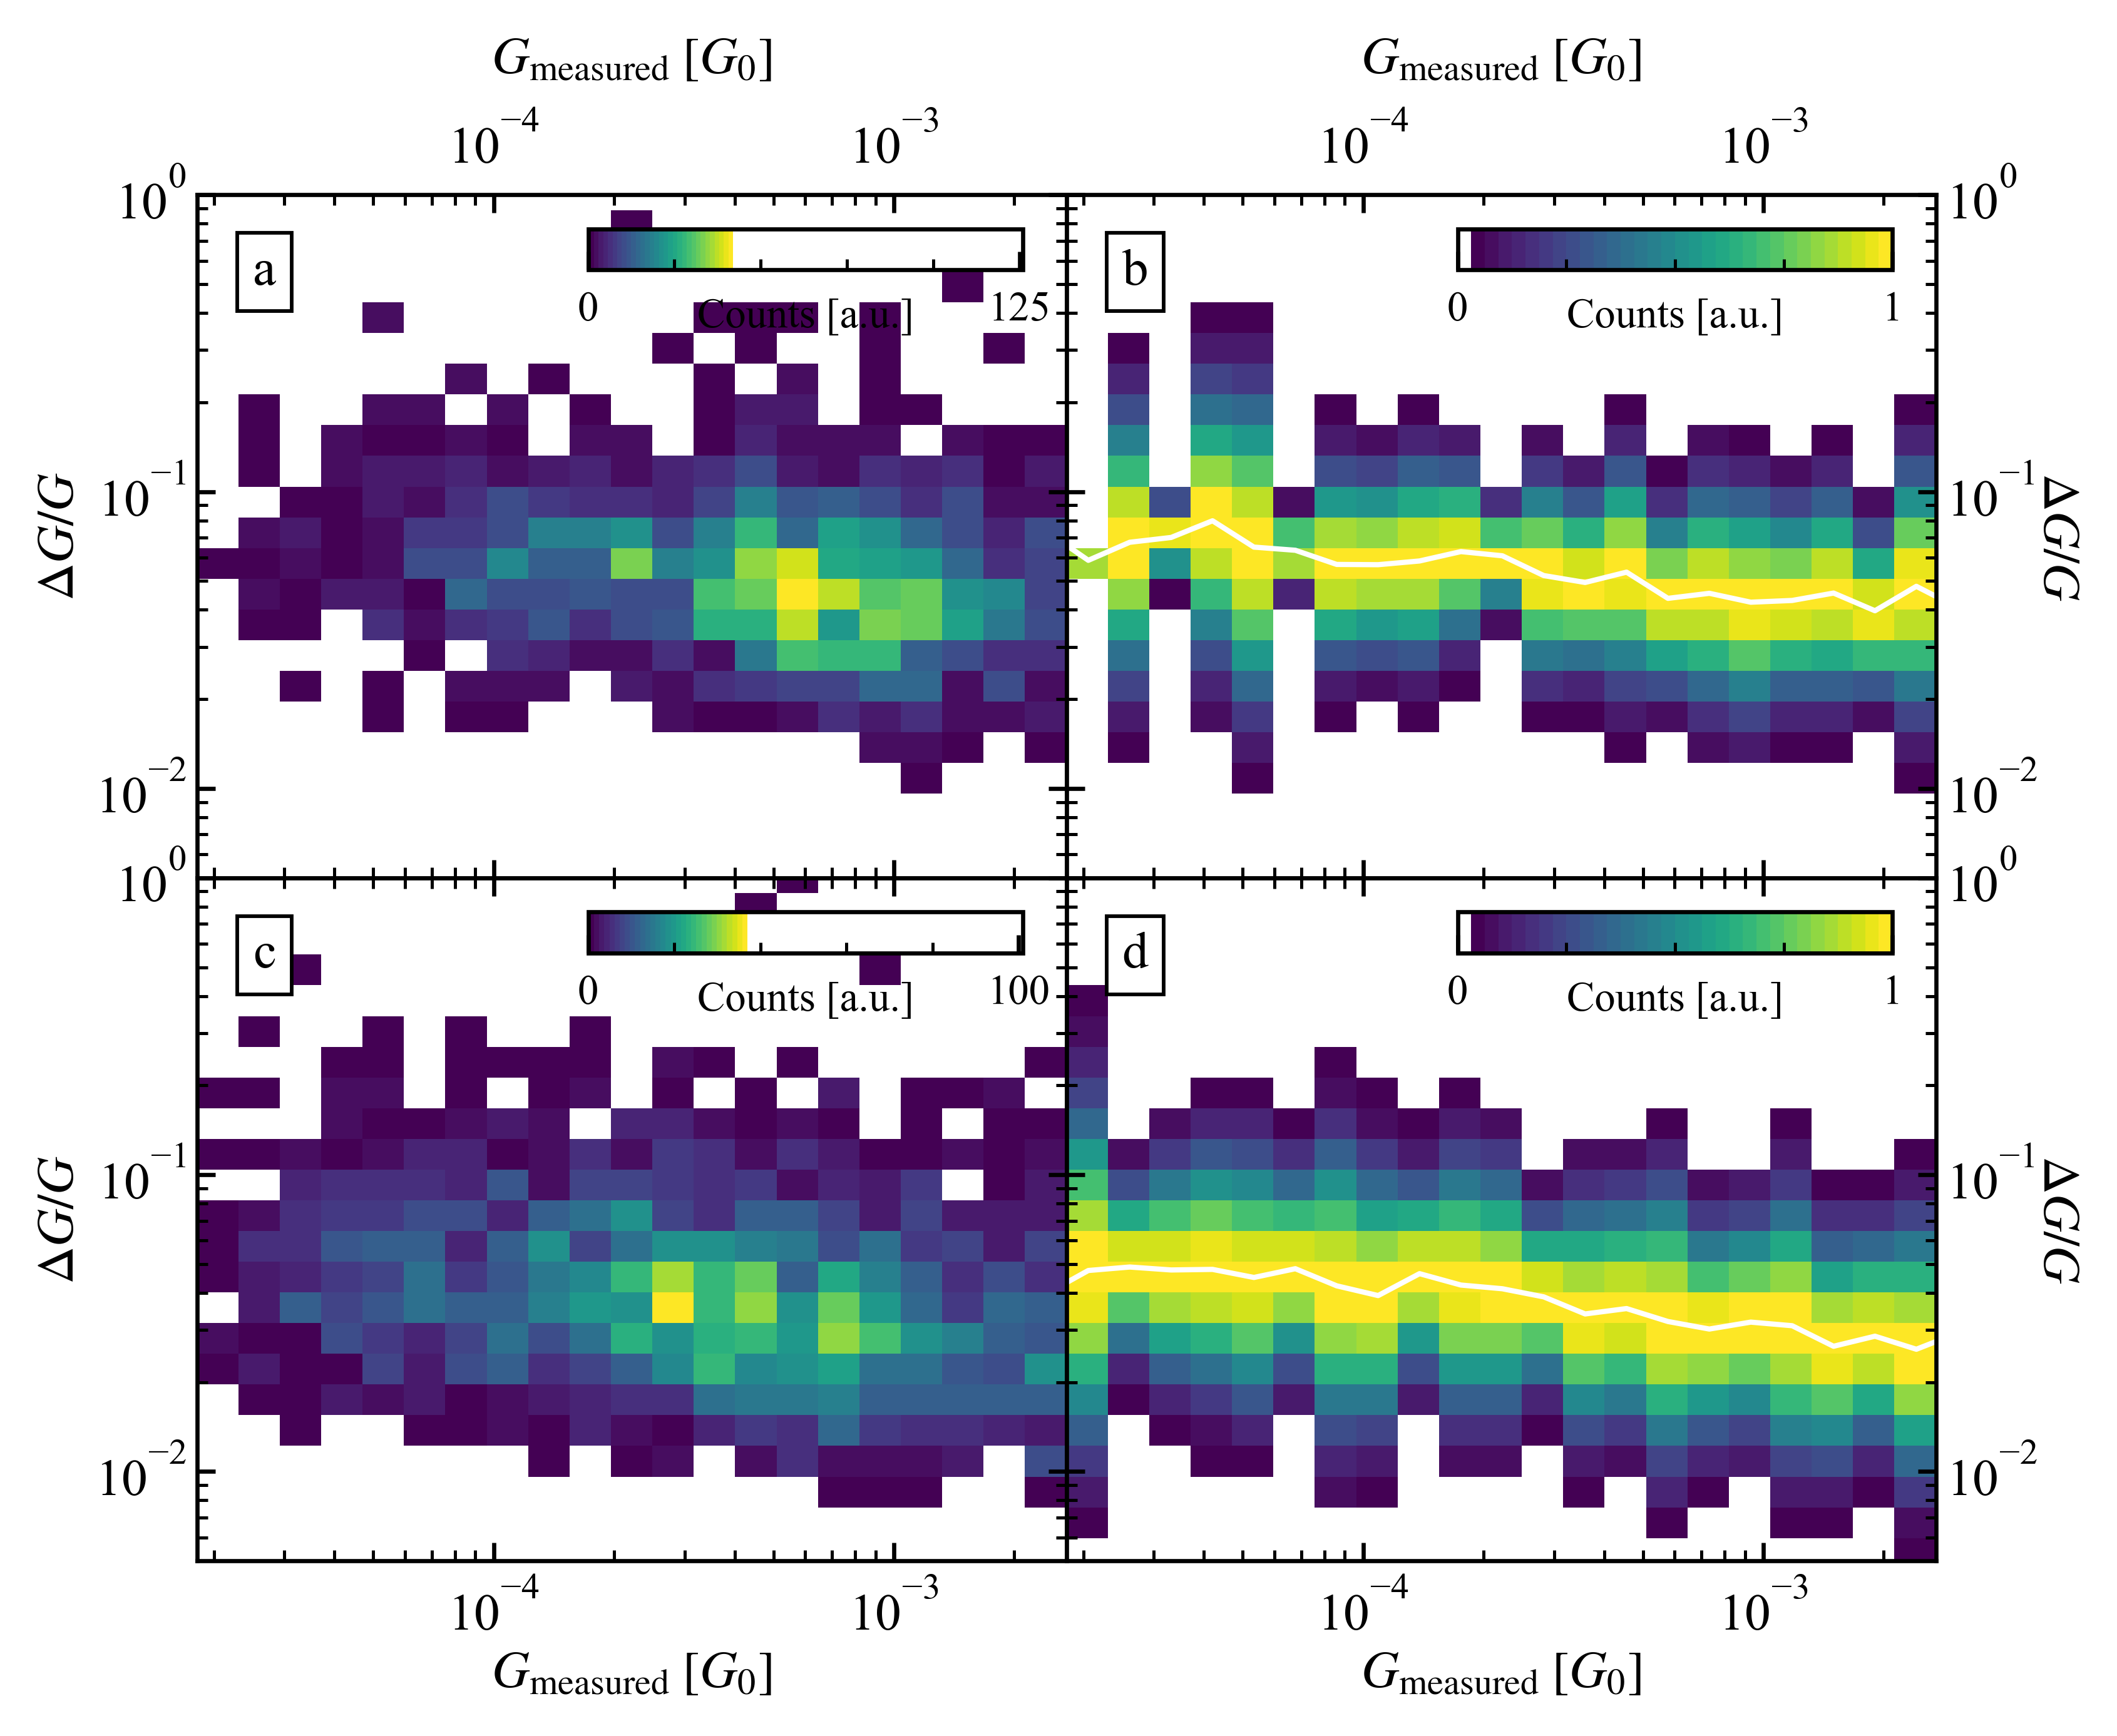

In [98]:
# fig, ax = plt.subplots(2, 2, figsize=utils.cm2inch(10, 10), dpi=200)

fig = plt.figure(figsize=utils.cm2inch(14, 12), dpi=600)

gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = np.array([[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)])

letters = ['a', 'b', 'c', 'd']
cbar_axs = []

for i in range(2):
    for j in range(2):
        ax[i, j].set_xscale('log')
        ax[i, j].set_yscale('log')
        
        ax[i, j].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i, j].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i, j].xaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i, j].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i, j].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i, j].yaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i, j].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
        ax[i, j].set_ylim(5e-3, 1)
        ax[i, j].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                             labelleft=not(j%2), labelright=j%2, labeltop=not(i%2), labelbottom=i%2)
        # ax[i, j].axvline(1.28e-5, ls='--', lw=0.4)
        ax[i, j].set_ylabel(r'$\Delta G / G$')
        ax[1, j].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$')
        ax[0, j].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', labelpad=8)
        ax[0, j].xaxis.set_label_position('top')
        cbar_axs.append(ax[i, j].inset_axes([0.45, 0.89, 0.5, 0.06]))
        
        ax[i, j].text(x=2.5e-5, y=5e-1, s=letters[i*2+j], bbox=bbox_props)
        
    ax[i, j].yaxis.set_label_position('right')
    
    ax[i, j].set_ylabel(r'$\Delta G / G$', rotation=270, labelpad=8)
    
im1 = ax[0, 0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_pull_1, cmap=my_cmap_blues, vmin=-1)
fig.colorbar(im1, cax=cbar_axs[0], orientation='horizontal')
cbar_axs[0].set_xticks(np.arange(0, 126, 125), minor=False)
cbar_axs[0].set_xticks(np.arange(0, 126, 25), minor=True)
cbar_axs[0].set_xlim(0, 126)
cbar_axs[0].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[0].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)

im1_norm = ax[0, 1].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d_gauss_norm_meas_pull_1, cmap=my_cmap_blues)
fig.colorbar(im1_norm, cax=cbar_axs[1], orientation='horizontal')
ax[0, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_1, lw=1, c='w')
cbar_axs[1].set_xticks(np.arange(0, 1.1, 1), minor=False)
cbar_axs[1].set_xticks(np.arange(0, 1.1, 0.25), minor=True)
cbar_axs[1].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[1].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)

im2 = ax[1, 0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_pull_2, cmap=my_cmap_blues, vmin=-1)
fig.colorbar(im2, cax=cbar_axs[2], orientation='horizontal')
cbar_axs[2].set_xticks(np.arange(0, 101, 100), minor=False)
cbar_axs[2].set_xticks(np.arange(0, 101, 20), minor=True)
cbar_axs[2].set_xlim(0, 101)
cbar_axs[2].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[2].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)


im2_norm = ax[1, 1].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d_gauss_norm_meas_pull_2, cmap=my_cmap_blues)
fig.colorbar(im2_norm, cax=cbar_axs[3], orientation='horizontal')
ax[1, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_pull_2, lw=1, c='w')
cbar_axs[3].set_xticks(np.arange(0, 1.1, 1), minor=False)
cbar_axs[3].set_xticks(np.arange(0, 1.1, 0.25), minor=True)
cbar_axs[3].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[3].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)

plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/relative_noise_histograms_pull.png'), bbox_inches='tight')

### Push

In [52]:
meas_data_push['G_meas1 [G0]'].shape

(6181,)

In [112]:
x_mesh_meas, y_mesh_meas, meas_hist_2d_push_1 = calc_hist_2d_new(x=meas_data_push['G_meas1 [G0]'],
                                                                 y=meas_data_push['dG/G_meas1'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 30)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

x_mesh_meas, y_mesh_meas, meas_hist_2d_push_2 = calc_hist_2d_new(x=meas_data_push['G_meas2 [G0]'],
                                                                 y=meas_data_push['dG/G_meas2'],
                                                                 xbins=calc_bins(np.logspace(-5, -2, 30)),
                                                                 ybins=calc_bins(np.logspace(-3, 0, 30)))

In [113]:
# Gaussian fit to normalize 2D histograms
ymiddle_meas_push_1, gaussian_fit_mean_meas_push_1, gaussian_fit_mean_err_meas_push_1, hist_2d_gauss_meas_push_1, hist_2d_gauss_norm_meas_push_1 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_push_1)

ymiddle_meas_push_2, gaussian_fit_mean_meas_push_2, gaussian_fit_mean_err_meas_push_2, hist_2d_gauss_meas_push_2, hist_2d_gauss_norm_meas_push_2 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_push_2)

D:\mcbj_stmbj\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


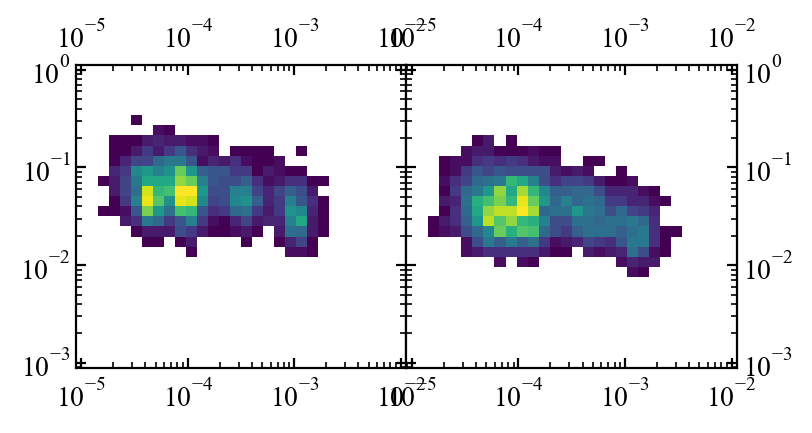

In [114]:
fig = plt.figure(figsize=utils.cm2inch(10, 5), dpi=200)

gs = plt.GridSpec(1, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = np.array([fig.add_subplot(gs[i]) for i in range(2)])

for i, hist_2d in enumerate((meas_hist_2d_push_1, meas_hist_2d_push_2)):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d, cmap=my_cmap_blues, vmin=0)
        
        ax[i].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i].xaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i].tick_params(which='both',
                          left=True, right=True, top=True, bottom=True,
                          labelleft=(i==0), labelright=(i==1), labeltop=True, labelbottom=True)

In [115]:
x_mesh_meas.shape

(31, 31)

Text(0.5, 0, 'Counts [a.u.]')

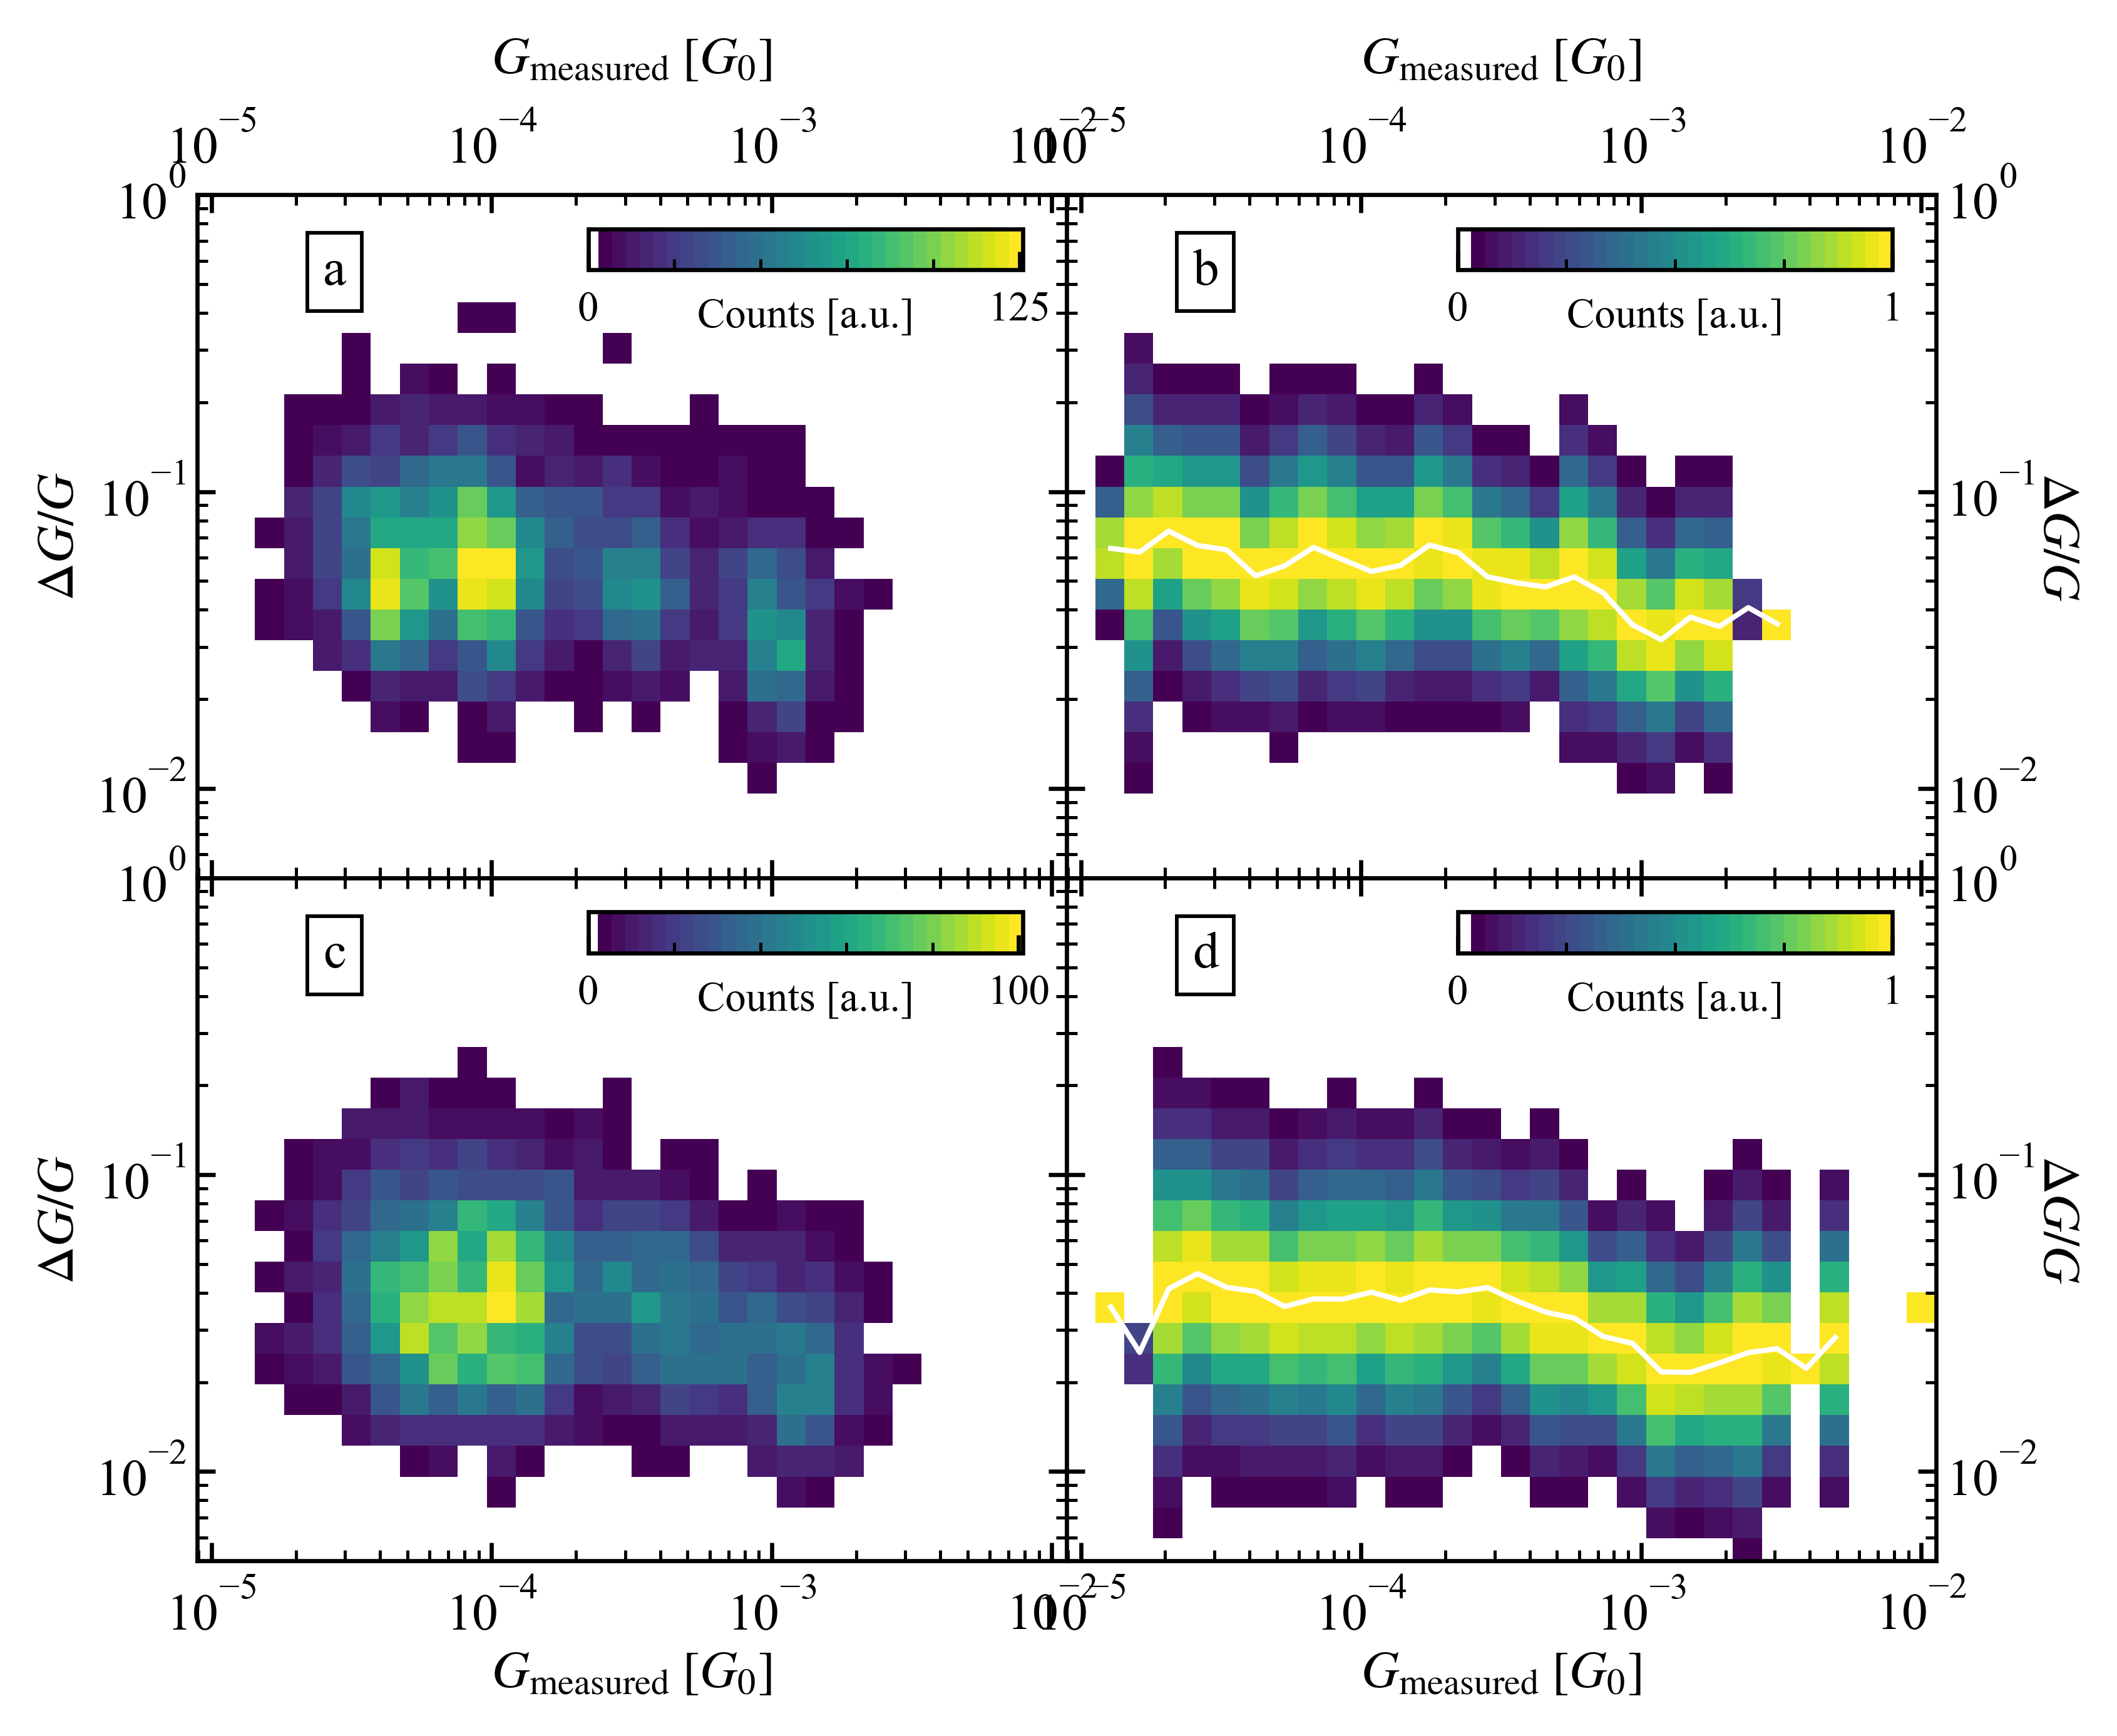

In [116]:
# fig, ax = plt.subplots(2, 2, figsize=utils.cm2inch(10, 10), dpi=200)

fig = plt.figure(figsize=utils.cm2inch(14, 12), dpi=600)

gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = np.array([[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)])

letters = ['a', 'b', 'c', 'd']
cbar_axs = []

for i in range(2):
    for j in range(2):
        ax[i, j].set_xscale('log')
        ax[i, j].set_yscale('log')
        
        ax[i, j].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i, j].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i, j].xaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i, j].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i, j].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i, j].yaxis.set_minor_formatter(ticker.NullFormatter())
        
        # ax[i, j].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
        ax[i, j].set_ylim(5e-3, 1)
        ax[i, j].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                             labelleft=not(j%2), labelright=j%2, labeltop=not(i%2), labelbottom=i%2)
        # ax[i, j].axvline(1.28e-5, ls='--', lw=0.4)
        ax[i, j].set_ylabel(r'$\Delta G / G$')
        ax[1, j].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$')
        ax[0, j].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', labelpad=8)
        ax[0, j].xaxis.set_label_position('top')
        cbar_axs.append(ax[i, j].inset_axes([0.45, 0.89, 0.5, 0.06]))
        
        ax[i, j].text(x=2.5e-5, y=5e-1, s=letters[i*2+j], bbox=bbox_props)
        
    ax[i, j].yaxis.set_label_position('right')
    
    ax[i, j].set_ylabel(r'$\Delta G / G$', rotation=270, labelpad=8)
    
im1 = ax[0, 0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_push_1, cmap=my_cmap_blues, vmin=-1)
fig.colorbar(im1, cax=cbar_axs[0], orientation='horizontal')
cbar_axs[0].set_xticks(np.arange(0, 126, 125), minor=False)
cbar_axs[0].set_xticks(np.arange(0, 126, 25), minor=True)
cbar_axs[0].set_xlim(0, 126)
cbar_axs[0].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[0].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)

im1_norm = ax[0, 1].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d_gauss_norm_meas_push_1, cmap=my_cmap_blues)
fig.colorbar(im1_norm, cax=cbar_axs[1], orientation='horizontal')
ax[0, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='w')
cbar_axs[1].set_xticks(np.arange(0, 1.1, 1), minor=False)
cbar_axs[1].set_xticks(np.arange(0, 1.1, 0.25), minor=True)
cbar_axs[1].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[1].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)

im2 = ax[1, 0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_push_2, cmap=my_cmap_blues, vmin=-1)
fig.colorbar(im2, cax=cbar_axs[2], orientation='horizontal')
cbar_axs[2].set_xticks(np.arange(0, 101, 100), minor=False)
cbar_axs[2].set_xticks(np.arange(0, 101, 20), minor=True)
cbar_axs[2].set_xlim(0, 101)
cbar_axs[2].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[2].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)


im2_norm = ax[1, 1].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d_gauss_norm_meas_push_2, cmap=my_cmap_blues)
fig.colorbar(im2_norm, cax=cbar_axs[3], orientation='horizontal')
ax[1, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='w')
cbar_axs[3].set_xticks(np.arange(0, 1.1, 1), minor=False)
cbar_axs[3].set_xticks(np.arange(0, 1.1, 0.25), minor=True)
cbar_axs[3].tick_params(axis='both', which='major', labelsize=8)
cbar_axs[3].set_xlabel('Counts [a.u.]', fontsize=8, labelpad=-6)

# plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/relative_noise_histograms_push.png'), bbox_inches='tight')

## Gaussian fit to simulated histograms and calculate the square difference to measurment data

### Pull

In [117]:
# which_z = 20
# which_phi = 2

sq_diff_all_pull_1 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
sq_diff_all_pull_2 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))

for which_z in tqdm(range(dFluct.shape[0])):
    for which_phi in range(PhiFluct.shape[0]):
        ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_pull[which_z, which_phi])
        
        # compare with plateau 1
        not_any_nan_1 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:22]), np.isnan(gaussian_fit_mean_meas_pull_1[1:22])))
        sq_diff_1 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_pull_1[1:22][not_any_nan_1], y2=10**gaussian_fit_mean[1:22][not_any_nan_1], log_scale=True)
        
        sq_diff_all_pull_1[which_z, which_phi] = sq_diff_1
        
        # compare with plateau 2
        not_any_nan_2 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:22]), np.isnan(gaussian_fit_mean_meas_pull_2[1:22])))
        sq_diff_2 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_pull_2[1:22][not_any_nan_2], y2=10**gaussian_fit_mean[1:22][not_any_nan_2], log_scale=True)
        
        sq_diff_all_pull_2[which_z, which_phi] = sq_diff_2

  0%|          | 0/151 [00:00<?, ?it/s]

D:\mcbj_stmbj\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Admin\AppData\Local\Temp\ipykernel_7160\1110183324.py:32: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
C:\Users\Admin\AppData\Local\Temp\ipykernel_7160\1110183324.py:44: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


### Push

In [118]:
# which_z = 20
# which_phi = 2

sq_diff_all_push_1 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
sq_diff_all_push_2 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))

for which_z in tqdm(range(dFluct.shape[0])):
    for which_phi in range(PhiFluct.shape[0]):
        ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[which_z, which_phi])
        
        # compare with plateau 1
        not_any_nan_1 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:22]), np.isnan(gaussian_fit_mean_meas_push_1[1:22])))
        sq_diff_1 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_push_1[1:22][not_any_nan_1], y2=10**gaussian_fit_mean[1:22][not_any_nan_1], log_scale=True)
        
        sq_diff_all_push_1[which_z, which_phi] = sq_diff_1
        
        # compare with plateau 2
        not_any_nan_2 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:22]), np.isnan(gaussian_fit_mean_meas_push_2[1:22])))
        sq_diff_2 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_push_2[1:22][not_any_nan_2], y2=10**gaussian_fit_mean[1:22][not_any_nan_2], log_scale=True)
        
        sq_diff_all_push_2[which_z, which_phi] = sq_diff_2

  0%|          | 0/151 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Temp\ipykernel_7160\1110183324.py:44: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
C:\Users\Admin\AppData\Local\Temp\ipykernel_7160\1110183324.py:32: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


In [92]:
print(dFluct[14])
print(PhiFluct[19])

0.0014
0.02


In [80]:
sim_hist_2d_all_push = []

ex_dFluct = [0, 0.0014]
ex_PhiFluct = [0, 0.02]

for i, dz in enumerate(tqdm(ex_dFluct)):
    for j, dP in enumerate(ex_PhiFluct):
        relative_noise = calc_noise_sim(sim_data_df=sim_data_push, dgap=dz, dphi=dP)
        
        x_mesh, y_mesh, sim_hist_2d = calc_hist_2d_new(x=sim_data_push['G [G0]'],
                                                       y=relative_noise,
                                                       xbins=calc_bins(np.logspace(-5, -2, 30)), # 30
                                                       ybins=calc_bins(np.logspace(-3, 0, 30))) # 60
        
        sim_hist_2d_all_push.append(sim_hist_2d)
        
sim_hist_2d_all_push = np.array(sim_hist_2d_all_push)
x_num, y_num = sim_hist_2d_all_push.shape[1:]

print(sim_hist_2d_all_push.reshape((i+1, j+1, x_num, y_num)).shape)

sim_hist_2d_all_push = sim_hist_2d_all_push.reshape((i+1, j+1, x_num, y_num))
print(sim_hist_2d_all_push.shape)

  0%|          | 0/2 [00:00<?, ?it/s]

(2, 2, 60, 30)
(2, 2, 60, 30)


(0.01, 0.2)


[Text(3e-05, 0.11, 'a'), Text(3e-05, 0.11, 'b'), Text(3e-05, 0.11, 'c')]

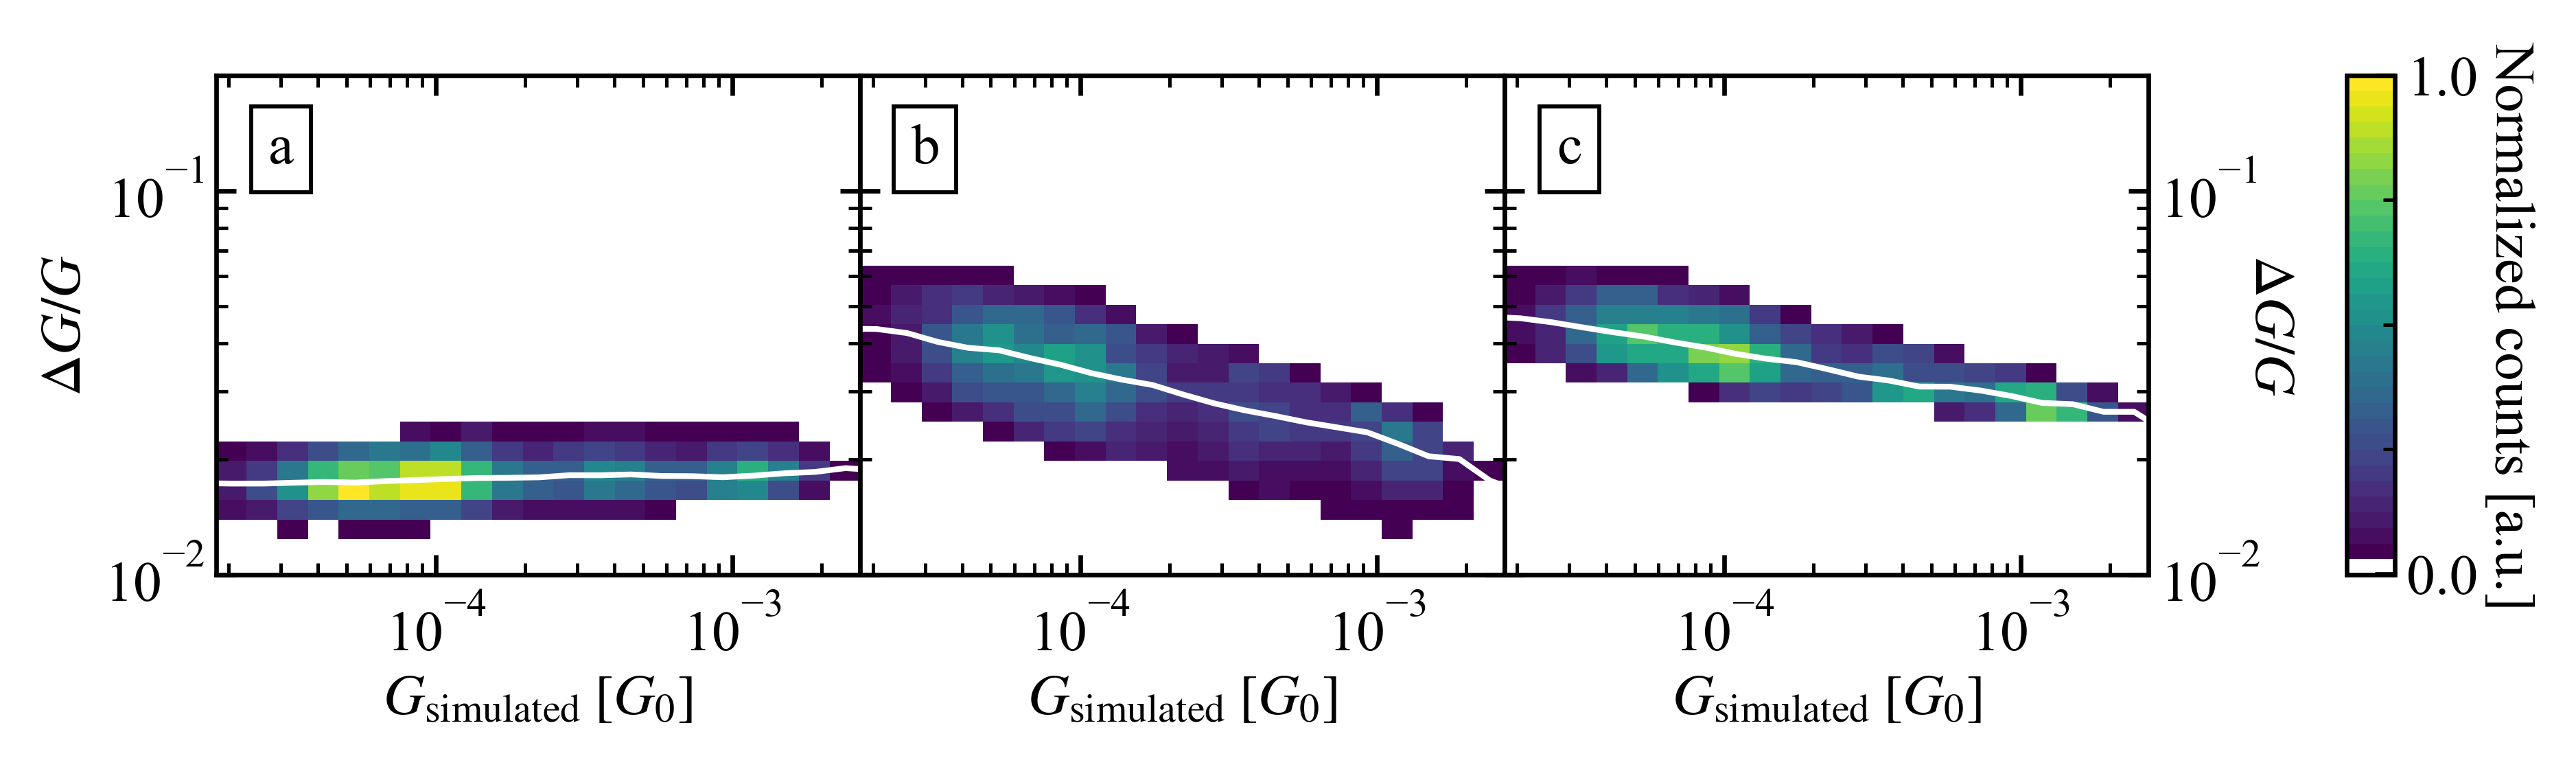

In [81]:
fig = plt.figure(figsize=utils.cm2inch(16, 4), dpi=600)

gs_total = plt.GridSpec(1, 2, figure=fig, width_ratios=(40, 1),
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.2)
gs_top = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, width_ratios=(1, 2),
                                              subplot_spec=gs_total[0],
                                              wspace=0.2, hspace=0)
gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_total[0], width_ratios=(1, 1, 1),
                                      # left=0.08, right=0.92, top=0.9, bottom=0.13,
                                      hspace=0.0, wspace=0.0)

axs = [fig.add_subplot(gs[i]) for i in range(3)]

ax_cbar = fig.add_subplot(gs_total[-1])

for i in range(3):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-2, 2e-1)
    
# which_d = 14 #12 # 25
# which_phi = 19

which_d = 1
which_phi = 1

ymiddle_1, gaussian_fit_mean_1, gaussian_fit_mean_err_1, hist_2d_gauss_1, hist_2d_gauss_norm_1 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[which_d, 0])

ymiddle_2, gaussian_fit_mean_2, gaussian_fit_mean_err_2, hist_2d_gauss_2, hist_2d_gauss_norm_2 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[0, which_phi])

ymiddle_3, gaussian_fit_mean_3, gaussian_fit_mean_err_3, hist_2d_gauss_3, hist_2d_gauss_norm_3 = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all_push[which_d, which_phi])

# cbar_axs = []
# cbar_axs.append(axs[0].inset_axes([0.45, 0.89, 0.5, 0.06]))
# cbar_axs.append(axs[1].inset_axes([0.45, 0.89, 0.5, 0.06]))
# cbar_axs.append(axs[2].inset_axes([0.45, 0.89, 0.5, 0.06]))


# axs[0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_push_1, cmap=my_cmap_blues, vmin=-1)
# axs[0].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_1, cmap=my_cmap_blues)
im1 = axs[0].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_push[which_d, 0], cmap=my_cmap_blues, vmin=-1, vmax=750)
axs[0].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_1, lw=1, c='w')

# fig.colorbar(im1, cax=cbar_axs[0], orientation='horizontal')

# axs[0].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='r')
# axs[0].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='b')
# axs[1].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_2, cmap=my_cmap_blues)
im2 = axs[1].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_push[0, which_phi], cmap=my_cmap_blues, vmin=-1, vmax=750)
axs[1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_2, lw=1, c='w')

# fig.colorbar(im2, cax=cbar_axs[1], orientation='horizontal')

# axs[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='r')
# axs[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='b')
# axs[2].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm_3, cmap=my_cmap_blues)
im3 = axs[2].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all_push[which_d, which_phi], cmap=my_cmap_blues, vmin=-1, vmax=750)
# fig.colorbar(im3, cax=cbar_axs[2], orientation='horizontal')
fig.colorbar(im3, cax=ax_cbar, orientation='vertical')

ax_cbar.set_yticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1), minor=False)
ax_cbar.set_yticks(np.linspace(0, 750, 5), minor=True)
# axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_1, lw=1, c='g')
# axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_2, lw=1, c='b')
axs[2].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_3, lw=1, c='w')

axs[0].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
axs[1].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])
axs[2].set_xlim(x_mesh_meas[0, 3], x_mesh_meas[0, 24])

# print(cbar_axs[2].get_xlim())
# cbar_axs[0].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))
# cbar_axs[1].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))
# cbar_axs[2].set_xticks(np.arange(0, 751, 750), labels=np.arange(0, 1.1, 1))


# axs[2].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_1, lw=1, c='r')
# axs[2].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_push_2, lw=1, c='b')

# axs[0].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[which_d], 4)}' + r'\;\mathrm{nm}$')
# axs[0].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[0], 4)}' + r'\;\mathrm{eV}$')

# axs[1].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[0], 4)}' + r'\;\mathrm{nm}$')
# axs[1].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[which_phi], 4)}' + r'\;\mathrm{eV}$')

# axs[2].text(x=2e-5, y=2e-1, s=r'$\Delta d =' + f'{np.round(ex_dFluct[which_d], 4)}' + r'\;\mathrm{nm}$')
# axs[2].text(x=2e-5, y=1e-1, s=r'$\Delta \phi =' + f'{np.round(ex_PhiFluct[which_phi], 4)}' + r'\;\mathrm{eV}$')

axs[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axs[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)
axs[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

axs[0].set_ylabel(r'$\Delta G / G$')
axs[-1].set_ylabel(r'$\Delta G / G$', rotation=270, labelpad=6)
axs[-1].yaxis.set_label_position('right')
[axs[i].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$') for i in range(3)]

ax_cbar.yaxis.set_label_position('right')
ax_cbar.set_ylabel('Normalized counts [a.u.]', rotation=270, labelpad=10)

axs_xlims = axs[0].get_xlim()
print(axs[0].get_ylim())
middle_point = 10**((np.log10(axs_xlims[1])-np.log10(axs_xlims[0]))/2 + np.log10(axs_xlims[0]))

# axs[0].text(x=middle_point, y=0.21, s='gap fluctuation only', ha='center', va='bottom')
# axs[1].text(x=middle_point, y=0.21, s='barrier fluctuation only', ha='center', va='bottom')
# axs[2].text(x=middle_point, y=0.21, s='gap & barrier fluctuation', ha='center', va='bottom')

[axs[i].text(x=3e-5, y=0.11, s=letters[i], ha='center', va='bottom', bbox=bbox_props) for i in range(3)]


# plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/relative_noise_histograms_push_simulation.png'), bbox_inches='tight')

## Plot square difference

### Pull

0.15
0.5


(0.0, 0.06)

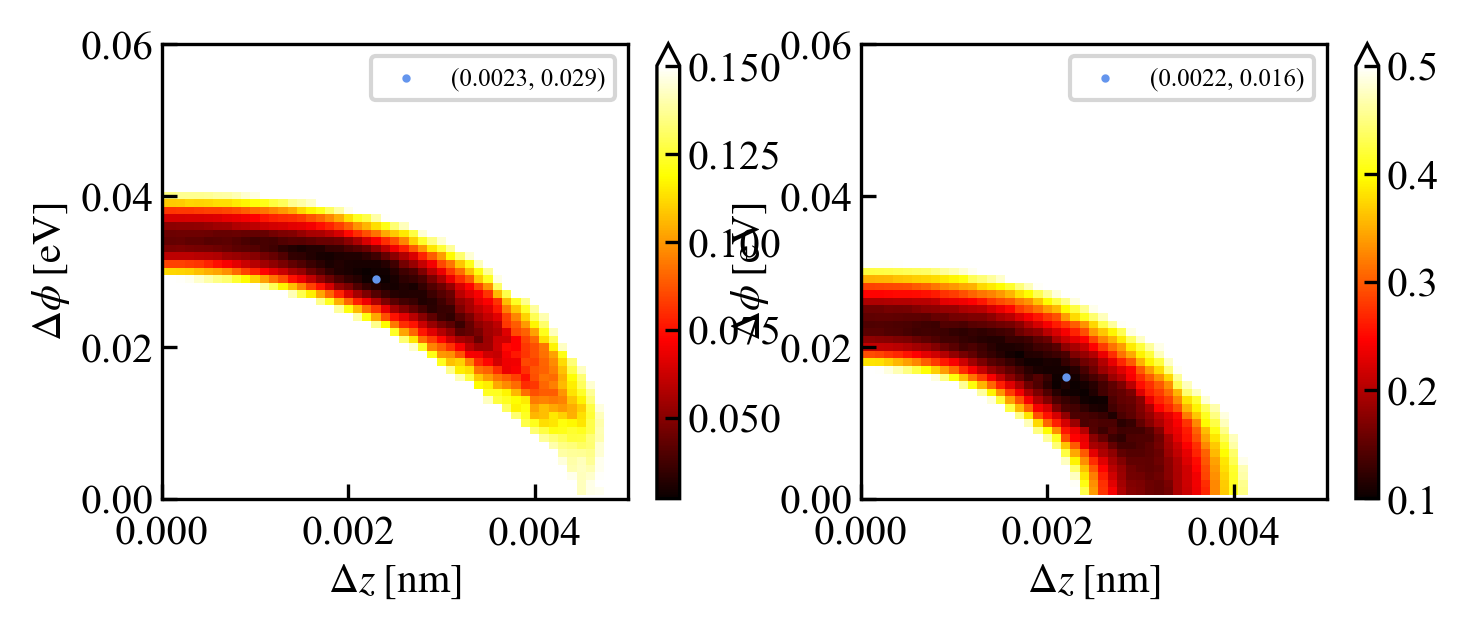

In [134]:
ax1, ax2 = plot_sq_diff_1(dFluct=dFluct, PhiFluct=PhiFluct,
                          sq_diff_all_1=sq_diff_all_pull_1,
                          sq_diff_all_2=sq_diff_all_pull_2,
                          plot_min=True, vmax=0.15, dot_color='cornflowerblue')

print(np.round(min(sq_diff_all_pull_1.flatten()), 2)*5)
print(np.round(min(sq_diff_all_pull_2.flatten()), 2)*5)

ax1.set_xlim(0, 0.005)
ax1.set_ylim(0, 0.06)
ax2.set_xlim(0, 0.005)
ax2.set_ylim(0, 0.06)

### Push

(151,)
(150, 151)
(150,)
(150, 151)


<a list of 0 text.Text objects>

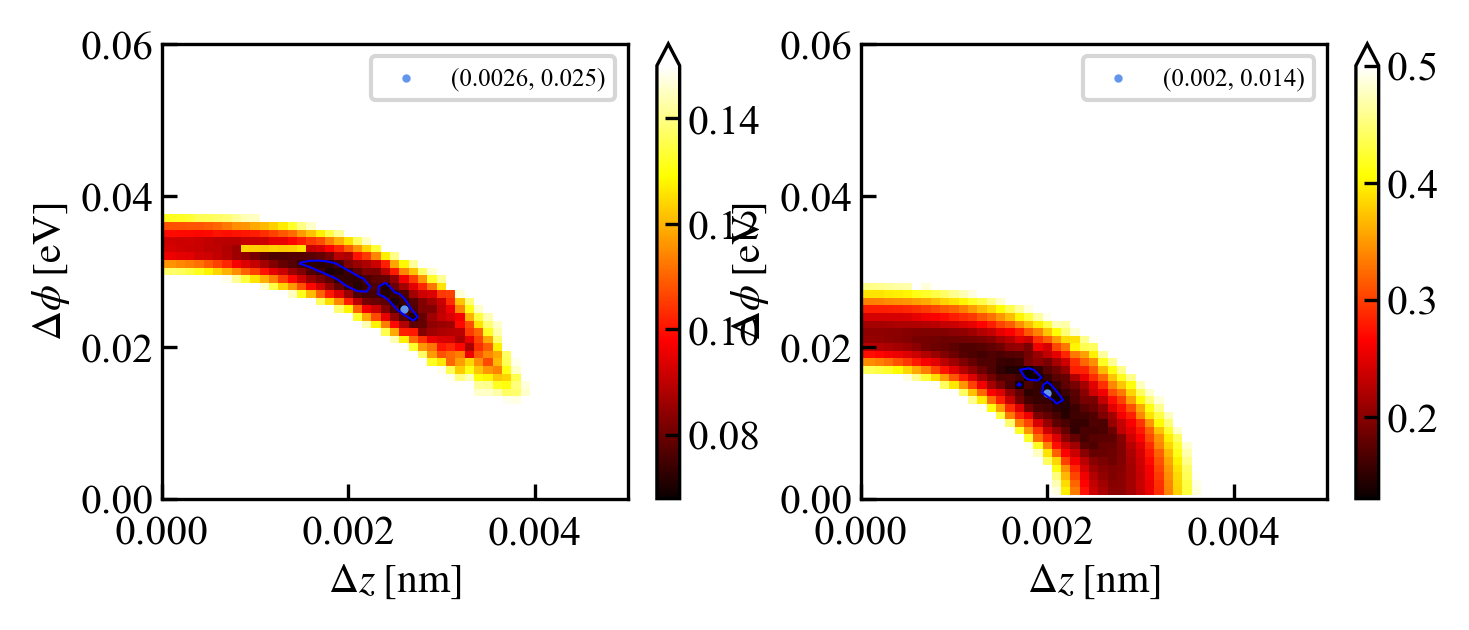

In [168]:
ax1, ax2 = plot_sq_diff_1(dFluct=dFluct, PhiFluct=PhiFluct,
                          sq_diff_all_1=sq_diff_all_push_1,
                          sq_diff_all_2=sq_diff_all_push_2,
                          plot_min=True, vmax=0.15,
                          dot_color='cornflowerblue')
ax1.set_xlim(0, 0.005)
ax1.set_ylim(0, 0.06)
ax2.set_xlim(0, 0.005)
ax2.set_ylim(0, 0.06)

x_mesh, y_mesh = np.meshgrid(dFluct, PhiFluct)

print(dFluct.shape)
print(x_mesh.shape)
print(PhiFluct.shape)
print(y_mesh.shape)
CS1 = ax1.contour(x_mesh, y_mesh, sq_diff_all_push_1.T, levels=[1.1*min(sq_diff_all_push_1.flatten())], colors='blue', linewidths=0.5)
ax1.clabel(CS1, fontsize=10)
CS2 = ax2.contour(x_mesh, y_mesh, sq_diff_all_push_2.T, levels=[1.1*min(sq_diff_all_push_2.flatten())], colors='blue', linewidths=0.5)
ax2.clabel(CS2, fontsize=10)
# ax1.set_title('Simplest default with labels')

In [68]:
print(sq_diff_all_push_1.flatten().min())
print(sq_diff_all_push_2.flatten().min())

0.01392125488865943
0.03337371537045508


In [69]:
sim_data_push['Phi - Barrier [eV]'].max()

1.99

4


Text(0.5, 0, 'Phi - Barrier [eV]')

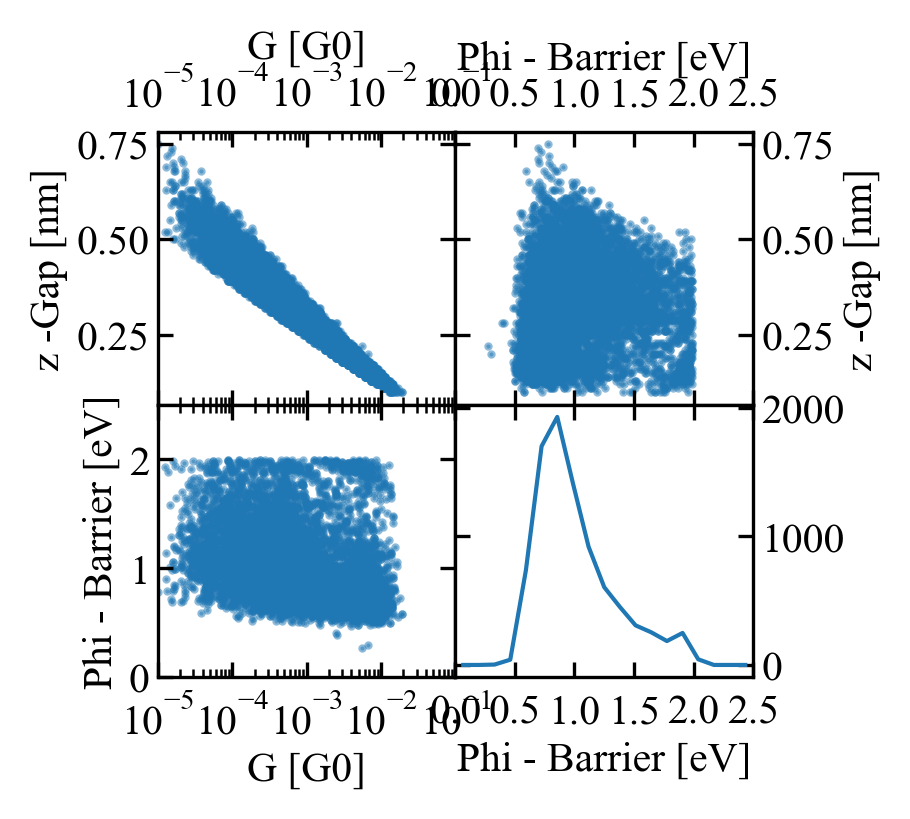

In [70]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].scatter(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)
ax[0].set_xlabel('G [G0]')
ax[0].set_xlim(1e-5, 1e-1)
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[2].scatter(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'], s=1, alpha=0.5)
ax[2].set_xlabel('G [G0]')
ax[2].set_xlim(1e-5, 1e-1)
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[1].scatter(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)
ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')
phi_bins, phi_hist1d = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                 xbins_num=20, log_scale=False, bin_mode='total')

ax[3].plot(phi_bins, phi_hist1d, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

4


Text(0.5, 0, 'Phi - Barrier [eV]')

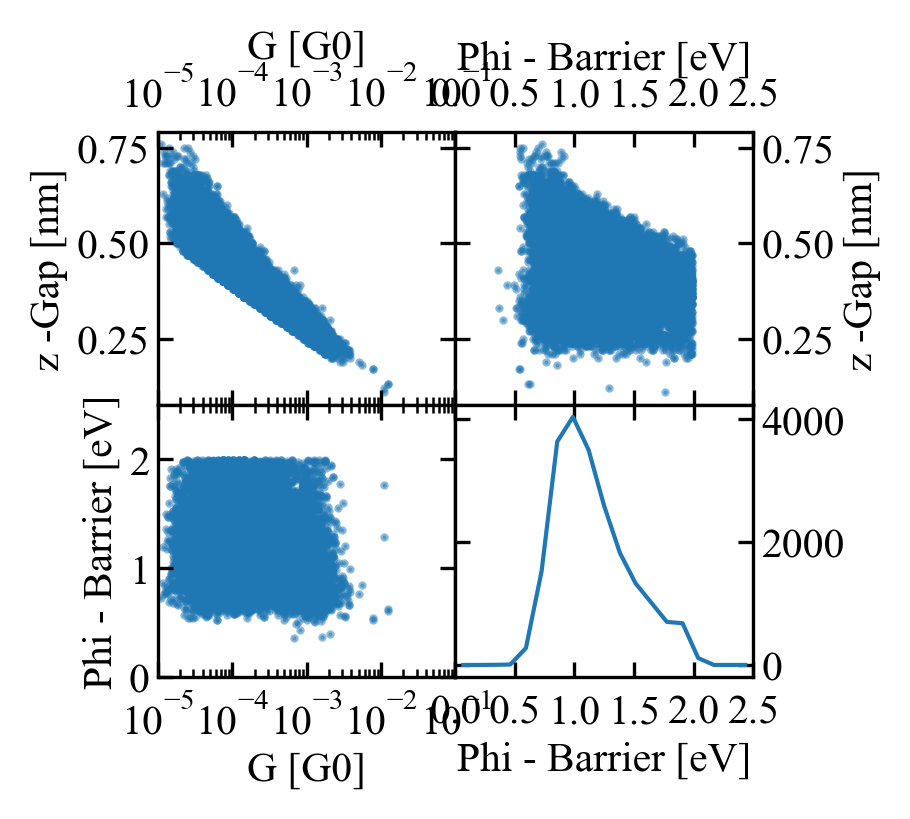

In [50]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].scatter(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)
ax[0].set_xlabel('G [G0]')
ax[0].set_xlim(1e-5, 1e-1)
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[2].scatter(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'], s=1, alpha=0.5)
ax[2].set_xlabel('G [G0]')
ax[2].set_xlim(1e-5, 1e-1)
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[1].scatter(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)
ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')
phi_bins, phi_hist1d = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                 xbins_num=20, log_scale=False, bin_mode='total')

ax[3].plot(phi_bins, phi_hist1d, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

4


Text(0.5, 0, '$\\phi$ [eV]')

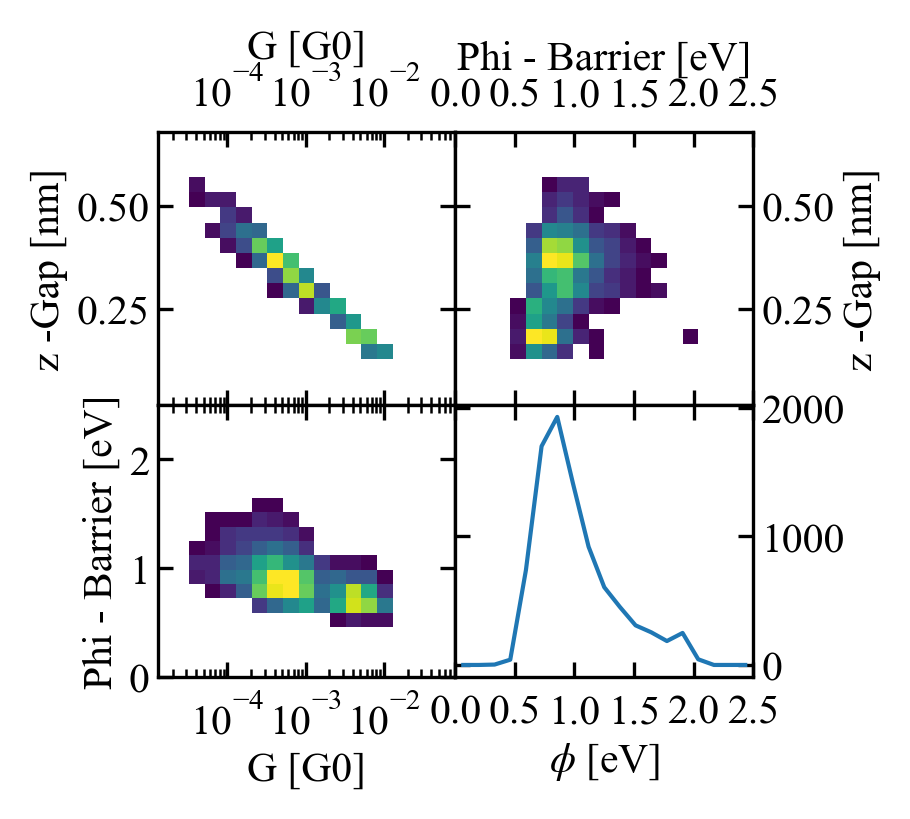

In [51]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

# ax[0].scatter(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)

bins_G, _ = utils.calc_hist_1d_single(data=sim_data_pull['G [G0]'], xrange=(1e-5, 1e-1),
                                      xbins_num=20, log_scale=True, bin_mode='total')
bins_z, _ = utils.calc_hist_1d_single(data=sim_data_pull['z -Gap [nm]'], xrange=(0, 0.7),
                                      xbins_num=20, log_scale=False, bin_mode='total')
bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                  xbins_num=20, log_scale=False, bin_mode='total')

h0, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'],
                                    bins=[bins_G, bins_z])
x_mesh0, y_mesh0 = np.meshgrid(xedges, yedges)
im0 = ax[0].pcolormesh(x_mesh0, y_mesh0, h0.T, cmap=my_cmap, vmin=h0.flatten().max()*0.1)

ax[0].set_xlabel('G [G0]')
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[2].scatter(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'], s=1, alpha=0.5)

h2, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
x_mesh2, y_mesh2 = np.meshgrid(xedges, yedges)
im2 = ax[2].pcolormesh(x_mesh2, y_mesh2, h2.T, cmap=my_cmap, vmin=h2.flatten().max()*0.1)

ax[2].set_xlabel('G [G0]')
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[1].scatter(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)

h1, xedges, yedges = np.histogram2d(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'],
                                    bins=[bins_Phi, bins_z])
x_mesh1, y_mesh1 = np.meshgrid(xedges, yedges)
im1 = ax[1].pcolormesh(x_mesh1, y_mesh1, h1.T, cmap=my_cmap, vmin=h1.flatten().max()*0.1)

ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')

# axin1 = ax[2].inset_axes([0.8, 0.1, 0.15, 0.5])
# fig.colorbar(im2, ax=ax[2], extend='max')

ax[3].plot(bins_Phi, hist_1d_Phi, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel(r'$\phi$ [eV]')

4


Text(0.5, 0, 'Phi - Barrier [eV]')

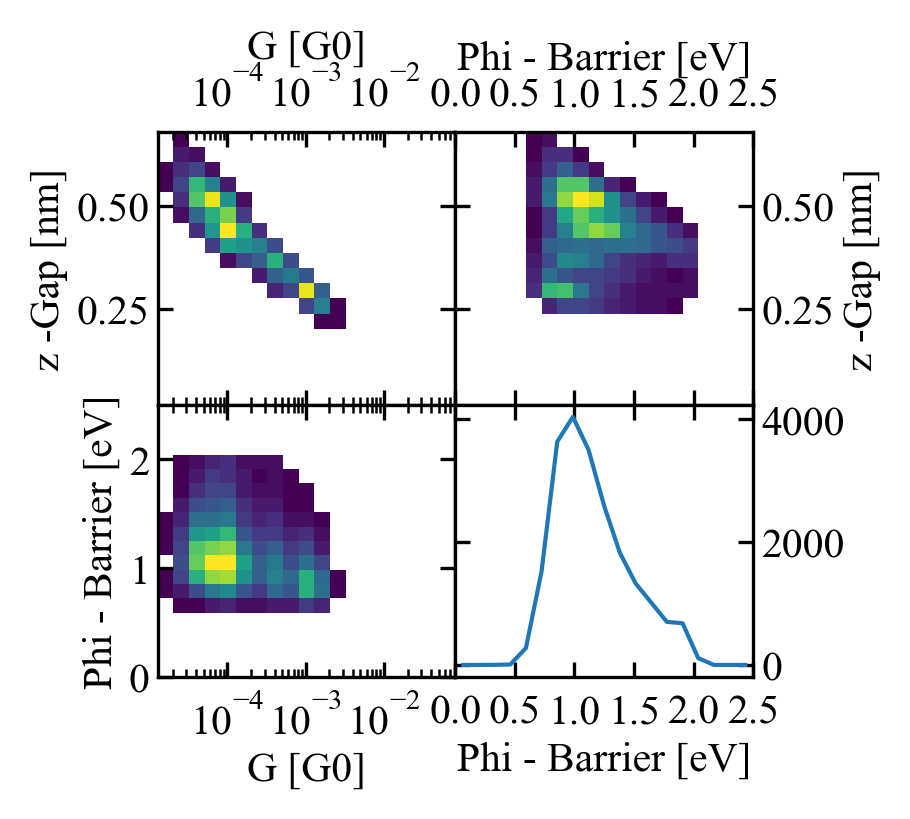

In [52]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

# ax[0].scatter(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)

bins_G, _ = utils.calc_hist_1d_single(data=sim_data_push['G [G0]'], xrange=(1e-5, 1e-1),
                                      xbins_num=20, log_scale=True, bin_mode='total')
bins_z, _ = utils.calc_hist_1d_single(data=sim_data_push['z -Gap [nm]'], xrange=(0, 0.7),
                                      xbins_num=20, log_scale=False, bin_mode='total')
bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                  xbins_num=20, log_scale=False, bin_mode='total')

h0, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'],
                                    bins=[bins_G, bins_z])
x_mesh0, y_mesh0 = np.meshgrid(xedges, yedges)
im0 = ax[0].pcolormesh(x_mesh0, y_mesh0, h0.T, cmap=my_cmap, vmin=-1)

ax[0].set_xlabel('G [G0]')
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[2].scatter(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'], s=1, alpha=0.5)

h2, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
x_mesh2, y_mesh2 = np.meshgrid(xedges, yedges)
im2 = ax[2].pcolormesh(x_mesh2, y_mesh2, h2.T, cmap=my_cmap, vmin=-1)

ax[2].set_xlabel('G [G0]')
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[1].scatter(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)

h1, xedges, yedges = np.histogram2d(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'],
                                    bins=[bins_Phi, bins_z])
x_mesh1, y_mesh1 = np.meshgrid(xedges, yedges)
im1 = ax[1].pcolormesh(x_mesh1, y_mesh1, h1.T, cmap=my_cmap, vmin=-1)

ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')

ax[3].plot(bins_Phi, hist_1d_Phi, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

In [53]:
sim_data_pull.head()

Trace                   Fit Trace     R [Ohm]  z -Gap [nm]  \
0     19522  '1_IV_trace_19522_pull_pl'  13069957.0         0.32   
639   19522  '2_IV_trace_19522_pull_pl'  12976073.0         0.33   
1278  19522  '3_IV_trace_19522_pull_pl'  17213803.0         0.27   
1917  19522  '4_IV_trace_19522_pull_pl'  20498335.0         0.36   
1     19811  '1_IV_trace_19811_pull_pl'   3730296.1         0.21   

      Phi - Barrier [eV]         dR/dz       dR/dPhi  G_meas1 [G0]  \
0                   0.77  1.563003e+17  1.099730e+26      0.002974   
639                 0.68  1.483611e+17  1.122828e+26      0.002974   
1278                1.76  2.784074e+17  8.233249e+25      0.002974   
1917                0.76  2.371568e+17  1.994190e+26      0.002974   
1                   0.92  5.156197e+16  1.692375e+25      0.005064   

      dG/G_meas1  G_meas2 [G0]  dG/G_meas2  Part    G [G0]  
0       0.085796      0.001155    0.143681     1  0.000987  
639     0.085796      0.001155    0.143681     2  0.000994  
1278    0.085796      0.001155    0.143681     3  0.000749  
1917    0.085796      0.001155    0.143681     4  0.000629  
1       0.107289      0.002731    0.043851     1  0.003458

Text(0, 0.5, 'Simulated G [G0]')

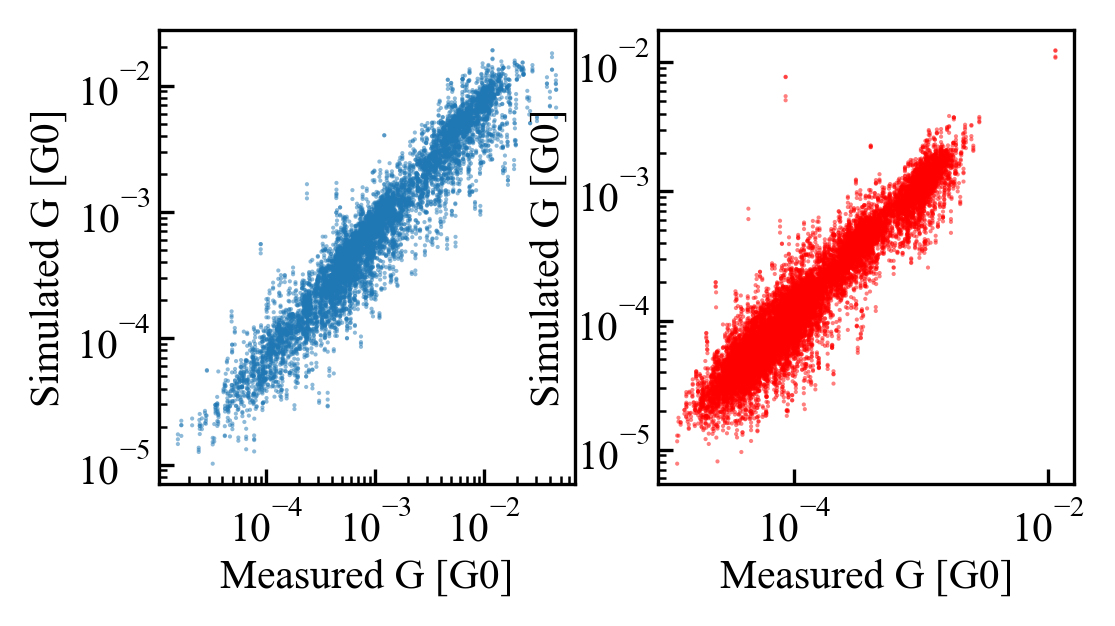

In [54]:
fig, ax = plt.subplots(1, 2, figsize=utils.cm2inch(10, 5), dpi=300)
ax[0].scatter(sim_data_pull['G_meas1 [G0]'], sim_data_pull['G [G0]'], s=1, alpha=0.5, edgecolor='None')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Measured G [G0]')
ax[0].set_ylabel('Simulated G [G0]')

ax[1].scatter(sim_data_push['G_meas1 [G0]'], sim_data_push['G [G0]'], s=1, alpha=0.5, edgecolor='None', c='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Measured G [G0]')
ax[1].set_ylabel('Simulated G [G0]')

## Plot
### ax1: gap 2D histogram + inset: sim vs measured conductance 2D histogram
### ax2: barrier 2D histogram + inset distribution of the barrier in a 2-3 bin wide slice

In [55]:
def calc_bins(middle: np.ndarray, log_scale=True):
    """
    Parameters
    ----------
    middle : np.ndarray
        location of the center of each bin for the histogram
    log_scale : bool
        if True, calculate bins on logarithmic scale
        

    Returns
    -------
    np.ndarray
        calculated bin edge locations

    Examples
    --------
    >>> calc_bins(middle=np.logspace(-5, -3, 2), log_scale=True)
    array([1.e-06, 1.e-04, 1.e-02])
    
    >>> calc_bins(middle=np.linspace(0, 2, 2), log_scale=False)
    array([-1.,  1.,  3.])
    
    >>> calc_bins(middle=np.linspace(0, 2, 5), log_scale=False)
    array([-0.25,  0.25,  0.75,  1.25,  1.75,  2.25])
    """
    
    if log_scale:
        bin_width = np.mean(np.diff(np.log10(middle)))
        return np.append(10**(np.log10(middle)-bin_width/2), 10**(np.log10(middle[-1])+bin_width/2))
    else:
        bin_width = np.mean(np.diff(middle))
        return np.append(middle-bin_width/2, middle[-1]+bin_width/2)

### pull

In [139]:
sim_data_pull.head()

Trace                   Fit Trace     R [Ohm]  z -Gap [nm]  \
0     19522  '1_IV_trace_19522_pull_pl'  13069957.0         0.32   
639   19522  '2_IV_trace_19522_pull_pl'  12976073.0         0.33   
1278  19522  '3_IV_trace_19522_pull_pl'  17213803.0         0.27   
1917  19522  '4_IV_trace_19522_pull_pl'  20498335.0         0.36   
1     19811  '1_IV_trace_19811_pull_pl'   3730296.1         0.21   

      Phi - Barrier [eV]         dR/dz       dR/dPhi  G_meas1 [G0]  \
0                   0.77  1.563003e+17  1.099730e+26      0.002974   
639                 0.68  1.483611e+17  1.122828e+26      0.002974   
1278                1.76  2.784074e+17  8.233249e+25      0.002974   
1917                0.76  2.371568e+17  1.994190e+26      0.002974   
1                   0.92  5.156197e+16  1.692375e+25      0.005064   

      dG/G_meas1  G_meas2 [G0]  dG/G_meas2  Part    G [G0]  
0       0.085796      0.001155    0.143681     1  0.000987  
639     0.085796      0.001155    0.143681     2  0.000994  
1278    0.085796      0.001155    0.143681     3  0.000749  
1917    0.085796      0.001155    0.143681     4  0.000629  
1       0.107289      0.002731    0.043851     1  0.003458

2
(1e-05, 0.5) (1e-05, 0.5)
(0.18, 0.7) (0.5, 2.1)


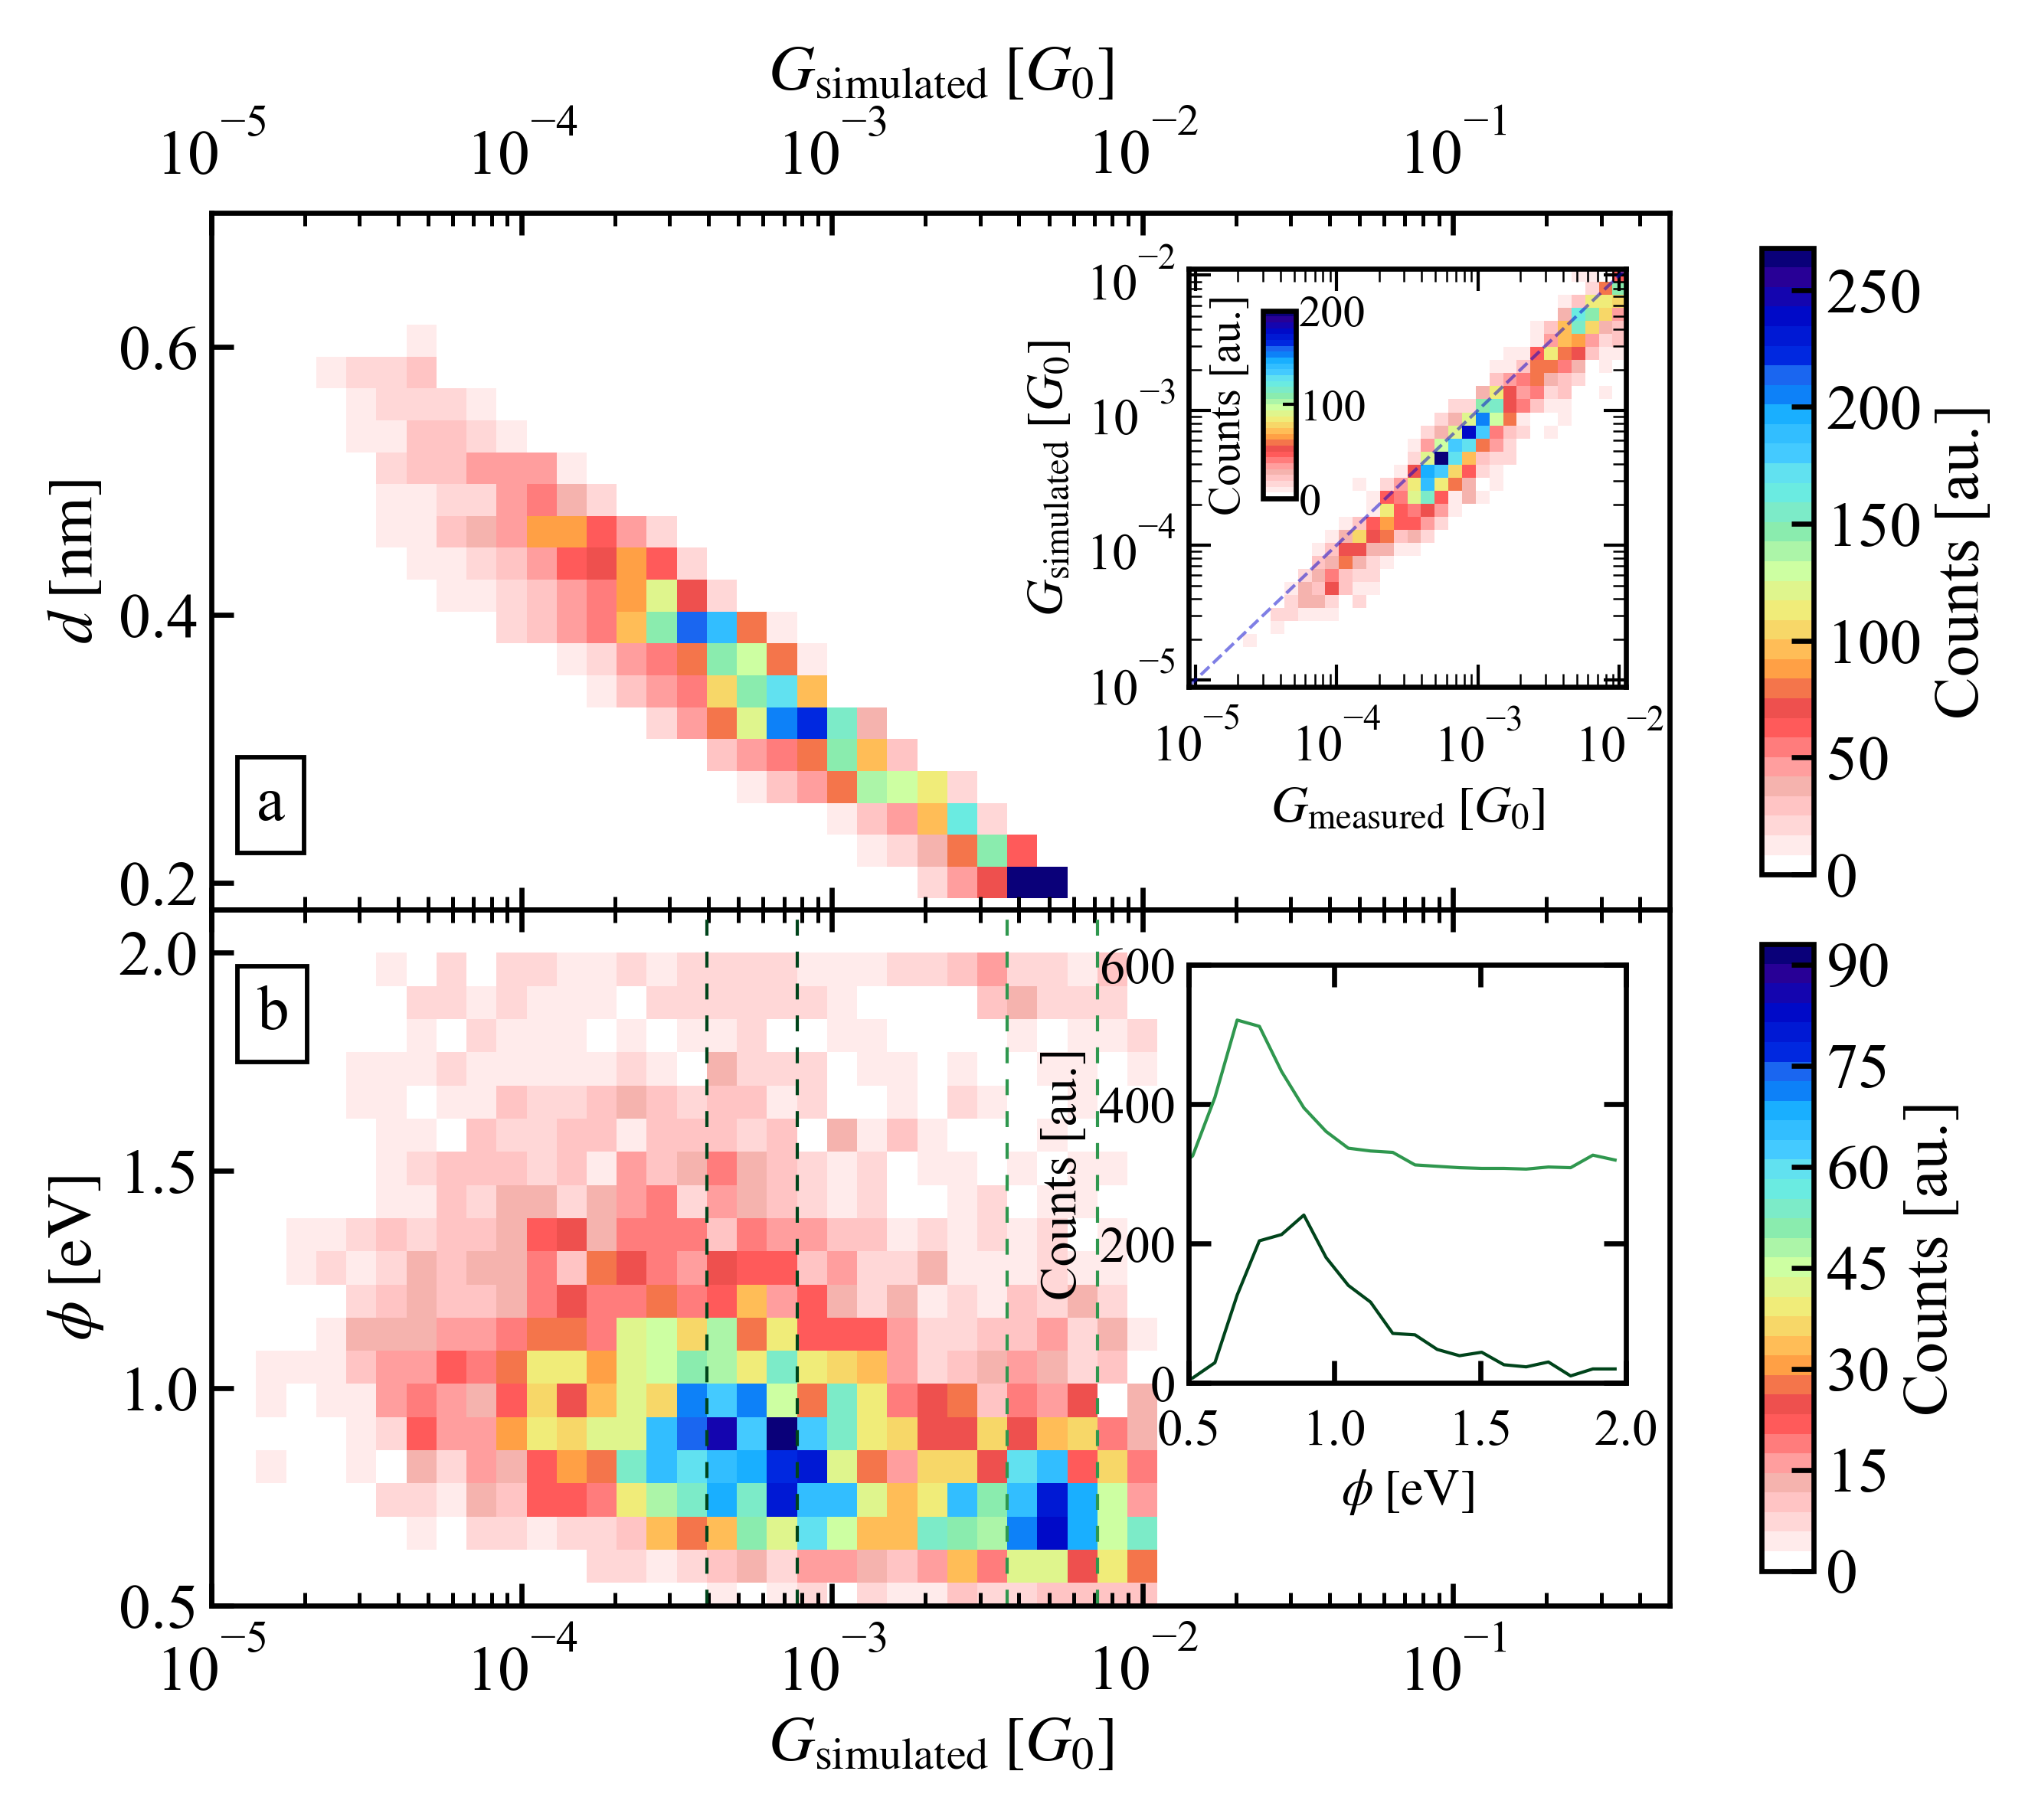

In [89]:
# bins_G, _ = utils.calc_hist_1d_single(data=sim_data_pull['G [G0]'], xrange=(1e-5, 1e-1),
#                                       xbins_num=20, log_scale=True, bin_mode='total')
# bins_z, _ = utils.calc_hist_1d_single(data=sim_data_pull['z -Gap [nm]'], xrange=(0, 0.7),
#                                       xbins_num=20, log_scale=False, bin_mode='total')
# bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
#                                                   xbins_num=20, log_scale=False, bin_mode='total')

figsize = utils.cm2inch((12, 10))
dpi = 600

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 1, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i]) for i in range(2)]
axin = [a.inset_axes([0.67, 0.32, 0.3, 0.6]) for a in ax]

axc_cond = axin[0].inset_axes([0.17, 0.45, 0.075, 0.45])

print(len(ax))

axin[0].tick_params(axis='both', labelsize=8)
axin[1].tick_params(axis='both', labelsize=8)

ax[0].set_xscale('log')
axin[0].set_xscale('log')
axin[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1e-5, 5e-1)
ax[1].set_xlim(1e-5, 5e-1)
ax[0].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)

middle_G = np.logspace(-5, -2, 32)
hist_1d_G, bins_G  = np.histogram(sim_data_pull['G [G0]'], bins=calc_bins(middle=middle_G, log_scale=True))

middle_z = np.linspace(0.2, 0.7, 22)

hist_1d_z, bins_z  = np.histogram(sim_data_pull['z -Gap [nm]'], bins=calc_bins(middle=middle_z, log_scale=False))



hist_1d_Phi, bins_Phi  = np.histogram(sim_data_pull['Phi - Barrier [eV]'], bins = np.linspace(0.4, 2., 22))
bar_width = np.diff(bins_Phi)
middle_Phi = bins_Phi[:-1] + bar_width / 2


gap_2D, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'],
                                        bins=[bins_G, bins_z])
gap_2D = gap_2D.T

x_mesh_gap, y_mesh_gap = np.meshgrid(xedges, yedges)
im_gap = ax[0].pcolormesh(x_mesh_gap, y_mesh_gap, gap_2D, cmap=utils.cmap_geo32, vmin=0)

barrier_2d, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'],
                                            bins=[bins_G, bins_Phi])
barrier_2d = barrier_2d.T

x_mesh_barrier, y_mesh_barrier = np.meshgrid(xedges, yedges)
im_barrier = ax[1].pcolormesh(x_mesh_barrier, y_mesh_barrier, barrier_2d, cmap=utils.cmap_geo32, vmin=0)

ax[1].set_ylim(0.5, 2.1)

cond_2D, xedges, yedges = np.histogram2d(sim_data_pull['G_meas1 [G0]'], sim_data_pull['G [G0]'],
                                         bins=[bins_G, bins_G])
x_mesh_cond, y_mesh_cond = np.meshgrid(xedges, yedges)
cond_2D = cond_2D.T

im_cond = axin[0].pcolormesh(x_mesh_cond, y_mesh_cond, cond_2D, cmap=utils.cmap_geo32, vmin=0, vmax=200)

# axin[1].plot(middle_Phi, hist_1d_Phi, lw=1)
axin[1].set_xlim(0.5, 2)

ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', labelpad=4)
ax[0].set_ylabel(r'$d\;[\mathrm{nm}]$', fontsize=10)

ax[1].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$')
ax[1].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

axin[0].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', fontsize=8)
axin[0].set_ylabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', fontsize=8)

axin[1].set_xlabel(r'$\phi\;[\mathrm{eV}]$', fontsize=8)
axin[1].set_ylabel(r'Counts [au.]', fontsize=8)

axin[0].plot(bins_G, bins_G, ls='--', lw=0.5, c='mediumblue', alpha=0.5)
axin[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].tick_params(axis='both', which='major', width=0.5)
axin[0].tick_params(axis='both', which='minor', width=0.3)

my_oranges = colormaps['Greens'](np.linspace(0.4, 1, 3))[::-1]

# ax[1].axvline(bins_G[7], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[17], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[20], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[16], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[27], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[30], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])

# axin[1].plot(middle_Phi, barrier_2d[:, 7:10].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 17:20].sum(axis=1), lw=0.5, c=my_oranges[0])
# axin[1].plot(middle_Phi, barrier_2d[:, 13:16].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 27:30].sum(axis=1)+300, lw=0.5, c=my_oranges[1])
axin[1].set_xticks([0.5, 1, 1.5, 2])

axin[1].set_ylim(0, 600)

fig.colorbar(im_gap, ax=ax[0], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 50, 100, 150, 200, 250])
fig.colorbar(im_barrier, ax=ax[1], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 15, 30, 45, 60, 75, 90])
fig.colorbar(im_cond, cax=axc_cond, shrink=0.9, aspect=12, orientation='vertical', ticks=[0, 100, 200])
axc_cond.tick_params(axis='y', labelsize=7, width=0.5, size=2,
                     top=False, bottom=False, left=False, right=True,
                     labeltop=False, labelbottom=False, labelleft=False, labelright=True, pad=0.5)
axc_cond.yaxis.set_label_position('left')
axc_cond.set_ylabel('Counts [au.]', fontsize=7)

ax[0].set_ylim(0.18, 0.7)

print(ax[0].get_xlim(), ax[1].get_xlim())
print(ax[0].get_ylim(), ax[1].get_ylim())

bbox_props = dict(boxstyle="square", lw=0.7, fc="w", ec="black", alpha=1)
ax[0].text(s='a', x=1.4e-5, y=0.15*(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])+ax[0].get_ylim()[0],
           bbox=bbox_props, va='center')
ax[1].text(s='b', x=1.4e-5, y=0.85*(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])+ax[1].get_ylim()[0],
           bbox=bbox_props, va='center')

plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/gap_barrier_conductance_distribution_pull_1.png'), bbox_inches='tight')

2
(1e-05, 0.5) (1e-05, 0.5)
(0.18, 0.7) (0.5, 2.1)


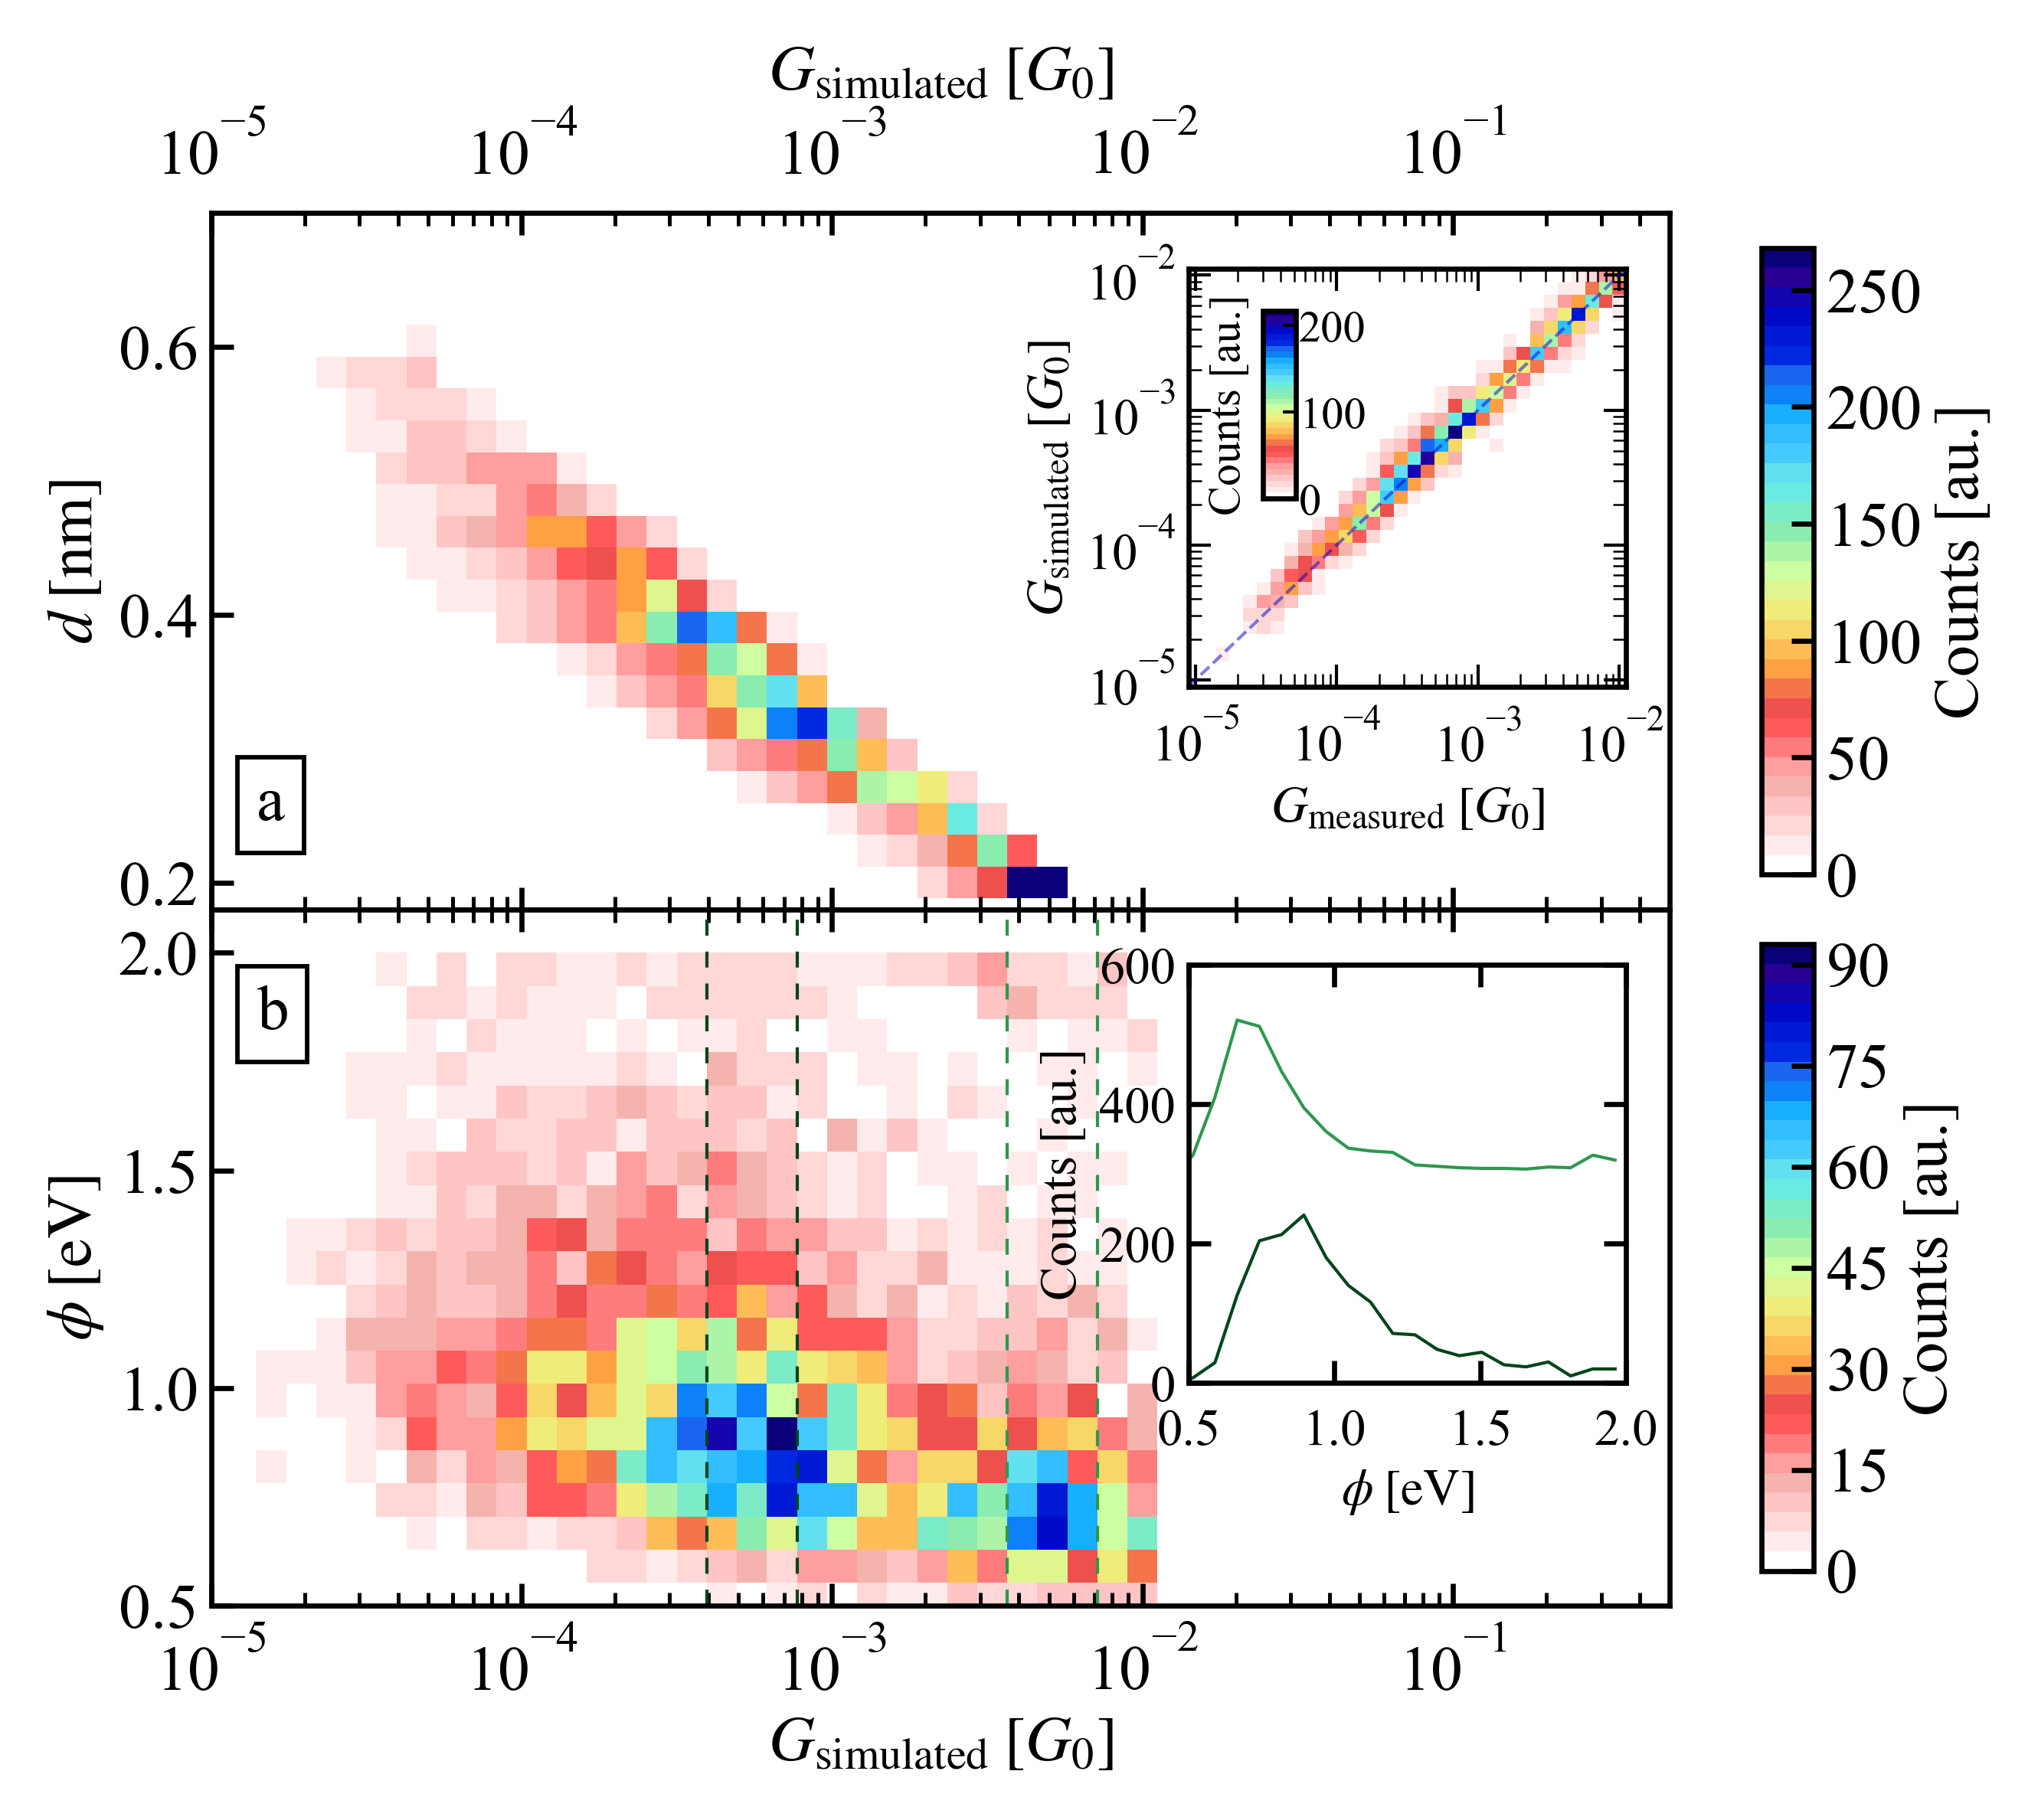

In [88]:
# bins_G, _ = utils.calc_hist_1d_single(data=sim_data_pull['G [G0]'], xrange=(1e-5, 1e-1),
#                                       xbins_num=20, log_scale=True, bin_mode='total')
# bins_z, _ = utils.calc_hist_1d_single(data=sim_data_pull['z -Gap [nm]'], xrange=(0, 0.7),
#                                       xbins_num=20, log_scale=False, bin_mode='total')
# bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
#                                                   xbins_num=20, log_scale=False, bin_mode='total')

figsize = utils.cm2inch((12, 10))
dpi = 600

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 1, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i]) for i in range(2)]
axin = [a.inset_axes([0.67, 0.32, 0.3, 0.6]) for a in ax]

axc_cond = axin[0].inset_axes([0.17, 0.45, 0.075, 0.45])

print(len(ax))

axin[0].tick_params(axis='both', labelsize=8)
axin[1].tick_params(axis='both', labelsize=8)

ax[0].set_xscale('log')
axin[0].set_xscale('log')
axin[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1e-5, 5e-1)
ax[1].set_xlim(1e-5, 5e-1)
ax[0].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)

middle_G = np.logspace(-5, -2, 32)
hist_1d_G, bins_G  = np.histogram(sim_data_pull['G [G0]'], bins=calc_bins(middle=middle_G, log_scale=True))

middle_z = np.linspace(0.2, 0.7, 22)

hist_1d_z, bins_z  = np.histogram(sim_data_pull['z -Gap [nm]'], bins=calc_bins(middle=middle_z, log_scale=False))



hist_1d_Phi, bins_Phi  = np.histogram(sim_data_pull['Phi - Barrier [eV]'], bins = np.linspace(0.4, 2., 22))
bar_width = np.diff(bins_Phi)
middle_Phi = bins_Phi[:-1] + bar_width / 2


gap_2D, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'],
                                        bins=[bins_G, bins_z])
gap_2D = gap_2D.T

x_mesh_gap, y_mesh_gap = np.meshgrid(xedges, yedges)
im_gap = ax[0].pcolormesh(x_mesh_gap, y_mesh_gap, gap_2D, cmap=utils.cmap_geo32, vmin=0)

barrier_2d, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'],
                                            bins=[bins_G, bins_Phi])
barrier_2d = barrier_2d.T

x_mesh_barrier, y_mesh_barrier = np.meshgrid(xedges, yedges)
im_barrier = ax[1].pcolormesh(x_mesh_barrier, y_mesh_barrier, barrier_2d, cmap=utils.cmap_geo32, vmin=0)

ax[1].set_ylim(0.5, 2.1)

cond_2D, xedges, yedges = np.histogram2d(sim_data_pull['G_meas2 [G0]'], sim_data_pull['G [G0]'],
                                         bins=[bins_G, bins_G])
x_mesh_cond, y_mesh_cond = np.meshgrid(xedges, yedges)
cond_2D = cond_2D.T

im_cond = axin[0].pcolormesh(x_mesh_cond, y_mesh_cond, cond_2D, cmap=utils.cmap_geo32, vmin=0)

# axin[1].plot(middle_Phi, hist_1d_Phi, lw=1)
axin[1].set_xlim(0.5, 2)

ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', labelpad=4)
ax[0].set_ylabel(r'$d\;[\mathrm{nm}]$', fontsize=10)

ax[1].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$')
ax[1].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

axin[0].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', fontsize=8)
axin[0].set_ylabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', fontsize=8)

axin[1].set_xlabel(r'$\phi\;[\mathrm{eV}]$', fontsize=8)
axin[1].set_ylabel(r'Counts [au.]', fontsize=8)

axin[0].plot(bins_G, bins_G, ls='--', lw=0.5, c='mediumblue', alpha=0.5)
axin[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].tick_params(axis='both', which='major', width=0.5)
axin[0].tick_params(axis='both', which='minor', width=0.3)

my_oranges = colormaps['Greens'](np.linspace(0.4, 1, 3))[::-1]

# ax[1].axvline(bins_G[7], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[17], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[20], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[16], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[27], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[30], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])

# axin[1].plot(middle_Phi, barrier_2d[:, 7:10].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 17:20].sum(axis=1), lw=0.5, c=my_oranges[0])
# axin[1].plot(middle_Phi, barrier_2d[:, 13:16].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 27:30].sum(axis=1)+300, lw=0.5, c=my_oranges[1])
axin[1].set_xticks([0.5, 1, 1.5, 2])

axin[1].set_ylim(0, 600)

fig.colorbar(im_gap, ax=ax[0], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 50, 100, 150, 200, 250])
fig.colorbar(im_barrier, ax=ax[1], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 15, 30, 45, 60, 75, 90]) #50, 100, 150, 200])
fig.colorbar(im_cond, cax=axc_cond, shrink=0.9, aspect=12, orientation='vertical', ticks=[0, 100, 200])
axc_cond.tick_params(axis='y', labelsize=7, width=0.5, size=2,
                     top=False, bottom=False, left=False, right=True,
                     labeltop=False, labelbottom=False, labelleft=False, labelright=True, pad=0.5)
axc_cond.yaxis.set_label_position('left')
axc_cond.set_ylabel('Counts [au.]', fontsize=7)

ax[0].set_ylim(0.18, 0.7)

print(ax[0].get_xlim(), ax[1].get_xlim())
print(ax[0].get_ylim(), ax[1].get_ylim())

bbox_props = dict(boxstyle="square", lw=0.7, fc="w", ec="black", alpha=1)
ax[0].text(s='a', x=1.4e-5, y=0.15*(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])+ax[0].get_ylim()[0],
           bbox=bbox_props, va='center')
ax[1].text(s='b', x=1.4e-5, y=0.85*(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])+ax[1].get_ylim()[0],
           bbox=bbox_props, va='center')

plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/gap_barrier_conductance_distribution_pull_2.png'), bbox_inches='tight')

### push

2
(1e-05, 0.1) (1e-05, 0.1)
(0.18, 0.7) (0.5, 2.1)


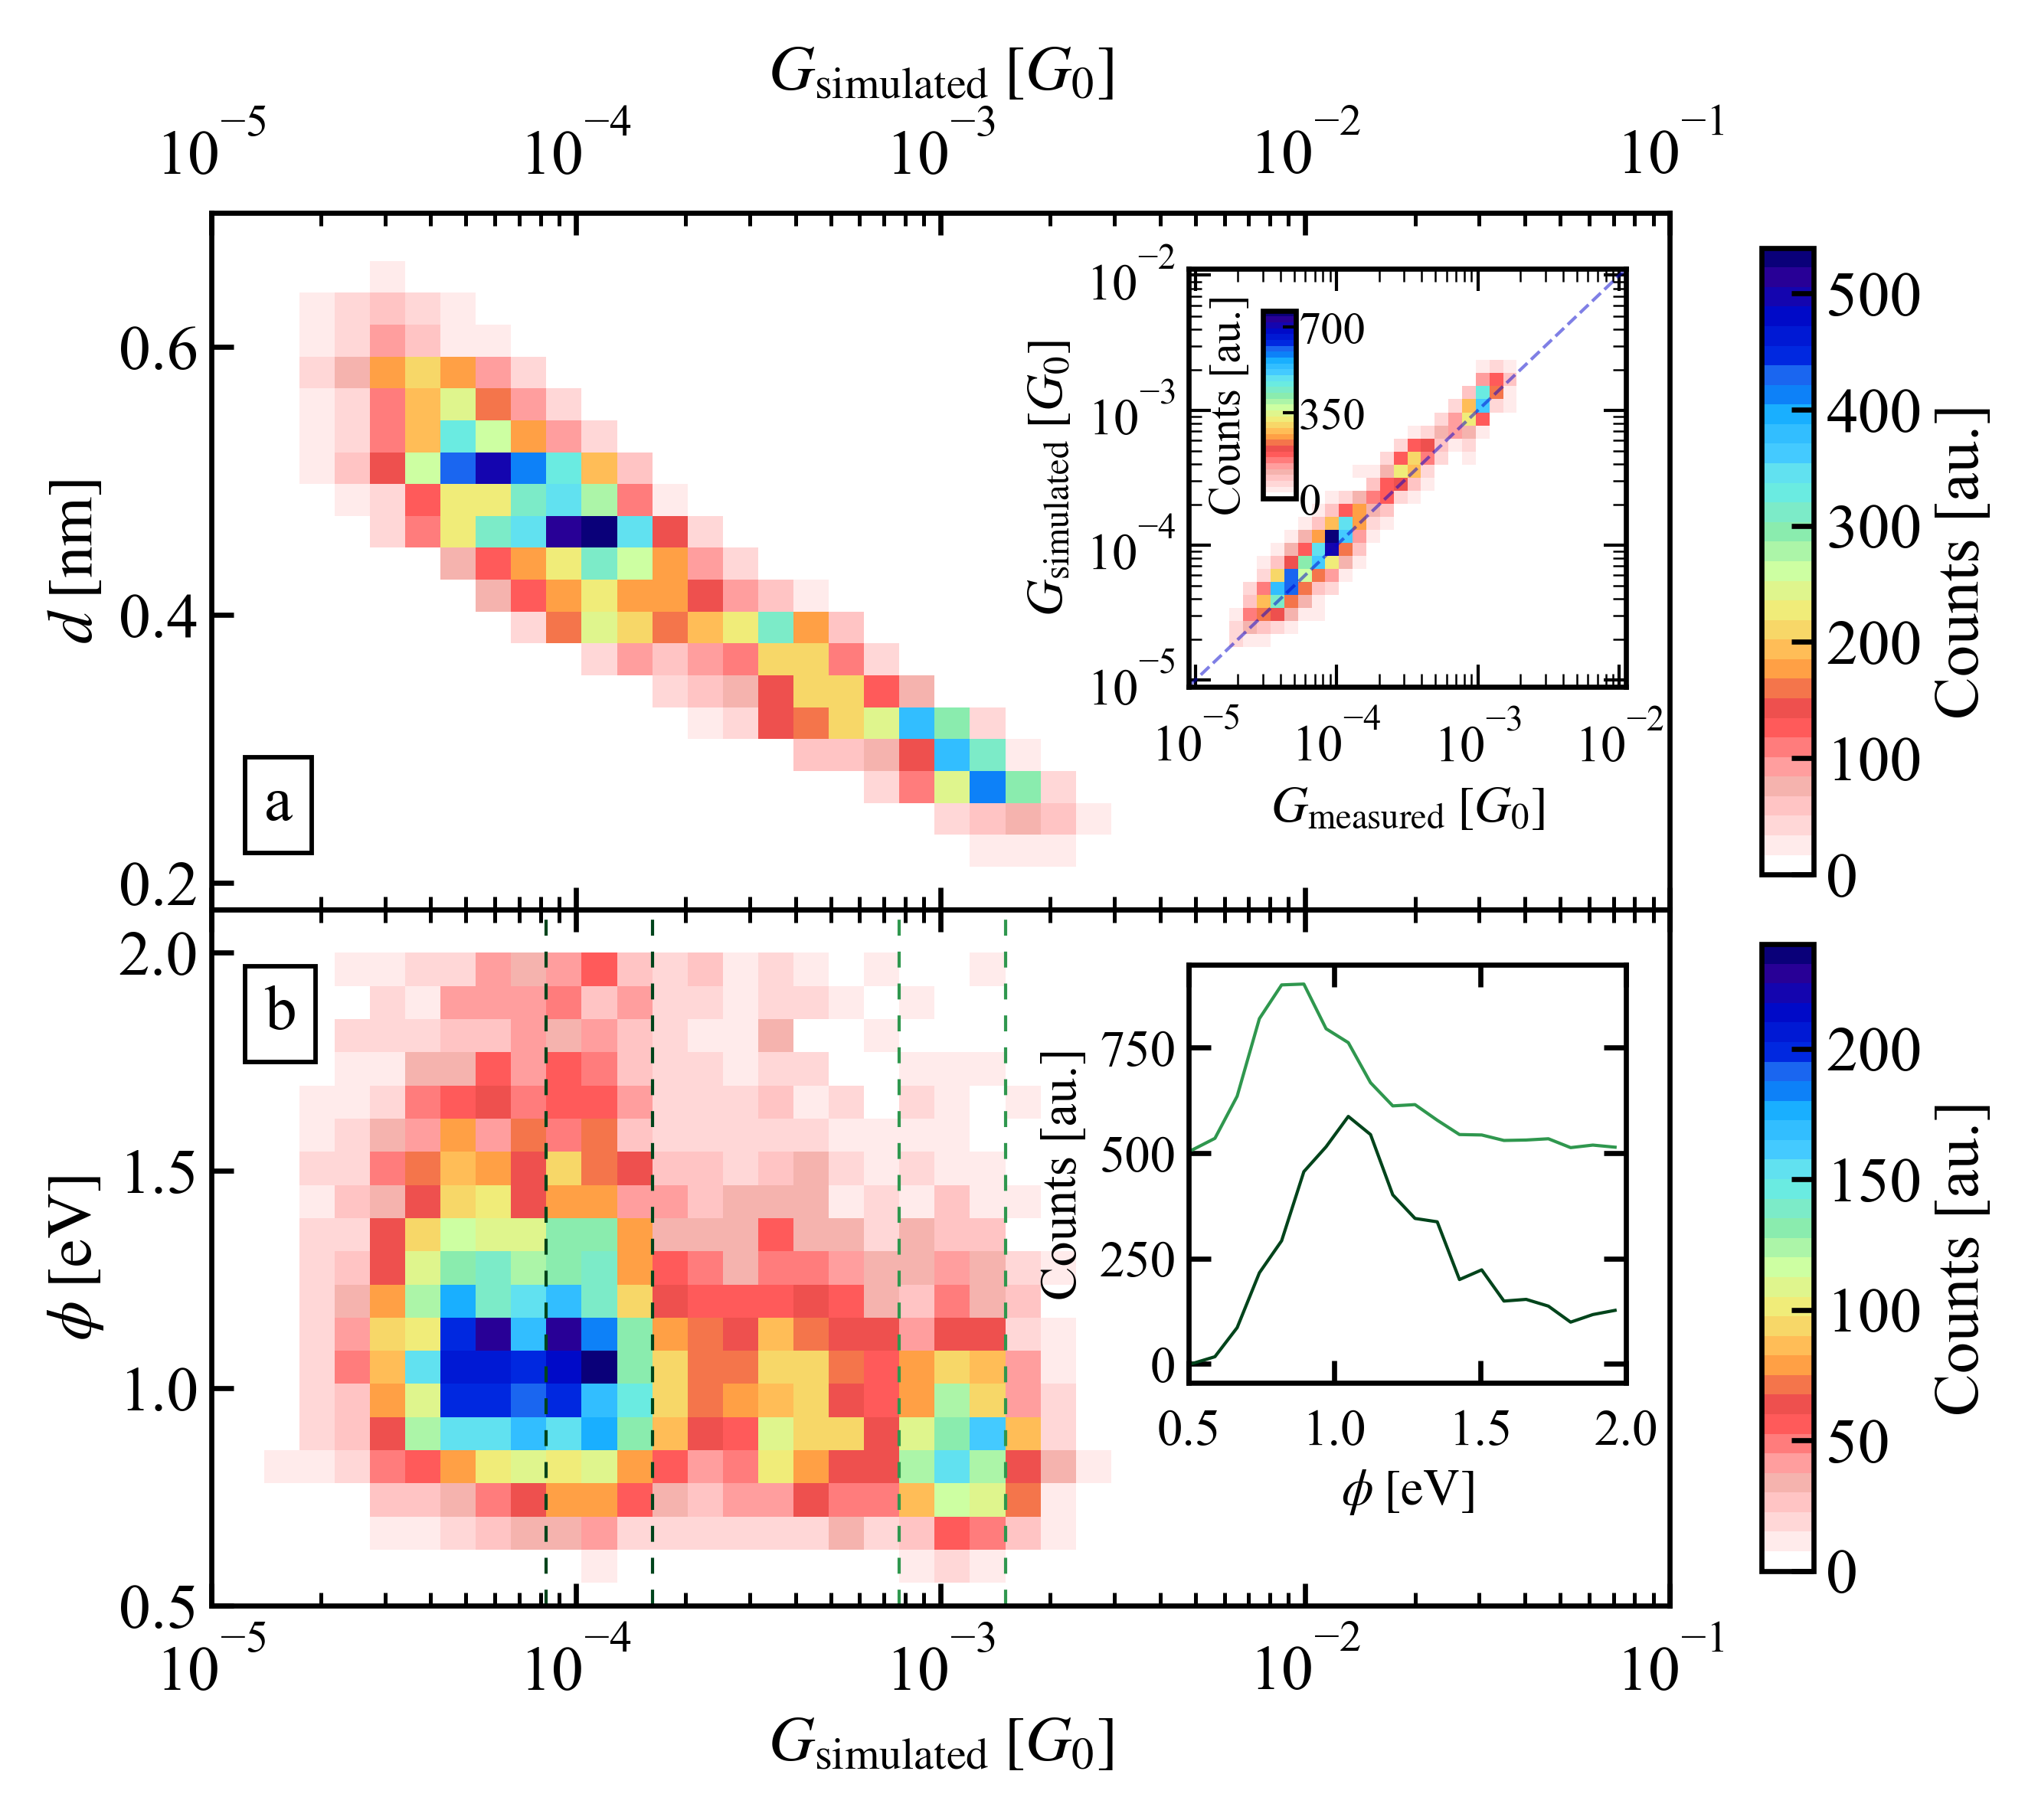

In [66]:
# bins_G, _ = utils.calc_hist_1d_single(data=sim_data_push['G [G0]'], xrange=(1e-5, 1e-1),
#                                       xbins_num=20, log_scale=True, bin_mode='total')
# bins_z, _ = utils.calc_hist_1d_single(data=sim_data_push['z -Gap [nm]'], xrange=(0, 0.7),
#                                       xbins_num=20, log_scale=False, bin_mode='total')
# bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
#                                                   xbins_num=20, log_scale=False, bin_mode='total')

figsize = utils.cm2inch((12, 10))
dpi = 600

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 1, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i]) for i in range(2)]
axin = [a.inset_axes([0.67, 0.32, 0.3, 0.6]) for a in ax]

axc_cond = axin[0].inset_axes([0.17, 0.45, 0.075, 0.45])

print(len(ax))

axin[0].tick_params(axis='both', labelsize=8)
axin[1].tick_params(axis='both', labelsize=8)

ax[0].set_xscale('log')
axin[0].set_xscale('log')
axin[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1e-5, 1e-1)
ax[1].set_xlim(1e-5, 1e-1)
ax[0].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)

middle_G = np.logspace(-5, -2, 32)
hist_1d_G, bins_G  = np.histogram(sim_data_push['G [G0]'], bins=calc_bins(middle=middle_G, log_scale=True))

middle_z = np.linspace(0.2, 0.7, 22)

hist_1d_z, bins_z  = np.histogram(sim_data_push['z -Gap [nm]'], bins=calc_bins(middle=middle_z, log_scale=False))



hist_1d_Phi, bins_Phi  = np.histogram(sim_data_push['Phi - Barrier [eV]'], bins = np.linspace(0.4, 2., 22))
bar_width = np.diff(bins_Phi)
middle_Phi = bins_Phi[:-1] + bar_width / 2


gap_2D, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'],
                                        bins=[bins_G, bins_z])
gap_2D = gap_2D.T

x_mesh_gap, y_mesh_gap = np.meshgrid(xedges, yedges)
im_gap = ax[0].pcolormesh(x_mesh_gap, y_mesh_gap, gap_2D, cmap=utils.cmap_geo32, vmin=0)

barrier_2d, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'],
                                            bins=[bins_G, bins_Phi])
barrier_2d = barrier_2d.T

x_mesh_barrier, y_mesh_barrier = np.meshgrid(xedges, yedges)
im_barrier = ax[1].pcolormesh(x_mesh_barrier, y_mesh_barrier, barrier_2d, cmap=utils.cmap_geo32, vmin=0)

ax[1].set_ylim(0.5, 2.1)

cond_2D, xedges, yedges = np.histogram2d(sim_data_push['G_meas1 [G0]'], sim_data_push['G [G0]'],
                                         bins=[bins_G, bins_G])
x_mesh_cond, y_mesh_cond = np.meshgrid(xedges, yedges)
cond_2D = cond_2D.T

im_cond = axin[0].pcolormesh(x_mesh_cond, y_mesh_cond, cond_2D, cmap=utils.cmap_geo32, vmin=0)

# axin[1].plot(middle_Phi, hist_1d_Phi, lw=1)
axin[1].set_xlim(0.5, 2)

ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', labelpad=4)
ax[0].set_ylabel(r'$d\;[\mathrm{nm}]$', fontsize=10)

ax[1].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$')
ax[1].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

axin[0].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', fontsize=8)
axin[0].set_ylabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', fontsize=8)

axin[1].set_xlabel(r'$\phi\;[\mathrm{eV}]$', fontsize=8)
axin[1].set_ylabel(r'Counts [au.]', fontsize=8)

axin[0].plot(bins_G, bins_G, ls='--', lw=0.5, c='mediumblue', alpha=0.5)
axin[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].tick_params(axis='both', which='major', width=0.5)
axin[0].tick_params(axis='both', which='minor', width=0.3)

my_oranges = colormaps['Greens'](np.linspace(0.4, 1, 3))[::-1]

# ax[1].axvline(bins_G[7], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[16], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[20], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[23], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])

# axin[1].plot(middle_Phi, barrier_2d[:, 7:10].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 10:13].sum(axis=1), lw=0.5, c=my_oranges[0])
# axin[1].plot(middle_Phi, barrier_2d[:, 13:16].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 20:23].sum(axis=1)+500, lw=0.5, c=my_oranges[1])
axin[1].set_xticks([0.5, 1, 1.5, 2])

fig.colorbar(im_gap, ax=ax[0], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 100, 200, 300, 400, 500])
fig.colorbar(im_barrier, ax=ax[1], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 50, 100, 150, 200])
fig.colorbar(im_cond, cax=axc_cond, shrink=0.9, aspect=12, orientation='vertical', ticks=[0, 350, 700])
axc_cond.tick_params(axis='y', labelsize=7, width=0.5, size=2,
                     top=False, bottom=False, left=False, right=True,
                     labeltop=False, labelbottom=False, labelleft=False, labelright=True, pad=0.5)
axc_cond.yaxis.set_label_position('left')
axc_cond.set_ylabel('Counts [au.]', fontsize=7)

ax[0].set_ylim(0.18, 0.7)

print(ax[0].get_xlim(), ax[1].get_xlim())
print(ax[0].get_ylim(), ax[1].get_ylim())

bbox_props = dict(boxstyle="square", lw=0.7, fc="w", ec="black", alpha=1)
ax[0].text(s='a', x=1.4e-5, y=0.15*(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])+ax[0].get_ylim()[0],
           bbox=bbox_props, va='center')
ax[1].text(s='b', x=1.4e-5, y=0.85*(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])+ax[1].get_ylim()[0],
           bbox=bbox_props, va='center')

plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/gap_barrier_conductance_distribution_push_1.png'), bbox_inches='tight')

2
(1e-05, 0.1) (1e-05, 0.1)
(0.18, 0.7) (0.5, 2.1)


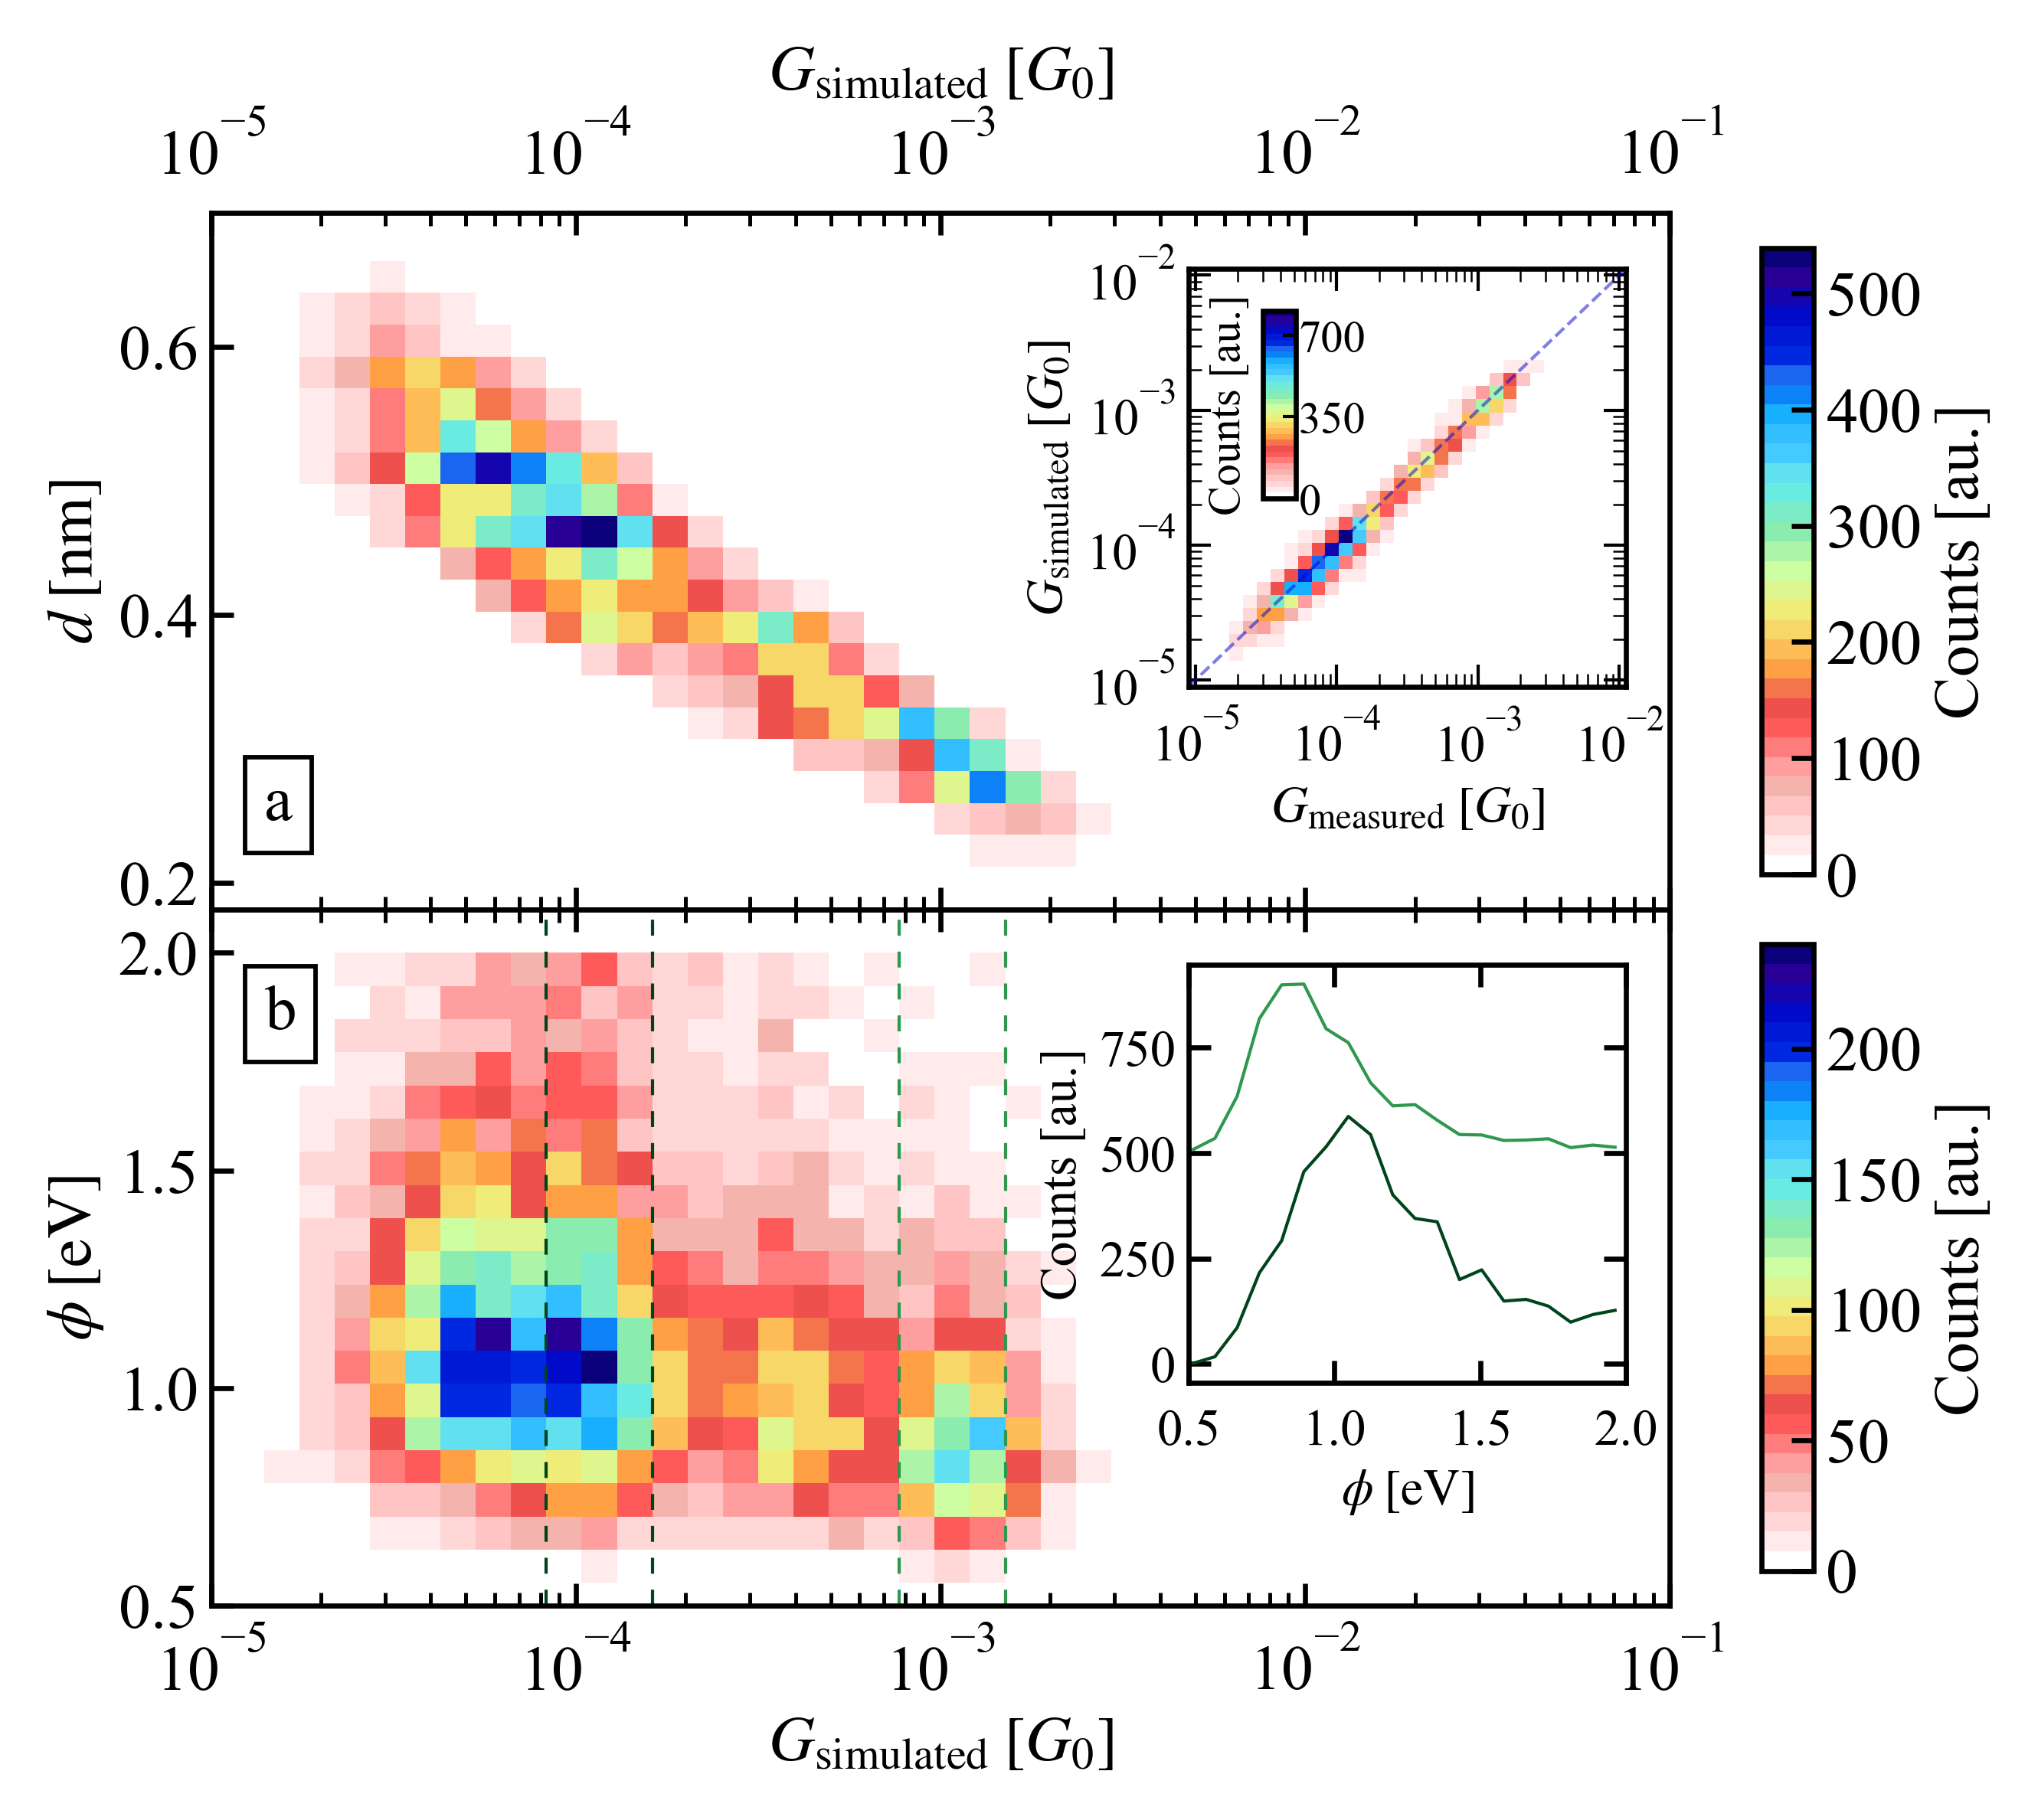

In [67]:
# bins_G, _ = utils.calc_hist_1d_single(data=sim_data_push['G [G0]'], xrange=(1e-5, 1e-1),
#                                       xbins_num=20, log_scale=True, bin_mode='total')
# bins_z, _ = utils.calc_hist_1d_single(data=sim_data_push['z -Gap [nm]'], xrange=(0, 0.7),
#                                       xbins_num=20, log_scale=False, bin_mode='total')
# bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
#                                                   xbins_num=20, log_scale=False, bin_mode='total')

figsize = utils.cm2inch((12, 10))
dpi = 600

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 1, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i]) for i in range(2)]
axin = [a.inset_axes([0.67, 0.32, 0.3, 0.6]) for a in ax]

axc_cond = axin[0].inset_axes([0.17, 0.45, 0.075, 0.45])

print(len(ax))

axin[0].tick_params(axis='both', labelsize=8)
axin[1].tick_params(axis='both', labelsize=8)

ax[0].set_xscale('log')
axin[0].set_xscale('log')
axin[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1e-5, 1e-1)
ax[1].set_xlim(1e-5, 1e-1)
ax[0].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=False, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)
axin[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                    labelleft=True, labelright=False, labeltop=False, labelbottom=True)

middle_G = np.logspace(-5, -2, 32)
hist_1d_G, bins_G  = np.histogram(sim_data_push['G [G0]'], bins=calc_bins(middle=middle_G, log_scale=True))

middle_z = np.linspace(0.2, 0.7, 22)

hist_1d_z, bins_z  = np.histogram(sim_data_push['z -Gap [nm]'], bins=calc_bins(middle=middle_z, log_scale=False))



hist_1d_Phi, bins_Phi  = np.histogram(sim_data_push['Phi - Barrier [eV]'], bins = np.linspace(0.4, 2., 22))
bar_width = np.diff(bins_Phi)
middle_Phi = bins_Phi[:-1] + bar_width / 2


gap_2D, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'],
                                        bins=[bins_G, bins_z])
gap_2D = gap_2D.T

x_mesh_gap, y_mesh_gap = np.meshgrid(xedges, yedges)
im_gap = ax[0].pcolormesh(x_mesh_gap, y_mesh_gap, gap_2D, cmap=utils.cmap_geo32, vmin=0)

barrier_2d, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
barrier_2d = barrier_2d.T

x_mesh_barrier, y_mesh_barrier = np.meshgrid(xedges, yedges)
im_barrier = ax[1].pcolormesh(x_mesh_barrier, y_mesh_barrier, barrier_2d, cmap=utils.cmap_geo32, vmin=0)

ax[1].set_ylim(0.5, 2.1)

cond_2D, xedges, yedges = np.histogram2d(sim_data_push['G_meas2 [G0]'], sim_data_push['G [G0]'],
                                         bins=[bins_G, bins_G])
x_mesh_cond, y_mesh_cond = np.meshgrid(xedges, yedges)
cond_2D = cond_2D.T

im_cond = axin[0].pcolormesh(x_mesh_cond, y_mesh_cond, cond_2D, cmap=utils.cmap_geo32, vmin=0)

# axin[1].plot(middle_Phi, hist_1d_Phi, lw=1)
axin[1].set_xlim(0.5, 2)

ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', labelpad=4)
ax[0].set_ylabel(r'$d\;[\mathrm{nm}]$', fontsize=10)

ax[1].set_xlabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$')
ax[1].set_ylabel(r'$\phi\;[\mathrm{eV}]$')

axin[0].set_xlabel(r'$G_{\mathrm{measured}}\;[G_{0}]$', fontsize=8)
axin[0].set_ylabel(r'$G_{\mathrm{simulated}}\;[G_{0}]$', fontsize=8)

axin[1].set_xlabel(r'$\phi\;[\mathrm{eV}]$', fontsize=8)
axin[1].set_ylabel(r'Counts [au.]', fontsize=8)

axin[0].plot(bins_G, bins_G, ls='--', lw=0.5, c='mediumblue', alpha=0.5)
axin[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
axin[0].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
axin[0].tick_params(axis='both', which='major', width=0.5)
axin[0].tick_params(axis='both', which='minor', width=0.3)

my_oranges = colormaps['Greens'](np.linspace(0.4, 1, 3))[::-1]

# ax[1].axvline(bins_G[7], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[10], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[13], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
# ax[1].axvline(bins_G[16], ls=(0, (5, 5)), lw=0.5, c=my_oranges[0])
ax[1].axvline(bins_G[20], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])
ax[1].axvline(bins_G[23], ls=(0, (5, 5)), lw=0.5, c=my_oranges[1])

# axin[1].plot(middle_Phi, barrier_2d[:, 7:10].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 10:13].sum(axis=1), lw=0.5, c=my_oranges[0])
# axin[1].plot(middle_Phi, barrier_2d[:, 13:16].sum(axis=1), lw=0.5, c=my_oranges[0])
axin[1].plot(middle_Phi, barrier_2d[:, 20:23].sum(axis=1)+500, lw=0.5, c=my_oranges[1])
axin[1].set_xticks([0.5, 1, 1.5, 2])

fig.colorbar(im_gap, ax=ax[0], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 100, 200, 300, 400, 500])
fig.colorbar(im_barrier, ax=ax[1], shrink=0.9, aspect=12, label='Counts [au.]', ticks=[0, 50, 100, 150, 200])
fig.colorbar(im_cond, cax=axc_cond, shrink=0.9, aspect=12, orientation='vertical', ticks=[0, 350, 700])
axc_cond.tick_params(axis='y', labelsize=7, width=0.5, size=2,
                     top=False, bottom=False, left=False, right=True,
                     labeltop=False, labelbottom=False, labelleft=False, labelright=True, pad=0.5)
axc_cond.yaxis.set_label_position('left')
axc_cond.set_ylabel('Counts [au.]', fontsize=7)

ax[0].set_ylim(0.18, 0.7)

print(ax[0].get_xlim(), ax[1].get_xlim())
print(ax[0].get_ylim(), ax[1].get_ylim())

bbox_props = dict(boxstyle="square", lw=0.7, fc="w", ec="black", alpha=1)
ax[0].text(s='a', x=1.4e-5, y=0.15*(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])+ax[0].get_ylim()[0],
           bbox=bbox_props, va='center')
ax[1].text(s='b', x=1.4e-5, y=0.85*(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])+ax[1].get_ylim()[0],
           bbox=bbox_props, va='center')

plt.savefig(home_folder_1.joinpath(f'results/phd_Greta/gap_barrier_conductance_distribution_push_2.png'), bbox_inches='tight')

### pull